<a href="https://colab.research.google.com/github/LubnaM/AI4PD/blob/main/Peptides_based_PDstratusnStates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Import datasets
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
med = pd.read_csv("/content/drive/MyDrive/data/train_clinical_data.csv")


# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Group by patient_id and check if all months_to_check are present for each patient
patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_check).issubset(set(x)))

# Filter patients who have records in all months_to_check
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()

# Filter the dataframe to only include patients with all the required months
df = df[df['patient_id'].isin(patients_with_all_months)]

# Group by patient_id and collect unique visit_months for each patient
months_with_records = df.groupby('patient_id')['visit_month'].apply(lambda x: set(x))

# Identify missing months for each patient (optional validation)
missing_months = {patient_id: sorted(set(months_to_check) - months_with_records.get(patient_id, set()))
                  for patient_id in patients_with_all_months}

# Time points to be removed
time_points_to_remove = [3, 6, 18, 30, 54, 72, 84, 96, 108]

# Remove rows with the specified time points
filtered_df = df[~df['visit_month'].isin(time_points_to_remove)]

# Filter out patients based on medication status (example from med dataset)
patients_to_remove = med[(med['upd23b_clinical_state_on_medication'] == 'On') |
                         (med['upd23b_clinical_state_on_medication'] == 'Off')]['patient_id'].tolist()

# Remove these patients from the dataframe
filtered_df = filtered_df[~filtered_df['patient_id'].isin(patients_to_remove)]

# Group by patient and visit_month, and create a list of (peptide_name, peptide_abundance) pairs
patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(
    lambda x: list(zip(x['Peptide'], x['PeptideAbundance']))
).reset_index(name='peptide_data')

# Pivot the dataframe to get peptide abundances for each visit_month and patient_id
pivot_df = filtered_df.pivot_table(
    index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance'
).reset_index().fillna(0)

# Flatten MultiIndex columns
pivot_df.columns = pivot_df.columns.to_flat_index()

# Print the pivoted dataframe
print(pivot_df)

# Optional: statistical analysis and further processing (if needed)
# e.g., testing if the PeptideAbundances follow a normal distribution (omitted for brevity)


<ipython-input-3-432c5a51cf73>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(


Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
5              4172           60     12347800.0   
6              5178            0      8646540.0   
7              5178           12      7469580.0   
8              5178           24      6137290.0   
9              5178           36      6833670.0   
10             5178           48      4913850.0   
11             5178           60      5764340.0   
12            17414            0     16476100.0   
13            17414           12      2430180.0   
14            17414           24     15745900.0   
15            17414           36     14162600.0   
16            17414           48     12517400.0   
17            17414           60            0.0   
18            27300            

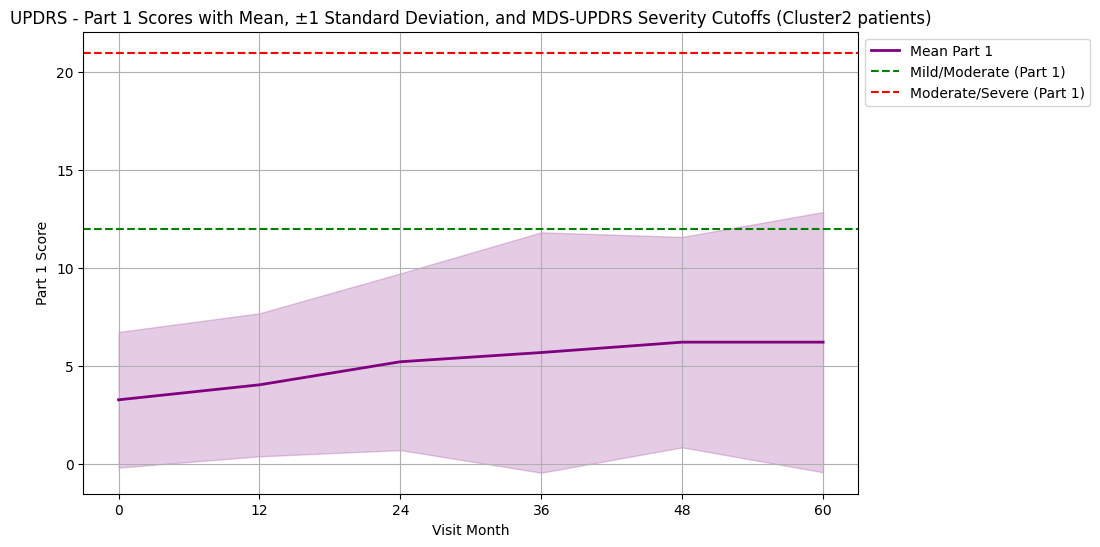

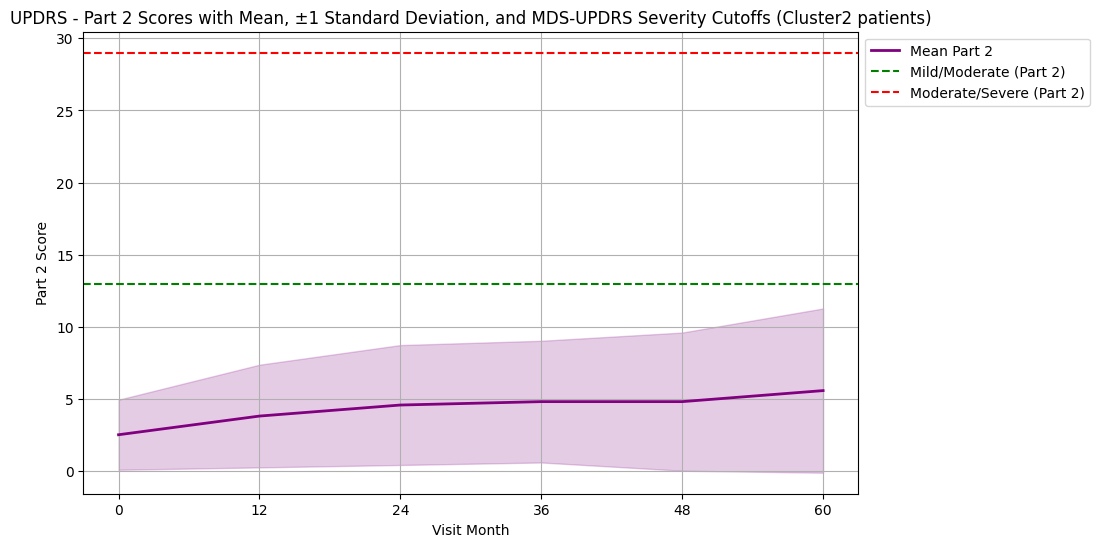

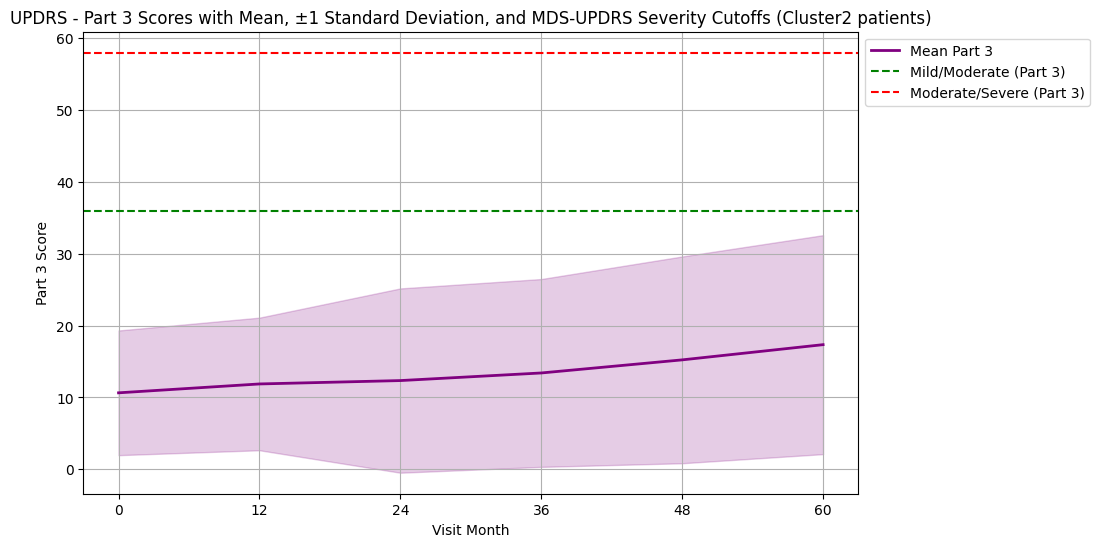

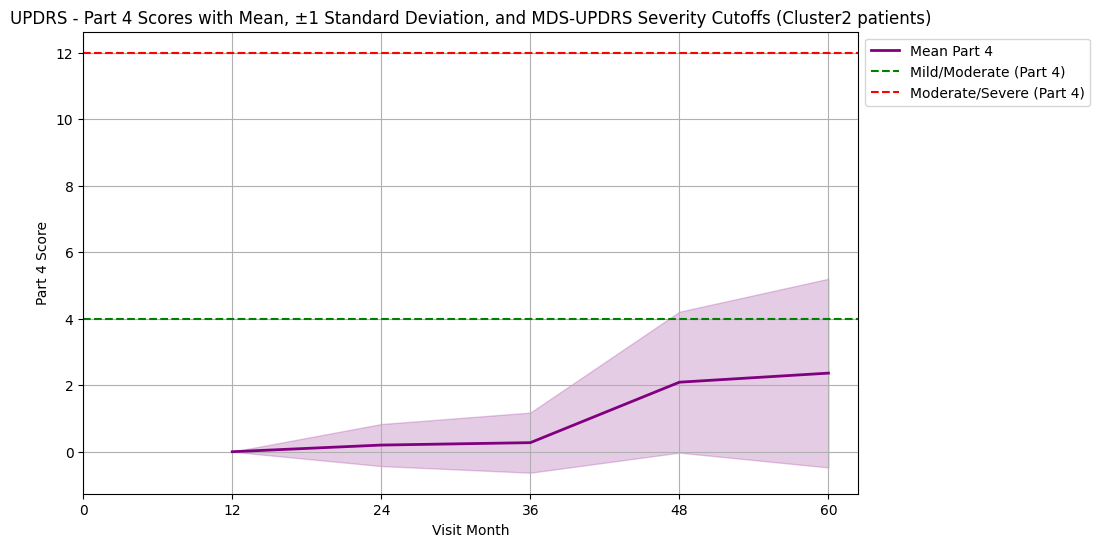

In [ ]:
"To visualize the created group clusters' pattern and scaling systems cuttoffs"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define cut-off values for MDS-UPDRS (example thresholds)
df = med[med['patient_id'].isin(pivot_df['patient_id'].unique())]
'''
patients = [4172, 6211, 17414, 18183, 20404, 23391, 27468, 35477, 41444, 54095, 60803, 63889]
patients = [26210, 27300, 62792, 45161, 35696, 57009, 40022, 5178, 59550]
'''
patients = [6211, 25562, 27300, 35696, 45161, 60803, 63889] #original cluster 1
patients = [4172, 5178, 17414, 18183, 20404, 23391, 26210, 27468, 28327, 35477, 40022, 41444, 54095, 57009, 59550, 62723, 62792] # original cluster 2


df = df[df['patient_id'].isin(patients)]  # Assuming this line is relevant for your context

# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Filter the data to only include the months in `months_to_check`
df = df[df['visit_month'].isin(months_to_check)]


mds_updrs_cutoffs = {
    'Part 1': {
        'mild/moderate': 12,
        'moderate/severe': 21
    },
    'Part 2': {
        'mild/moderate': 13,
        'moderate/severe': 29
    },
    'Part 3': {
        'mild/moderate': 36,
        'moderate/severe': 58
    },
    'Part 4': {
        'mild/moderate': 4,
        'moderate/severe': 12
    }
}

# List of UPDRS parts to plot
updrs_parts = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
updrs_part_names = ['Part 1', 'Part 2', 'Part 3', 'Part 4']

# Loop through the UPDRS parts to create plots
for part, part_name in zip(updrs_parts, updrs_part_names):
    # Group by visit_month to calculate the mean and std for the current UPDRS score
    grouped = df.groupby('visit_month')[part].agg(['mean', 'std'])

    # Create the plot for this UPDRS part
    plt.figure(figsize=(10, 6))

    # Plot the mean for the current UPDRS score
    plt.plot(grouped.index, grouped['mean'], label=f'Mean {part_name}', linestyle='-', linewidth=2, color='purple')

    # Plot the ±1 standard deviation range
    plt.fill_between(grouped.index,
                     grouped['mean'] - grouped['std'],
                     grouped['mean'] + grouped['std'],
                     alpha=0.2, color='purple')

    # Plot the MDS-UPDRS cutoffs for each part
    plt.axhline(mds_updrs_cutoffs[part_name]['mild/moderate'], color='green', linestyle='--', label=f'Mild/Moderate ({part_name})')
    plt.axhline(mds_updrs_cutoffs[part_name]['moderate/severe'], color='red', linestyle='--', label=f'Moderate/Severe ({part_name})')

    # Extract unique months in the dataset
    unique_months = sorted(df['visit_month'].unique())

    # Set the x-axis ticks to the unique months that exist in the dataset
    plt.xticks(unique_months)

    # Customize the plot
    plt.title(f'UPDRS - {part_name} Scores with Mean, ±1 Standard Deviation, and MDS-UPDRS Severity Cutoffs (Cluster2 patients)')
    plt.xlabel('Visit Month')
    plt.ylabel(f'{part_name} Score')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Show the plot
    plt.show()


169      6211
170      6211
171      6211
172      6211
173      6211
        ...  
2564    63889
2565    63889
2566    63889
2567    63889
2568    63889
Name: patient_id, Length: 80, dtype: int64


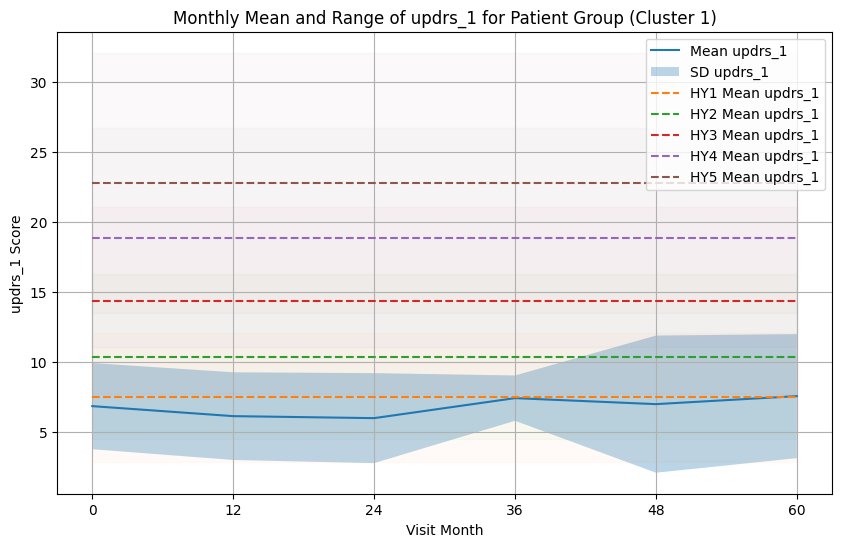

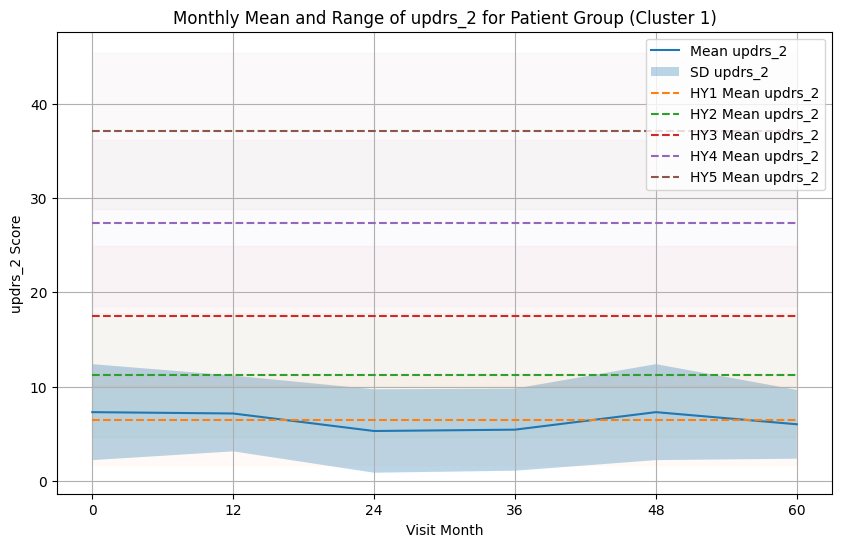

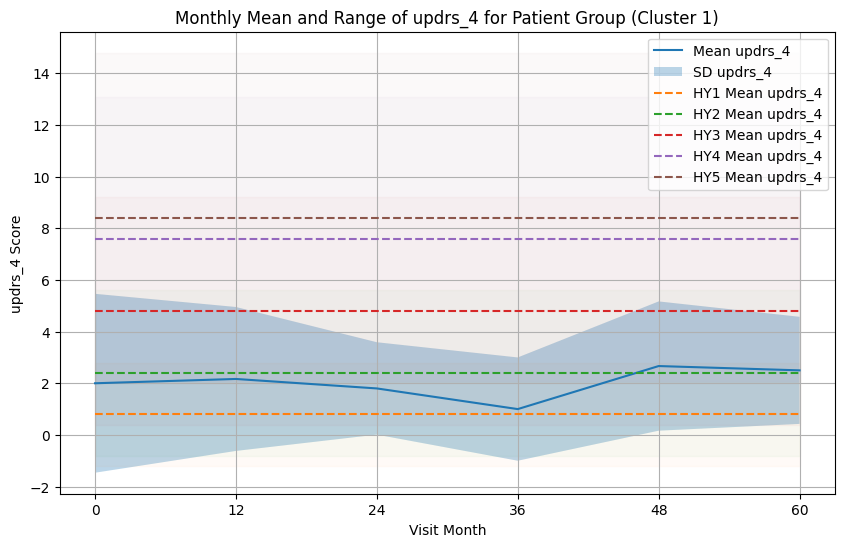

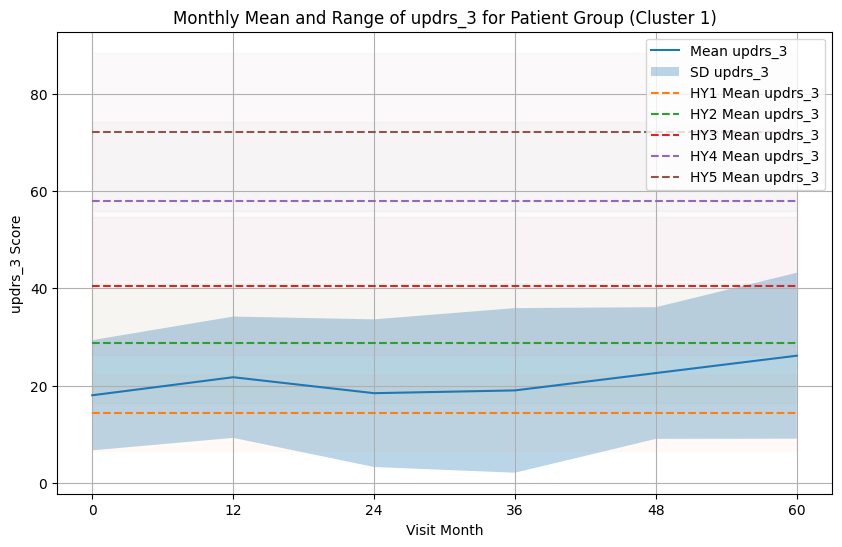

In [ ]:
'For UPDRS scores vs HY scales'
#for patients with on medication, updrs_3 should be replaced with updrs_3_on should be replaced with,
#and if off medication, it should be replaced with UPDRS_3_off
import matplotlib.pyplot as plt
import seaborn as sns

# Patient group IDs (example lists, replace with actual groups)
patients = [6211, 25562, 27300, 35696, 45161, 60803, 63889] #original cluster 1
#patients = [4172, 5178, 17414, 18183, 20404, 23391, 26210, 27468, 28327, 35477, 40022, 41444, 54095, 57009, 59550, 62723, 62792] # original cluster 2
#patients = [4172, 6211, 17414, 18183, 20404, 23391, 27468, 35477, 41444, 54095, 60803, 63889]
#patients = [26210, 27300, 62792, 45161, 35696, 57009, 40022, 5178, 59550]
#patients = [62723, 28327]# Group of patients (you can repeat this process for multiple groups)
#step-wise with KPCA
#patients = [ 4172, 5178, 6211, 17414, 18183, 20404, 23391, 25562, 26210, 27300, 28327, 35477, 35696, 40022, 45161, 54095, 57009, 59550, 60803, 62723, 62792, 63889]

# Define the mean and standard deviation for each UPDRS score and HY scale stages
hy_scale_values = {
    'updrs_1': {
        'HY1': (7.5, 4.6), 'HY2': (10.4, 5.9), 'HY3': (14.4, 6.7), 'HY4': (18.9, 7.8), 'HY5': (22.8, 9.3)
    },
    'updrs_2': {
        'HY1': (6.5, 4.8), 'HY2': (11.2, 6.6), 'HY3': (17.5, 7.4), 'HY4': (27.3, 8.8), 'HY5': (37.1, 8.3)
    },
   # Adding the new scales: UPDRS III - OFF and UPDRS - ON
    'updrs_3_off': {
        'HY1': (14.4, 7.0), 'HY2': (29.4, 12.0), 'HY3': (42.7, 15.6), 'HY4': (61.1, 16.6), 'HY5': (73.7, 17.0)
    },
    'updrs_3_on': {
        'HY1': (14.4, 7.8), 'HY2': (28.8, 12.3), 'HY3': (40.5, 14.2), 'HY4': (58.0, 16.2), 'HY5': (72.2, 16.3)
    },
     'updrs_3': {
        'HY1': (14.4, 7.8), 'HY2': (28.8, 12.3), 'HY3': (40.5, 14.2), 'HY4': (58.0, 16.2), 'HY5': (72.2, 16.3)
    },
    'updrs_4': {
        'HY1': (0.8, 2.0), 'HY2': (2.4, 3.2), 'HY3': (4.8, 4.4), 'HY4': (7.6, 5.5), 'HY5': (8.4, 6.4)
    }
}

# Filter dataframe for patients in the group
df_g= med[med['patient_id'].isin(pivot_df['patient_id'].unique().tolist())]
df_group = df_g[df_g['patient_id'].isin(patients)]#_with_medication)]
print(df_group['patient_id'])


# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Filter the data to only include the months in `months_to_check`
df_group_filtered = df_group[df_group['visit_month'].isin(months_to_check)]

# Group by visit_month and calculate mean and range for each updrs column
df_group_mean = df_group_filtered.groupby('visit_month')[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].mean()
df_group_range = df_group_filtered.groupby('visit_month')[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].agg('std')#['min', 'max'])

# List of UPDRS scores to plot
updrs_scores = ['updrs_1', 'updrs_2', 'updrs_4','updrs_3']#,'updrs_3_off','updrs_3_on']

# Plot each UPDRS score in a separate graph
for score in updrs_scores:
    plt.figure(figsize=(10, 6))

    # Plot the mean UPDRS score and range
    # Plot the mean UPDRS score
    plt.plot(df_group_mean.index, df_group_mean[score], label=f'Mean {score}')

    # Shade the area representing the standard deviation
    plt.fill_between(df_group_mean.index,
                     df_group_mean[score] - df_group_range[score],  # Lower bound: mean - SD
                     df_group_mean[score] + df_group_range[score],  # Upper bound: mean + SD
                     alpha=0.3, label=f'SD {score}')

    # Add a straight line for each HY stage and SD shading with very light color
    hy_means = [hy_scale_values[score][stage][0] for stage in ['HY1', 'HY2', 'HY3', 'HY4', 'HY5']]
    hy_stds = [hy_scale_values[score][stage][1] for stage in ['HY1', 'HY2', 'HY3', 'HY4', 'HY5']]

    for i, (hy_mean, hy_std) in enumerate(zip(hy_means, hy_stds)):
        # Plot a straight line for each HY stage (mean value)
        plt.plot(months_to_check, [hy_mean] * len(months_to_check), label=f'HY{str(i+1)} Mean {score}', linestyle='--', color=f'C{i+1}')

        # Add extremely light shading for standard deviation (SD)
        plt.fill_between(months_to_check,
                         [hy_mean - hy_std] * len(months_to_check),
                         [hy_mean + hy_std] * len(months_to_check),
                         alpha=0.03, color=f'C{i+1}')  # Further reduced alpha to make the shading extremely light

    # Customize the plot
    plt.title(f"Monthly Mean and Range of {score} for Patient Group (Cluster 1)")
    plt.xlabel("Visit Month")
    plt.ylabel(f"{score} Score")
    plt.xticks(months_to_check)  # Ensure the x-axis only shows the months in `months_to_check`

    # Add legends
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
'For statistical analysis for discovered ggroups differences'
#!pip install scikit-bio

import pandas as pd
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA,KernelPCA # Import PCA from sklearn.decomposition
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist # Import pdist
from skbio.stats.distance import DistanceMatrix # Import DistanceMatrix




# Patient group IDs (example lists, replace with actual groups)
patients = [6211, 25562, 27300, 35696, 45161, 60803, 63889] #original cluster 1
patients = [4172, 5178, 17414, 18183, 20404, 23391, 26210, 27468, 28327, 35477, 40022, 41444, 54095, 57009, 59550, 62723, 62792] # original cluster 2
#patients = [4172, 6211, 17414, 18183, 20404, 23391, 27468, 35477, 41444, 54095, 60803, 63889]
#patients = [26210, 27300, 62792, 45161, 35696, 57009, 40022, 5178, 59550]
#patients = [62723, 28327]# Group of patients (you can repeat this process for multiple groups)
#step-wise with KPCA
#patients = [ 4172, 5178, 6211, 17414, 18183, 20404, 23391, 25562, 26210, 27300, 28327, 35477, 35696, 40022, 45161, 54095, 57009, 59550, 60803, 62723, 62792, 63889]
#patients = [ 4172,  5178, 17414, 27300, 35477, 54095, 57009] #without medication



'----- Mann-Whitney U Test ------'
df=pivot_df.copy(deep=True)
df1 = pivot_df[pivot_df['patient_id'].isin(patients1)]
df2 = pivot_df[pivot_df['patient_id'].isin(patients2)]

#df1 = df1[(df1['visit_month'] >= 0) & (df1['visit_month'] <= 12)]
#df2 = df2[(df2['visit_month'] >= 48) & (df2['visit_month'] <= 60)]


# Clean the column names to avoid special characters in formula
def clean_column_name(name):
    return name.replace('(', '_').replace(')', '_').replace(' ', '_')

# Assuming df is your dataframe
df1.columns = [clean_column_name(col) for col in df1.columns]
# Assuming df is your dataframe
df2.columns = [clean_column_name(col) for col in df2.columns]

peptide_columns=df1.columns[2:]


# Add a 'group' column to distinguish between the two dataframes
df1['cluster'] = 'Cluster 1'  # Group 1 for df1
df2['cluster'] = 'Cluster 2'  # Group 2 for df2

# Concatenate the two dataframes
df= pd.concat([df1, df2], axis=0)

# List of peptide-related columns in your dataframe (make sure these match the actual peptide columns)


'''
# Assign a cluster based on visit_month (0-24 = Cluster 1, 36-60 = Cluster 2)
df['cluster'] = df['visit_month'].apply(lambda x: 'Cluster 1' if 0 <= x <= 36 else 'Cluster 2')
'''

# Compute distance matrix (e.g., Euclidean distance) and convert to DistanceMatrix
dist_matrix = pdist(df[peptide_columns], metric='euclidean')
dist_matrix = DistanceMatrix(dist_matrix, ids=df.index)  # Convert to DistanceMatrix

# PERMANOVA
# Compute PERMANOVA with cluster as the grouping factor
permanova_results = permanova(dist_matrix, df['cluster'],permutations=9999)
print(f'PERMANOVA p-value: {permanova_results}')

ModuleNotFoundError: No module named 'skbio'

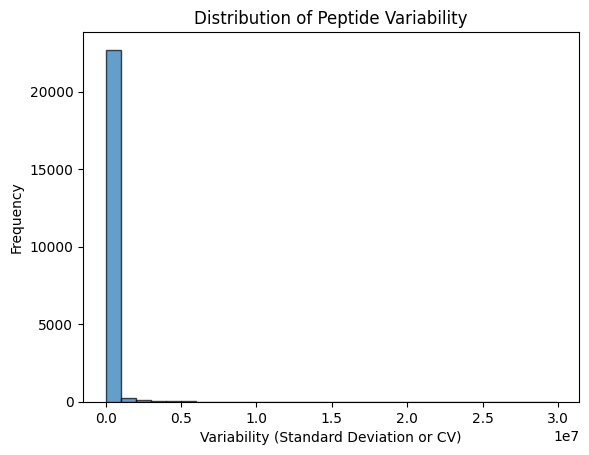

Peptide  patient_id  visit_month  \
0              4172            0   
1              4172           12   
2              4172           24   
3              4172           36   
4              4172           48   
..              ...          ...   
139           63889           12   
140           63889           24   
141           63889           36   
142           63889           48   
143           63889           60   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  AANEVSSADVK  \
0                                                 45885.7      26284.1   
1                                                 59488.3      21571.8   
2                                                 68732.9      39927.9   
3                                                 51610.8      14630.8   
4                                                 92788.1      30184.7   
..                                                    ...          ...   
139                                              

In [ ]:
'To assess the results after eliminating high variability peptides by visit month'
"""
# For each patient (grouped by 'patient_id'), calculate the std deviation for each peptide
variability_df = pivot_df.groupby('patient_id').std().reset_index()  # Calculate std for each peptide across visit months'''
'To choose variability threshold'

# If you want to use Coefficient of Variation (CV) instead of std:
# variability_df = pivot_df.groupby('patient_id').apply(lambda x: x.std() / x.mean()).reset_index()
# Visualize the variability for each peptide (standard deviation or CV)
variability_values = variability_df.drop(columns=['patient_id'])  # Drop patient_id to focus on variability values
variability_values = variability_values.stack()  # Flatten the DataFrame to one long list

# Plot histogram of variability
plt.hist(variability_values, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Peptide Variability")
plt.xlabel("Variability (Standard Deviation or CV)")
plt.ylabel("Frequency")
plt.show()
'''
'Variability by visit month'

'''

# Threshold for variability: define your threshold (for example, standard deviation > 0.3)


# 1. Select only the peptide columns for comparison
peptide_columns = [col for col in variability_df.columns if col not in ['patient_id', 'visit_month']] # Select all peptide columns

# 2. Calculate mean variability across all patients for each peptide
mean_variability = variability_df[peptide_columns].mean()

#variability_threshold = np.percentile(mean_variability, 95)
Q1 = np.percentile(mean_variability, 25)
Q3 = np.percentile(mean_variability, 75)
IQR = Q3 - Q1
variability_threshold = Q3 + 1.5 * IQR  # Common outlier detection rule


# 3. Identify highly variable peptides based on the mean variability
high_variability_peptides = mean_variability[mean_variability > variability_threshold].index.tolist()

# 4. Filter out these highly variable peptides from your original pivot_df
pivot_df = pivot_df.drop(columns=high_variability_peptides)

df1 = pivot_df.copy(deep=True)

df1= pivot_df.copy(deep=True)
print(df1)
'''
"""


In [ ]:
"Calculate the diff between peptide's abundance for 2 consecutive months, execlusing month 0" #[acheived low clusterng performance]
'''

import pandas as pd
# Your original pivot table
pivot_df = filtered_.pivot_table(index=['patient_id', 'visit_month'],
                                 columns='Peptide',
                                 values='PeptideAbundance').reset_index()
print(pivot_df.head(6))

# Sort the DataFrame by patient_id and visit_month to ensure correct order
pivot_df = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Calculate the difference in abundance between consecutive months for each peptide
for peptide in pivot_df.columns:
    if peptide not in ['patient_id', 'visit_month']:  # We skip the 'patient_id' and 'visit_month' columns
        # Calculate the difference between consecutive months for each peptide
        pivot_df[peptide] = pivot_df.groupby('patient_id')[peptide].diff()

# Set the index back to ['patient_id', 'visit_month']
# Optionally, you can replace NaN values for the first month (Month 0) with 0 or another placeholder
pivot_df = pivot_df.fillna(0)  # Replace NaN (for Month 0) with 0 (or another value if needed)
pivot_df = pivot_df[pivot_df['visit_month'] != 0].fillna(0)

# Display the result
print(pivot_df.head(6))
'''

Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
5              4172           60     12347800.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                                 68732.9   
3                                                 51610.8   
4                                                 92788.1   
5                                                 56541.5   

Peptide  AAFTEC(UniMod_4)C(UniMod_4)QAADK  AANEVSSADVK  \
0                               8053090.0      26284.1   
1                               8390120.0      21571.8   
2                              12560900.

In [ ]:
'Eliminate outliers'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Assuming 'data' is your feature data (excluding non-numeric columns like 'patient_id', 'visit_month')
data = pivot_df.drop(columns=['patient_id', 'visit_month'])

# Step 1: Calculate Z-scores for each feature
z_scores = np.abs(zscore(data))  # Calculate absolute Z-scores for all features

# Step 2: Identify outliers for each feature (threshold = 3 for Z-score)
threshold = 3  # Outlier threshold (e.g., Z-score > 3)
outliers = z_scores > threshold  # True for outliers, False for inliers

# Step 3: Count the number of outliers per feature
outliers_count = np.sum(outliers, axis=0)  # Count how many outliers per feature

# Step 4: Identify top features with the highest number of outliers
top_features = np.argsort(outliers_count)[::-1]  # Sort features by number of outliers (descending order)

# Display the top features with the most outliers
print("Top features with the highest number of outliers:")
for idx in top_features[:150]:  # Show top 5 features with highest outliers
    print(f"Feature: {data.columns[idx]}, Outliers: {outliers_count[idx]}")

# Step 5: Remove the features with the highest outliers
top_outlier_features = data.columns[top_features[:150]]  # Select top 5 features with the most outliers

# Remove these top outlier features from the original pivot_df
pivot_df = pivot_df.drop(columns=top_outlier_features)

# Step 6: Visualize the cleaned data after removing top outlier features

# Print the cleaned DataFrame's shape
print(f"Original data shape: {pivot_df.shape}")


'''
# Step 5: Visualize the distributions of Z-scores for each feature and highlight the outliers
num_features = data.shape[1]
num_rows = int(np.ceil(num_features / 4))  # Calculate the number of rows needed

plt.figure(figsize=(12, 8))
for idx in range(num_features):  # Iterate over all features
    plt.subplot(num_rows, 4, idx+1)  # Create a subplot for each feature
    feature_z_scores = z_scores.iloc[:, idx]

    # Plot histogram of Z-scores
    plt.hist(feature_z_scores, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold (Z=3)')
    plt.axvline(x=-threshold, color='red', linestyle='--')
    plt.title(data.columns[idx])
    plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Optional: Filter out the outliers for further analysis
# Keep only rows that are inliers for all features
inliers_mask = (outliers == False).all(axis=1)  # Keep only rows where no feature is an outlier
data_cleaned = data[inliers_mask]  # Filter the data to remove outliers

# Visualize the cleaned data after outlier removal
plt.figure(figsize=(12, 8))
data_cleaned.boxplot(rot=90)  # Boxplot for cleaned features
plt.title('Feature Distributions After Removing Outliers')
plt.show()
'''
df= pivot_df.copy(deep=True)

#['KVPQVSTPTLVEVSR', 'QTALVELVK', 'FQNALLVR']

Top features with the highest number of outliers:
Feature: TLEAQLTPR, Outliers: 8
Feature: AQTTVTC(UniMod_4)MENGWSPTPR, Outliers: 8
Feature: YFIDFVAR, Outliers: 8
Feature: FTFEYSR, Outliers: 8
Feature: WEAEPVYVQR, Outliers: 7
Feature: WSRPQAPITGYR, Outliers: 7
Feature: ELDLNSVLLK, Outliers: 7
Feature: TMSEVGGSVEDLIAK, Outliers: 7
Feature: STSSFPC(UniMod_4)PAGHFNGFR, Outliers: 7
Feature: ATEDEGSEQKIPEATNRR, Outliers: 7
Feature: STTPDITGYR, Outliers: 7
Feature: LAAAVSNFGYDLYR, Outliers: 6
Feature: KLGQSLDC(UniMod_4)NAEVYVVPWEK, Outliers: 6
Feature: SC(UniMod_4)C(UniMod_4)EEQNKVNC(UniMod_4)LQTR, Outliers: 6
Feature: IYISGMAPRPSLAK, Outliers: 6
Feature: ISLPESLK, Outliers: 6
Feature: HQPQEFPTYVEPTNDEIC(UniMod_4)EAFRK, Outliers: 6
Feature: EGQEC(UniMod_4)GVYTPNC(UniMod_4)APGLQC(UniMod_4)HPPKDDEAPLR, Outliers: 6
Feature: FTILDSQGK, Outliers: 6
Feature: DYFMPC(UniMod_4)PGR, Outliers: 6
Feature: SGIEC(UniMod_4)QLWR, Outliers: 6
Feature: DMPASEDLQDLQK, Outliers: 5
Feature: NLHGDGIALWYTR, Outlie

<ipython-input-194-bcae8fa5deb4>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Feature: {data.columns[idx]}, Outliers: {outliers_count[idx]}")


In [ ]:
# Calculate variance for each peptide
'''

columns_to_scale = pivot_df.columns[2:]  # All columns except 'patient_id' and 'visit_month'
variance = pivot_df.groupby('visit_month')[columns_to_scale].var()

# Calculate the 10th percentile of the variance distribution
percentile_threshold = variance.mean().quantile(0.1)

# Identify peptides with variance below the percentile threshold
low_variance_peptides = variance.columns[variance.mean() < percentile_threshold]

print(f"Peptides with low variance below 10th percentile: {len(list(low_variance_peptides))}")

# 5. Exclude peptides with low variance
pivot_df = pivot_df.drop(columns=low_variance_peptides)
df= pivot_df.copy(deep=True)

'''

'\n\ncolumns_to_scale = pivot_df.columns[2:]  # All columns except \'patient_id\' and \'visit_month\'\nvariance = pivot_df.groupby(\'visit_month\')[columns_to_scale].var()\n\n# Calculate the 10th percentile of the variance distribution\npercentile_threshold = variance.mean().quantile(0.1)\n\n# Identify peptides with variance below the percentile threshold\nlow_variance_peptides = variance.columns[variance.mean() < percentile_threshold]\n\nprint(f"Peptides with low variance below 10th percentile: {len(list(low_variance_peptides))}")\n\n# 5. Exclude peptides with low variance\npivot_df = pivot_df.drop(columns=low_variance_peptides)\ndf= pivot_df.copy(deep=True)\n\n'

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' is your dataset (DataFrame) with 300 dimensions (features)

# Step 1: Calculate the correlation matrix
corr_matrix = pivot_df.corr().abs()  # Absolute values to focus on the magnitude of correlation

# Step 2: Set a correlation threshold to detect collinearity (e.g., 0.9)
threshold = 0.9

# Step 3: Identify highly correlated pairs
# We will create a mask to avoid comparing the same feature to itself
upper_triangle = np.triu(corr_matrix, k=1)

# Step 4: Find the columns that are highly correlated (above threshold)
highly_correlated_pairs = np.where(upper_triangle > threshold)

# Step 5: Collect the names of features to drop (one from each highly correlated pair)
columns_to_drop = set()
x=[]
for i, j in zip(*highly_correlated_pairs):
    column_name_1 = corr_matrix.columns[i]
    column_name_2 = corr_matrix.columns[j]
    # Keep the feature with the higher importance, or randomly pick one (we just pick column_name_1 for now)
    columns_to_drop.add(column_name_1)  # We remove column_name_2 for simplicity
    x.append(column_name_1)


# Step 6: Drop the highly correlated features from the dataset
pivot_df = pivot_df.drop(columns=columns_to_drop)

# Step 7: Now df_reduced has reduced collinearity, and you can proceed with your clustering
print(f"Dropped {len(columns_to_drop)} features due to collinearity.")

# Filter out the specified columns from your pivot_df

df1= pivot_df.copy(deep=True)
print(pivot_df['visit_month'].unique())
print(x)

Dropped 42 features due to collinearity.
[ 0 12 24 36 48 60]
['ADLSGITGAR', 'AGAAAGGPGVSGVC(UniMod_4)VC(UniMod_4)K', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'AKLEEQAQQIR', 'ALDFAVGEYNK', 'ALDFAVGEYNK', 'ALEYIENLR', 'ALQDQLVLVAAK', 'ALQDQLVLVAAK', 'ALTDMPQMR', 'ATEHLSTLSEK', 'ATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK', 'ATWSGAVLAGR', 'AYKSELEEQLTPVAEETR', 'AYKSELEEQLTPVAEETR', 'AYKSELEEQLTPVAEETR', 'DASGVTFTWTPSSGK', 'DRLDEVKEQVAEVR', 'DRLDEVKEQVAEVR', 'EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK', 'EGYYGYTGAFR', 'FEHC(UniMod_4)NFNDVTTR', 'FTNIGPDTMR', 'GDFSSANNRDNTYNR', 'GEVQAMLGQSTEELR', 'GGSTSYGTGSETESPR', 'GSPAINVAVHVFR', 'GSPSGEVSHPR', 'HVLFGTVGVPEHTYR', 'IYLYTLNDNAR', 'IYLYTLNDNAR', 'KLVPFATELHER', 'LEPYADQLR', 'LGEVNTYAGDLQK', 'LGPLVEQGR', 'LGPLVEQGR', 'LQAEAFQAR', 'LRTEGDGVYTLNNEK', 'LSPLGEEMR', 'M(UniMod_35)C(UniMod_4)PQLQQYEMHGPEGLR', 'M(UniMod_35)VQEQC(UniMod_4)C(UniMod_4)HSQLEELHC(UniMod_4)ATGISLANEQDR', 'SEALAVDGAGKPGAEEAQDPEGK', '

In [ ]:
'patient elimination by stepwise clustering - Stepwise Clustering to Identify Broad Patient Strata'
# Import necessary libraries
from sklearn.decomposition import KernelPCA,PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.manifold import TSNE

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2

# Assuming pivot_df is already loaded

def perform_clustering_and_score(pivot_df):
    '''
    Perform clustering on the given dataframe and calculate the silhouette score.

    Parameters:
    pivot_df (pd.DataFrame): The dataframe containing patient data.

    Returns:
    tuple: A tuple containing the silhouette score, cluster labels, and None (placeholder for KPCA).
    '''

    # Step 1: Perform Agglomerative Clustering with
    #A) original features
    # Step 1: Perform Agglomerative Clustering with
    #A) original features

    '''
    # Step 1: Apply Agglomerative Clustering on the cleaned data
    # Drop the non-feature columns before clustering
    data = pivot_df.drop(columns=['patient_id', 'visit_month'])
    linked = linkage(data, method='ward')  # You can use other methods such as 'single', 'complete', etc.
    labels = fcluster(linked, t=2, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
    silhouette = silhouette_score(data, labels)
    '''

    #B) KPCA component

    df_sorted_kpca = pivot_df.sort_values(by=['patient_id', 'visit_month'])
    data1 = df_sorted_kpca.drop(columns=['patient_id'])
    linked = linkage(data1, method='ward')
    labels = fcluster(linked, t=2, criterion='maxclust')
    silhouette = silhouette_score(data1, labels)
    data = df_sorted_kpca

    #C)t-SNE
    '''
    data=pivot_df.drop(columns=['patient_id', 'visit_month'])
    # Get the number of samples in the data
    n_samples = pivot_df.drop(columns=['patient_id','visit_month']).shape[0]
    # Set perplexity to be less than n_samples
    perplexity_value = min(30, n_samples - 1)
    tsne = TSNE(n_components=1, random_state=42, perplexity=perplexity_value)
    tsne = tsne.fit_transform(data)
    linked = linkage(tsne, method='ward')  # You can use other methods such as 'single', 'complete', etc.
    labels = fcluster(linked, t=2, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
    silhouette = silhouette_score(tsne, labels)
    data=tsne
    '''
    #D)
    '''
    data=pivot_df.drop(columns=['patient_id','visit_month'])
    input_dim = data.shape[1]
    encoding_dim = 1 # Set the number of encoding dimensions (you can adjust this) 4 (0.70, dropout0.2)
    # Input layer
    input_layer = Input(shape=(input_dim,))
    # Encoder layers
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.02))(input_layer)
    #dropout for regularization
    #encoded = Dropout(0.2)(encoded)  # 20% dropout
    # Decoder layers
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    # Encoder model (for getting the encoded representation)
    encoder = Model(inputs=input_layer, outputs=encoded)
    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    # Train the autoencoder
    autoencoder.fit(data, data, epochs=50, batch_size=1, shuffle=True)
    # Get the encoded representations
    X_autoencoded = encoder.predict(data)
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(X_autoencoded)
    silhouette = silhouette_score(data, labels)
    '''
    # Calculate silhouette score
    return silhouette, labels, data#X_kpca  # Return None for X_kpca as it is not calculated


def stepwise_clustering(score,pivot_df):

    all_patient_ids = pivot_df['patient_id'].unique()
    remaining_patients = all_patient_ids.copy()
    groups = []
    p_groups=[]
    i=0

    while len(remaining_patients) > 0:

      best_score = -1
      best_patients = remaining_patients.copy()
      max_iter = len(remaining_patients)-1  # Calculate max_iter using the length of the set of unique patient IDs
      # Loop through each iteration and removing one patient at a time
      removed_patients = []
      thebest = -1
      last = score
      pd = pivot_df[pivot_df['patient_id'].isin(remaining_patients)]

      for _ in range(max_iter):  # We perform up to max_iter iterations (i.e., until only 2 patients left)
          low_score_for_iteration = 1
          bad_patient_to_remove = None
          for patient_id in remaining_patients:
              temp_df = pd[pd['patient_id'] != patient_id]
              score, labels, X_kpca = perform_clustering_and_score(temp_df)
              if score < low_score_for_iteration:
                  low_score_for_iteration = score
                  bad_patient_to_remove = patient_id
              if thebest < score:
                  thebest = score
          remaining_patients = remaining_patients[remaining_patients != bad_patient_to_remove]
          removed_patients.append(bad_patient_to_remove)
          pd = pivot_df[pivot_df['patient_id'].isin(remaining_patients)]
          if last < thebest:
              last = thebest
              best_patients = remaining_patients.copy()
              print("***best_patients**",best_patients)
      print(f"\n\n Best silhouette score: {last:.4f}")
      print(f"Best patients ------------------({i+1}): {best_patients}")
      p_groups.append(best_patients)
      groups.extend(best_patients.tolist())  # Extend groups with individual patient IDs
      all_patient_ids = pivot_df['patient_id'].unique()
      remaining_patients = np.array(list(set(all_patient_ids) - set(groups)))
      i+=1
    if len(remaining_patients)>0:
      p_groups.append(remaining_patients)

    return p_groups

# Step 1: Perform the initial clustering with all patients
#patients = [4172, 17414, 18183, 23391, 26210, 27468, 28327, 35696, 40022, 41444, 54095, 57009, 60803, 62723]
#pivot_df= pivot_df[pivot_df['patient_id'].isin(patients)]
pivot_df= df1.copy(deep=True)

'***********************************************'

'Identidy the states of the features'
data = pivot_df.drop(columns=['patient_id','visit_month'])
kpca = KernelPCA(n_components=1, kernel='poly')
X_kpca = kpca.fit_transform(data)
#pivot_df['KPCA']=X_kpca
# Create a copy of pivot_df before assigning labels
pivot_df_copy = pivot_df.copy(deep=True)#pivot_df[['KPCA','patient_id','visit_month']] #
#pivot_df_copy['KPCA clusters'] = labels # Assign labels to the copy

'***********************************************'

score, _, _ = perform_clustering_and_score(pivot_df_copy)
print("The clustering score without removing any patient", score, "\n")
best_kept_patients_groups = stepwise_clustering(score,pivot_df_copy)#pivot_df)
print(best_kept_patients_groups)



The clustering score without removing any patient 0.1810896906446141 

***best_patients** [ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 54095 57009 59550 60803 62723 62792 63889]
***best_patients** [ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 54095 57009 60803 62723 62792 63889]
***best_patients** [ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 54095 57009 60803 62723 63889]
***best_patients** [ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 41444 54095 57009 60803 62723 63889]
***best_patients** [ 4172  6211 17414 18183 20404 23391 25562 27468 35477 35696 41444 54095
 60803 62723 63889]
***best_patients** [ 4172  6211 17414 18183 20404 23391 25562 27468 35477 35696 41444 54095
 60803 63889]
***best_patients** [ 4172  6211 17414 18183 20404 23391 25562 27468 35477 41444 54095 60803
 63889]
***best

Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                                 68732.9   
3                                                 51610.8   
4                                                 92788.1   

Peptide  AAFTEC(UniMod_4)C(UniMod_4)QAADK  AANEVSSADVK  \
0                               8053090.0      26284.1   
1                               8390120.0      21571.8   
2                              12560900.0      39927.9   
3                              10961300.0      14630.8   
4                               7629

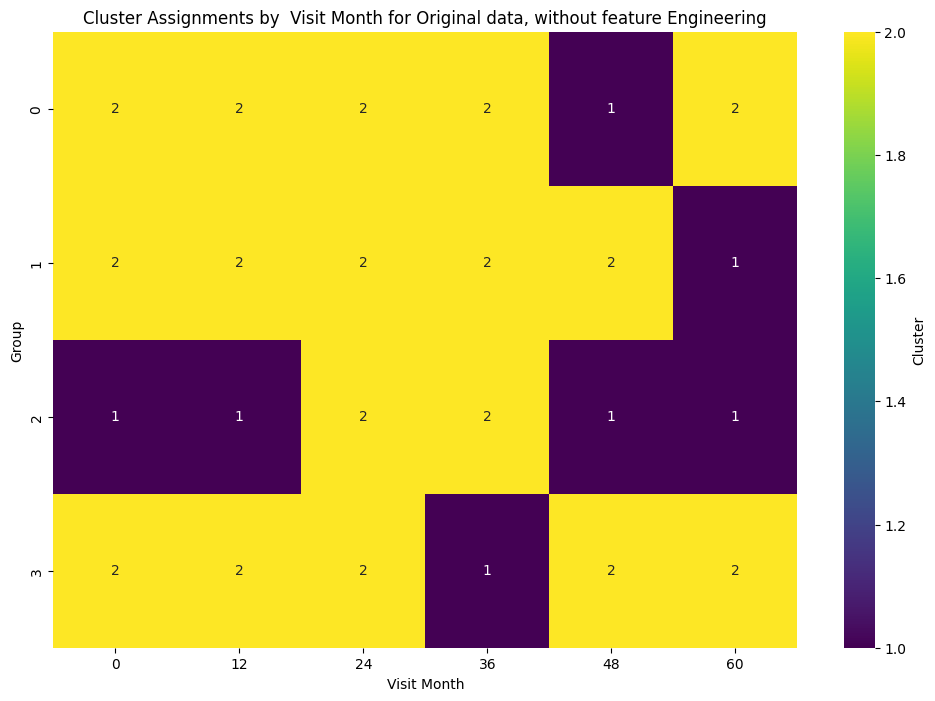

<Figure size 1200x800 with 0 Axes>

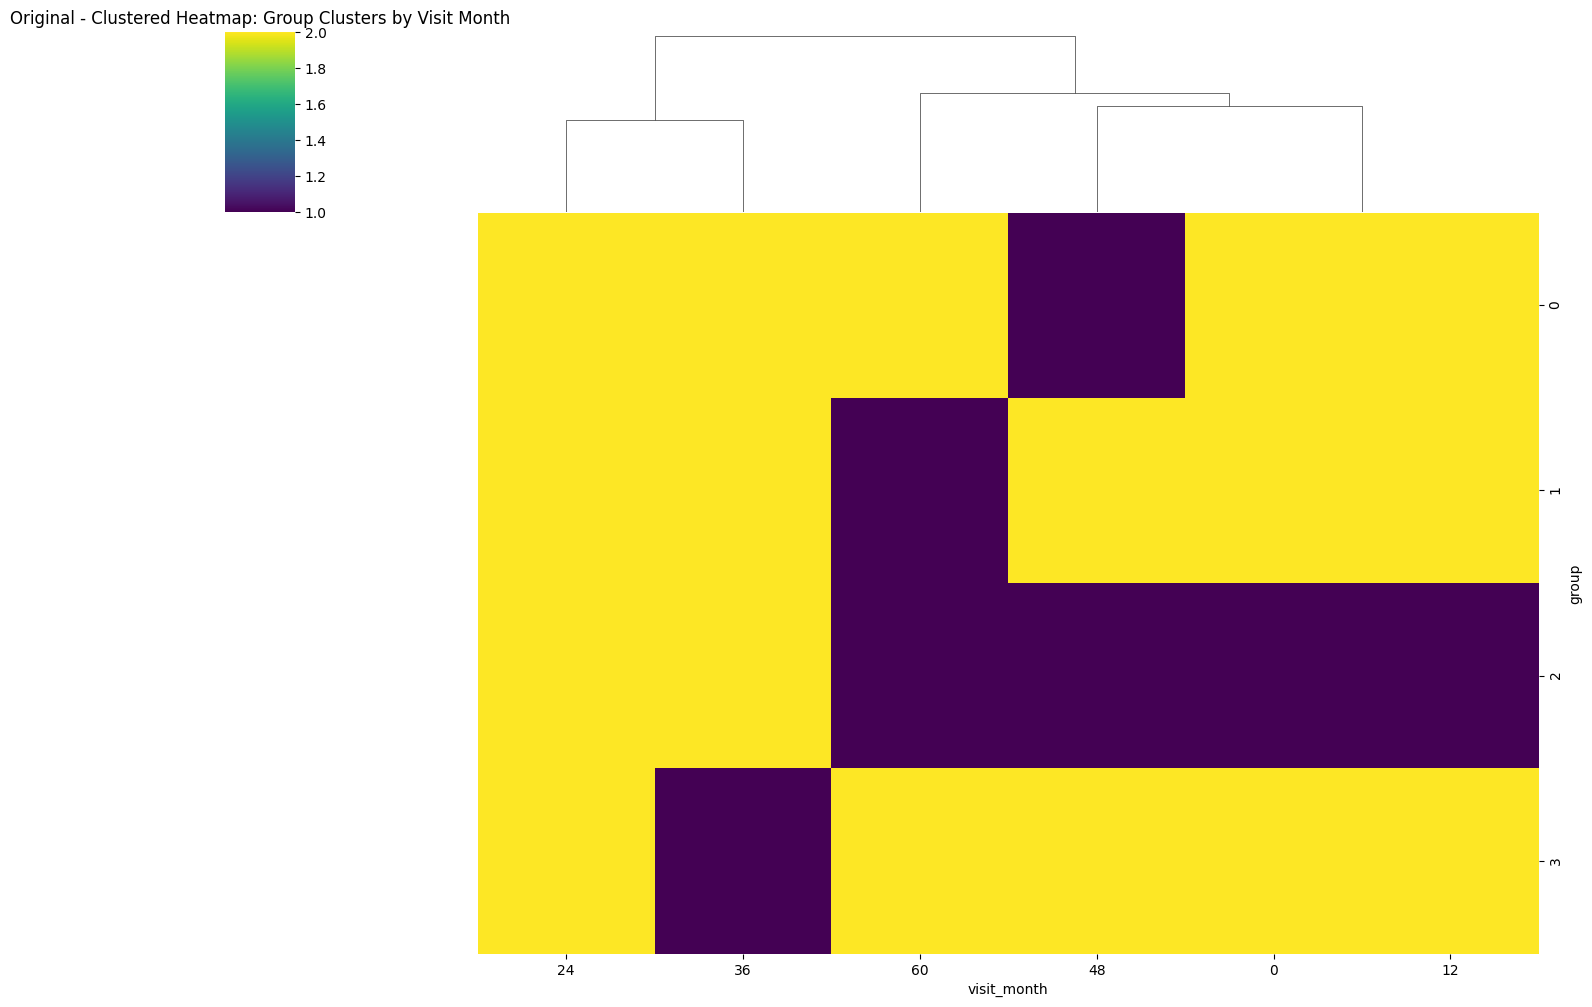

'\nlinked = linkage(data, method=\'ward\')  # You can use other methods such as \'single\', \'complete\', etc.\nlabels = fcluster(linked, t=2, criterion=\'maxclust\')  # t=2 specifies two clusters, adjust as needed\nsilhouette = silhouette_score(data, labels)\nkss=silhouette\ndata[\'state\'] = labels\n\nheatmap_data_best = data.pivot_table(index=\'patient_id\', columns=\'visit_month\', values=\'state\', aggfunc=\'first\')#mode_func)\n\n# Step 5: Generate the hierarchical clustering\n\nlinked_rows_best = linkage(heatmap_data_best, \'ward\')  # Clustering patients (rows)\nlinked_cols_best = linkage(heatmap_data_best.T, \'ward\')  # Clustering visit months (columns)\n\n# Step 6: Plot the heatmap with hierarchical clustering\nplt.figure(figsize=(12, 8))\nsns.clustermap(heatmap_data_best, annot=True, row_cluster=False, col_linkage=linked_cols_best, cmap="viridis", figsize=(14, 10))\nplt.title("Optimized Clustering: Patient Clusters by Visit Month")\nplt.show()\n'

In [ ]:
# Step 4: Pivot the data to create a matrix for the heatmap
data=df1.copy(deep=True)

#data=data[data['patient_id'].isin(best_kept_patients_groups[0])]

from scipy import stats

# Define a custom function to calculate the mode
def mode_func(x):
    """Calculates the mode (most frequent value) of a series.
    If there are multiple modes, returns the first one.
    """
    mode_result = stats.mode(x)

    # Check if mode_result.mode is a scalar
    if np.isscalar(mode_result.mode):
        return mode_result.mode  # Return the scalar value directly
    else:
        return mode_result.mode[0]


# Initialize the 'group' column with a default value (e.g., -1)
data['group'] = -1

# Iterate through the groups and assign the group number using .loc
for i, group_patients in enumerate(best_kept_patients_groups):
    data.loc[data['patient_id'].isin(group_patients), 'group'] = i

print(data.head())
#for i in range (2,20):
df_=data.drop(columns=['patient_id','visit_month'])
kpca = KernelPCA(n_components=1, kernel='poly')
X_kpca = kpca.fit_transform(df_)
linked = linkage(df_, method='ward')
labels = fcluster(linked, t=2, criterion='maxclust')
silhouette = silhouette_score(X_kpca, labels)
print(" The score for clustering --------->",silhouette)

data['clusters'] = labels

df_sorted_org = data.sort_values(by=['patient_id', 'visit_month','group'])
heatmap_data = df_sorted_org.pivot_table(index='group', columns='visit_month', values='clusters', aggfunc=mode_func)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by  Visit Month for Original data, without feature Engineering")
plt.ylabel('Group')
plt.xlabel('Visit Month')
plt.show()

plt.figure(figsize=(12, 8))
linked_cols_o = linkage(heatmap_data.T, 'ward')
sns.clustermap(heatmap_data, col_linkage=linked_cols_o, row_cluster=False, cmap="viridis", figsize=(14, 10))
plt.title("Original - Clustered Heatmap: Group Clusters by Visit Month")
plt.show()




Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0       0.648667   
1              4172           12       0.816789   
2              4172           24       0.653723   
3              4172           36       0.502885   
4              4172           48       0.461587   
..              ...          ...            ...   
139           63889           12       0.709221   
140           63889           24       0.078740   
141           63889           36       0.747495   
142           63889           48       0.061902   
143           63889           60       0.650348   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                0.459253   
1                                                0.595396   
2                                                0.687922   
3                                                0.516553   
4                                                0.928682   
..                   

<ipython-input-283-ebaffe135405>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df['Original clusters'] = labels


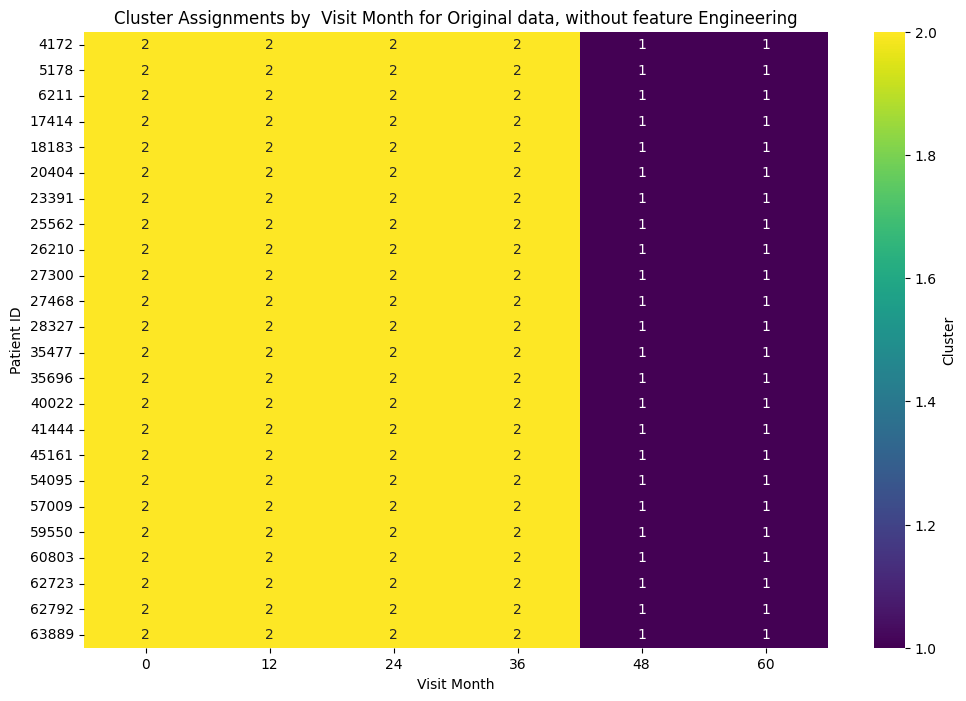

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

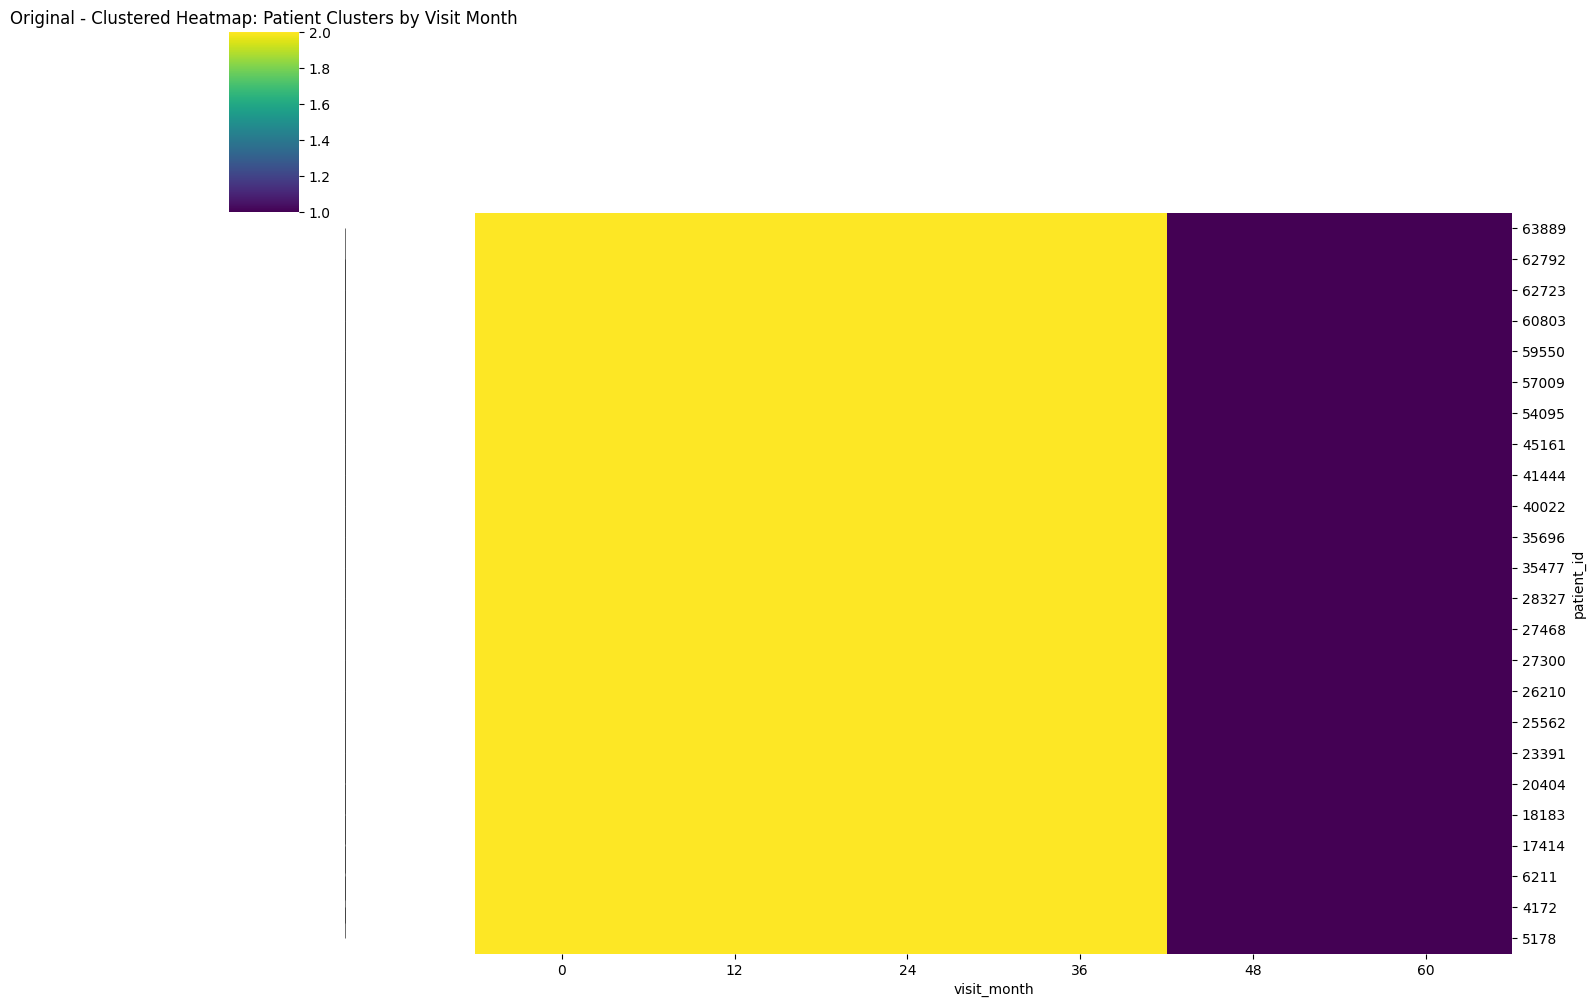

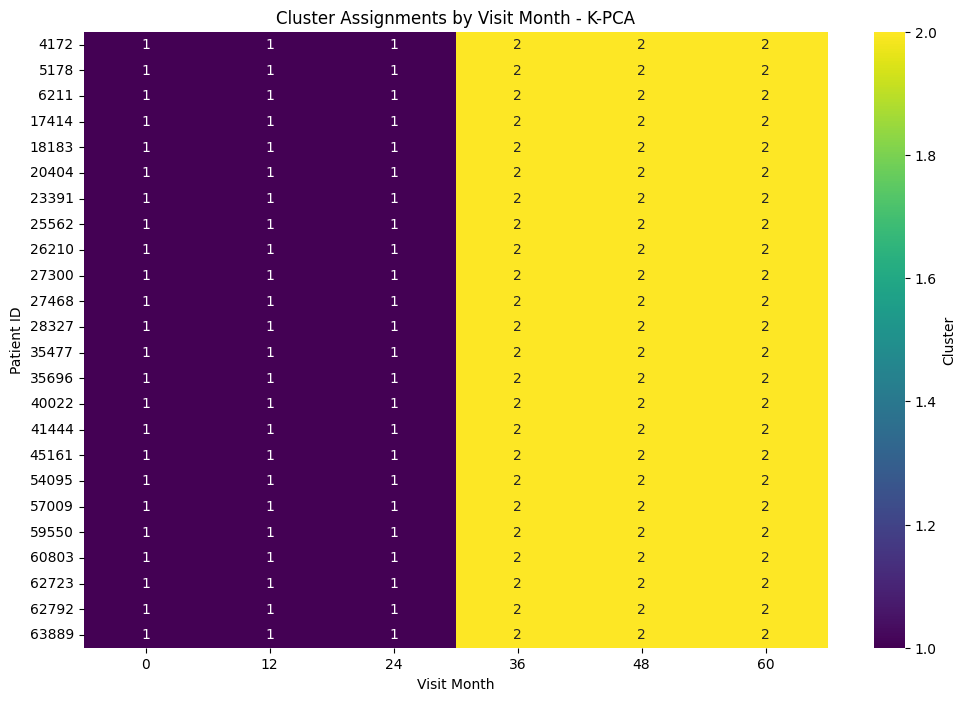

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

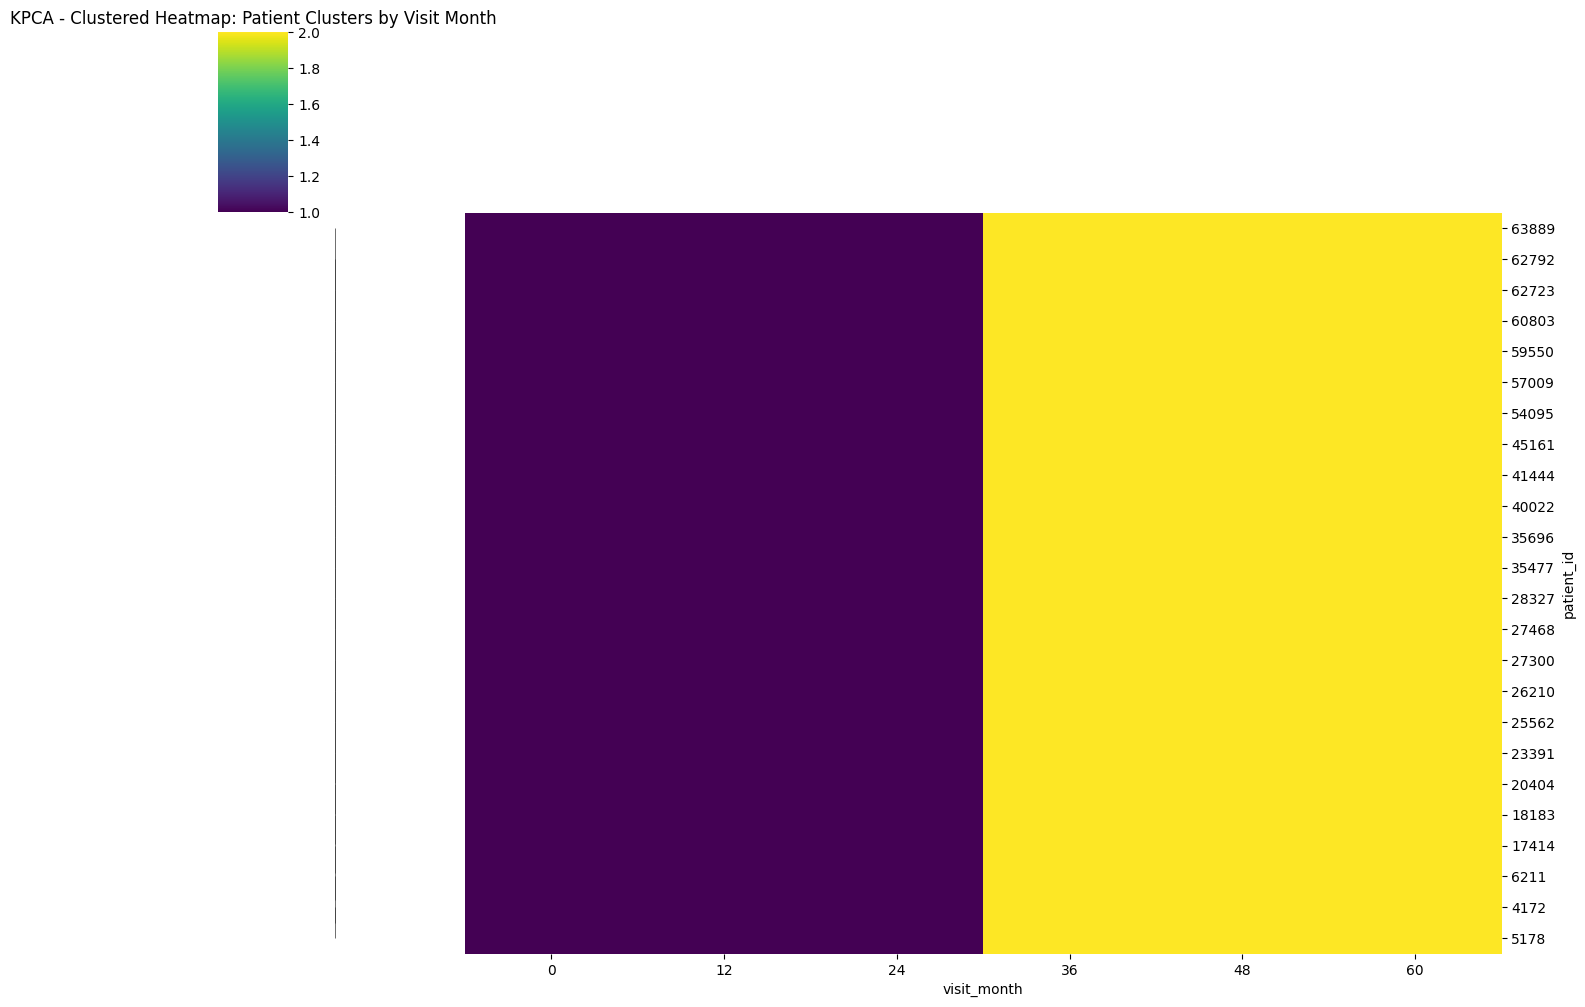

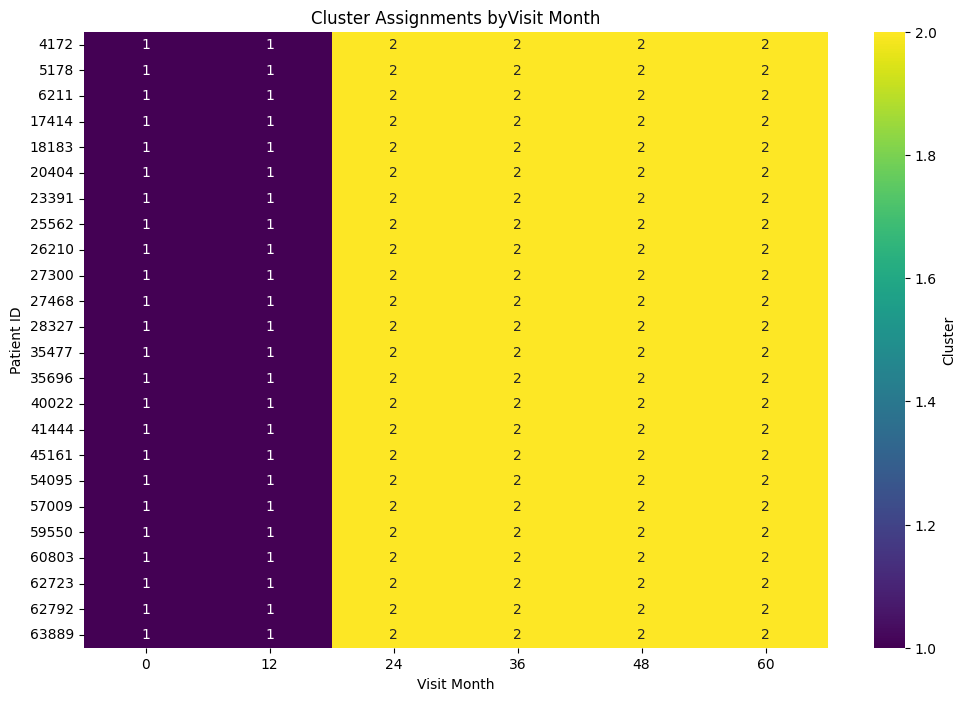

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

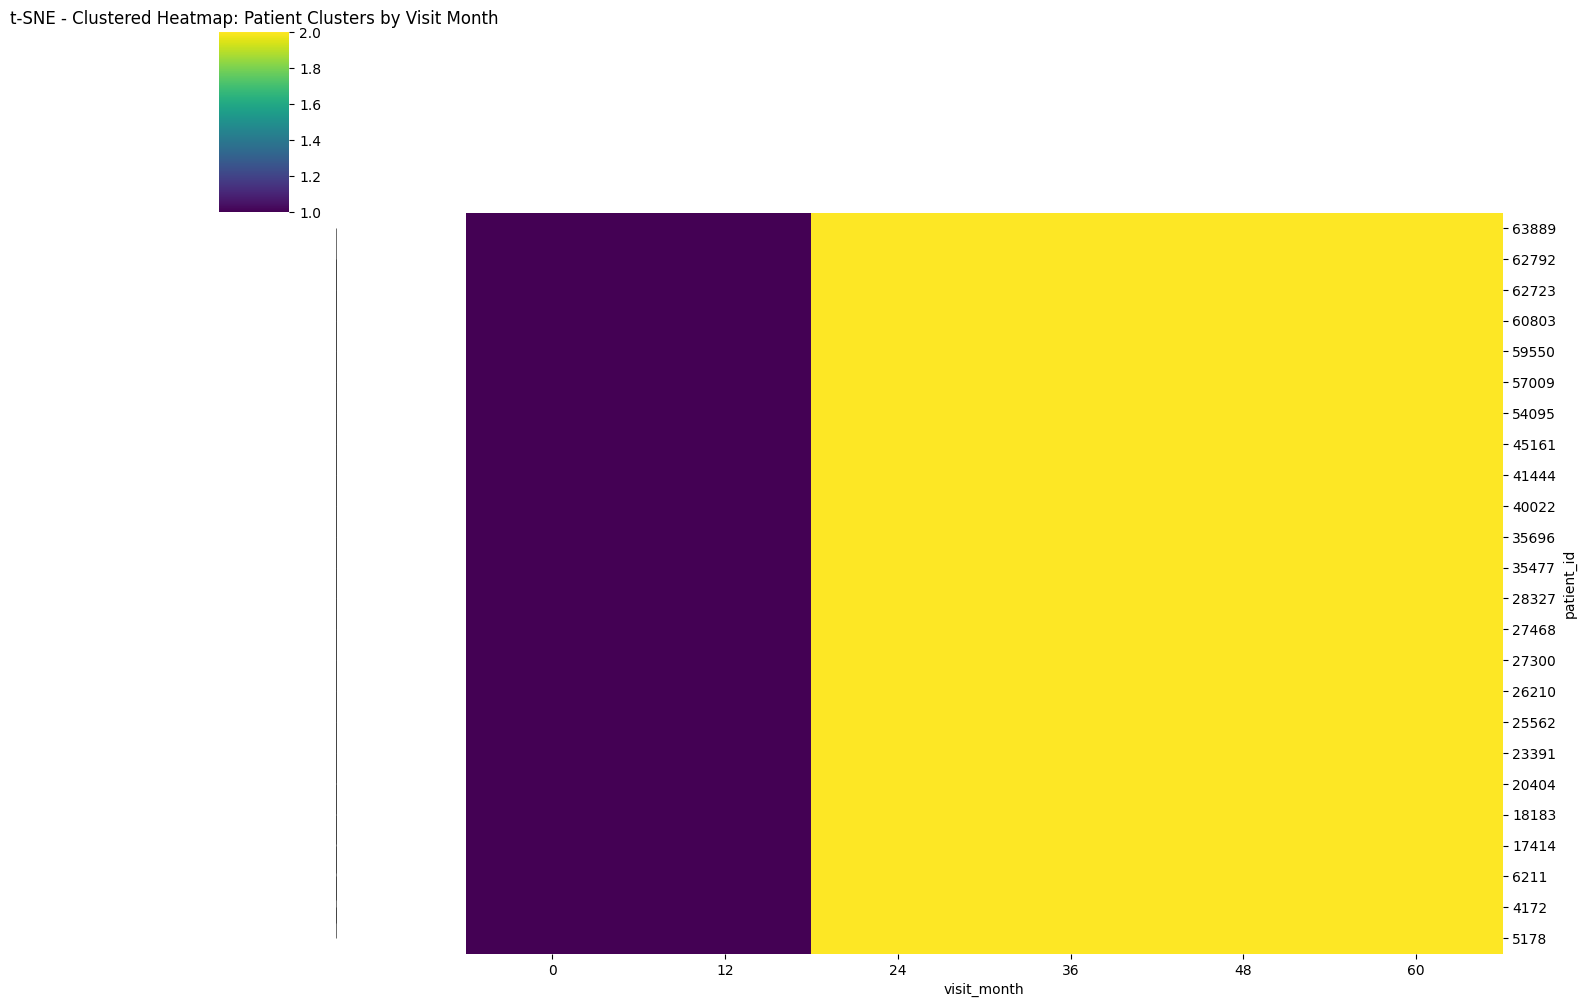

Silhouette Score  Agglomerative clusters: 0.4994
Silhouette Score for KPCA Agglomerative clusters: 0.6019
Silhouette Score for t-SNE Agglomerative clusterss: 0.6344


'\n\n\'-----------linkage cluster label--------------\'\nfrom scipy.cluster.hierarchy import linkage, fcluster\n\n# Step 2: Get the cluster labels using fcluster\n# You can choose the desired number of clusters (e.g., n_clusters=2)\nn_clusters = 2  # Set the number of clusters, adjust as necessary\ncluster_labels = fcluster(linked_cols_k, 2, criterion=\'maxclust\')\n\n# Step 3: Add the cluster labels to the original DataFrame\n# Since we clustered the columns, assign the cluster labels to the \'visit_month\' axis\n# The order of columns in heatmap_data is aligned with the linkage matrix, so we can assign cluster labels\nmonth_to_cluster = dict(zip(heatmap_data.columns, cluster_labels))\n\n# Adding cluster labels to the original DataFrame\n# Assuming df_sorted is your original DataFrame containing \'patient_id\' and \'visit_month\'\ndata_sorted=df_sorted_kpca\n# Map the cluster labels to the \'visit_month\' column in df_sorted\ndata_sorted[\'cluster_label\'] = data_sorted[\'visit_month\

In [ ]:
'Cluster original df before and after encoding it using KPCA & t-SNE - All togather'
'Plot original clusters'
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

clust=2
d=1


pivot_df= df1.copy(deep=True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 1. Select columns to scale (all columns except the first two)
columns_to_scale = pivot_df.columns[2:]  # All columns except 'patient_id' and 'visit_month'
# 2. Apply Min-Max Scaling to selected columns
scaler = MinMaxScaler()#StandardScaler()#
pivot_df[columns_to_scale] = scaler.fit_transform(pivot_df[columns_to_scale])
print(pivot_df)
df1=pivot_df.copy(deep=True)

#patients = [4172, 17414, 18183, 23391, 26210, 27468, 28327, 35696, 40022, 41444, 54095, 57009, 60803, 62723]
#patients = [4172, 6211, 17414, 18183, 20404, 23391, 27468, 35477, 41444, 54095, 60803, 63889]#step-wise
#patients = [26210, 27300, 62792, 45161, 35696, 57009, 40022, 5178, 59550]#step-wise
#patients = [62723, 28327]#step-wise
#patients= [6211, 25562, 27300, 35696, 45161, 60803, 63889] #lstm group 1
#patients=[4172, 5178, 17414, 18183, 20404, 23391, 26210, 27468, 28327, 35477, 40022, 41444, 54095, 57009, 59550, 62723, 62792] #lstm group 2
#pivot_df= pivot_df[~pivot_df['patient_id'].isin(patients_with_medication)]



#Cluster - original features
data=pivot_df.drop(columns=['patient_id'])
linked = linkage(data, method='ward')  # You can use other methods such as 'single', 'complete', etc.
labels = fcluster(linked, t=clust, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
silhouette = silhouette_score(data, labels)
oss=silhouette
pivot_df['Original clusters'] = labels

df_sorted_org = pivot_df.sort_values(by=['patient_id', 'visit_month'])
heatmap_data = df_sorted_org.pivot_table(index='patient_id', columns='visit_month', values='Original clusters', aggfunc='first')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by  Visit Month for Original data, without feature Engineering")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

plt.figure(figsize=(12, 8))
linked_cols_o = linkage(heatmap_data.T, 'ward')
linked_cols_r = linkage(heatmap_data, 'ward')
sns.clustermap(heatmap_data, col_cluster=False, row_linkage=linked_cols_r, cmap="viridis", figsize=(14, 10))
plt.title("Original - Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

#cluster - K-PCA

pivot_df= df1.copy(deep=True)
#pivot_df= pivot_df[pivot_df['patient_id'].isin(patients_with_medication)]

kpca = KernelPCA(n_components=d, kernel='poly')
X_kpca = kpca.fit_transform(pivot_df.drop(columns=['patient_id']))
linked = linkage(X_kpca, method='ward')  # You can use other methods such as 'single', 'complete', etc.
labels = fcluster(linked, t=clust, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
silhouette = silhouette_score(X_kpca, labels)
kss=silhouette
pivot_df['KPCA clusters'] = labels

df_sorted_kpca = pivot_df.sort_values(by=['patient_id', 'visit_month'])
heatmap_data = df_sorted_kpca.pivot_table(index='patient_id', columns='visit_month', values='KPCA clusters', aggfunc='first')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Visit Month - K-PCA")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

plt.figure(figsize=(12, 8))
linked_cols_k = linkage(heatmap_data.T, 'ward')
linked_cols_r = linkage(heatmap_data, 'ward')
sns.clustermap(heatmap_data, col_cluster=False, row_linkage=linked_cols_r, cmap="viridis", figsize=(14, 10))
plt.title("KPCA - Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()


#cluster - t-SNE

pivot_df= df1.copy(deep=True)
#pivot_df= pivot_df[pivot_df['patient_id'].isin(patients_with_medication)]

n_samples = pivot_df.drop(columns=['patient_id']).shape[0]
perplexity_value = min(30, n_samples - 1)
tsne = TSNE(n_components=d, random_state=30, perplexity=perplexity_value)
X_tsne = tsne.fit_transform(pivot_df.drop(columns=['patient_id']))
linked = linkage(X_tsne, method='ward')  # You can use other methods such as 'single', 'complete', etc.
labels = fcluster(linked, t=clust, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
silhouette = silhouette_score(X_tsne, labels)
tss=silhouette
pivot_df['t-SNE clusters'] = labels

df_sorted_tsne = pivot_df.sort_values(by=['patient_id', 'visit_month'])
heatmap_data = df_sorted_tsne.pivot_table(index='patient_id', columns='visit_month', values='t-SNE clusters', aggfunc='first')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments byVisit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()


plt.figure(figsize=(12, 8))
linked_cols_t = linkage(heatmap_data.T, 'ward')
linked_cols_r = linkage(heatmap_data, 'ward')
sns.clustermap(heatmap_data, col_cluster=False, row_linkage=linked_cols_r, cmap="viridis", figsize=(14, 10))
plt.title("t-SNE - Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()


#scores:
print(f"Silhouette Score  Agglomerative clusters: {oss:.4f}")
print(f"Silhouette Score for KPCA Agglomerative clusters: {kss:.4f}")
print(f"Silhouette Score for t-SNE Agglomerative clusterss: {tss:.4f}")





Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5942
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4652
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3083
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1813
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4081
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3211
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2903
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3140
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3430
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2140
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4122
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2442
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1990
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2918
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

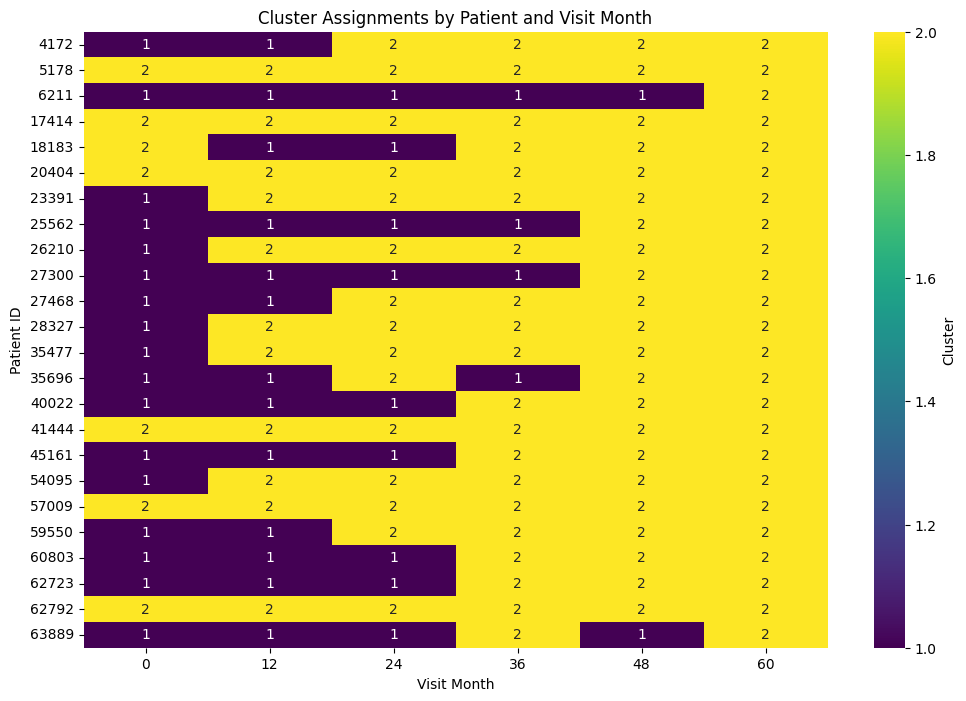

<Figure size 1200x800 with 0 Axes>

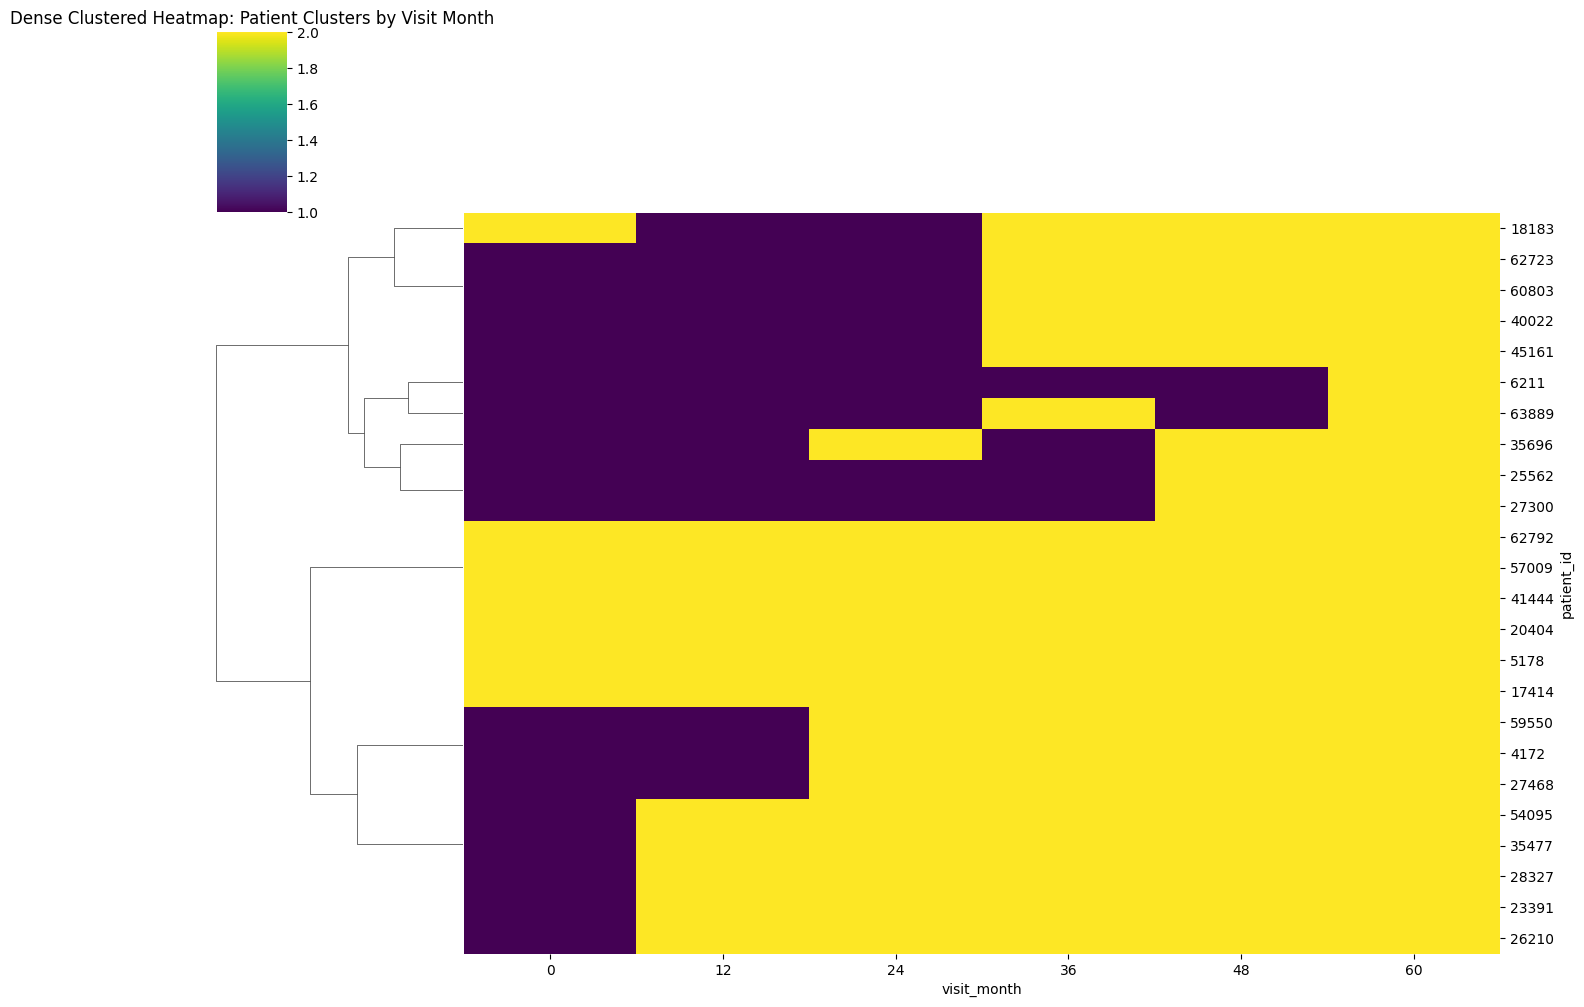

'Silhouette Score for components=3, Agglomerative clusters=2: 0.5443'

In [ ]:
'Encode peptides types features by month using Dense autoencoder'
'Scale first'

pivot_df= df1.copy(deep=True)
'''
#pivot_df= pivot_df[pivot_df['patient_id'].isin(patients)]
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 1. Select columns to scale (all columns except the first two)
columns_to_scale = pivot_df.columns[2:]  # All columns except 'patient_id' and 'visit_month'
# 2. Apply Min-Max Scaling to selected columns
scaler = MinMaxScaler()#StandardScaler()#
pivot_df[columns_to_scale] = scaler.fit_transform(pivot_df[columns_to_scale])
print(pivot_df)
'''
#df= pivot_df.copy(deep=True)
#patients = [4172, 5178, 6211, 17414, 18183, 20404, 23391, 25562, 26210, 27300, 28327, 35477, 35696, 40022, 45161, 54095, 57009, 59550, 60803, 62723, 62792, 63889]
#pivot_df= pivot_df[~pivot_df['patient_id'].isin(patients_with_medication)]

from keras.layers import Dropout
from keras.regularizers import l2
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from seaborn import clustermap
import seaborn as sns

data=pivot_df.drop(columns=['patient_id'])
input_dim = data.shape[1]
encoding_dim = 1 # Set the number of encoding dimensions (you can adjust this) 4 (0.70, dropout0.2)
# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.02))(input_layer)

#dropout for regularization
#encoded = Dropout(0.2)(encoded)  # 20% dropout

# Decoder layers
decoded = Dense(input_dim, activation='sigmoid')(encoded)
# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# Encoder model (for getting the encoded representation)
encoder = Model(inputs=input_layer, outputs=encoded)
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Train the autoencoder
autoencoder.fit(data, data, epochs=50, batch_size=1, shuffle=True)
# Get the encoded representations
X_autoencoded = encoder.predict(data)
linked = linkage(X_autoencoded, method='ward')  # You can use other methods such as 'single', 'complete', etc.
labels = fcluster(linked, t=clust, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
silhouette = silhouette_score(X_autoencoded, labels)
if len(np.unique(labels)) > 1:
    silhouette = silhouette_score(X_autoencoded, labels)
    print(f"Silhouette Score for components={1}, Agglomerative clusters={2}: {silhouette:.4f}")
else:
    print("Only one cluster found. Adjust clustering parameters to ensure at least 2 clusters.")
    # Consider increasing the number of clusters, changing the clustering algorithm,
    # or adjusting other parameters like the linkage method.

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['Autoencoder clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='Autoencoder clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)
linked_rows= linkage(heatmap_data, 'ward')  # Clustering visit months (columns)


# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_cluster=False, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Dense Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

'Silhouette Score for components=3, Agglomerative clusters=2: 0.5443'

In [ ]:
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
pivot_df=df1.copy(deep=True)
patients=[26210, 27300, 62792, 45161, 35696, 57009, 40022, 5178, 59550]
pivot_df= pivot_df[~pivot_df['patient_id'].isin(patients)]
print(pivot_df)
# 2. Calculate Variability (using standard deviation here)
variability_columns = pivot_df.columns[2:]

# Calculate standard deviation for each peptide across all patients and visit months
variability_df = pivot_df[variability_columns].std()
# 3. Statistical Test (ANOVA)
significant_peptides = []
for peptide in variability_df.index:  # Assuming variability_df is calculated on the original df
    # Create a formula for the ANOVA model using the 'Q' function
    formula = f"Q('{peptide}') ~ C(visit_month)"
    # Q('{peptide}') ensures that the peptide name is treated as a column name

    # Fit the ANOVA model using the original DataFrame ('df', 'filtered_df', or 'filtered_')
    model = sm.ols(formula, data=pivot_df).fit()  # Or data=filtered_df or data=filtered_

    # Get ANOVA results
    anova_results = anova_lm(model)

    # Check for significance (p-value < 0.05)
    if anova_results['PR(>F)'][0] < 0.05:
        significant_peptides.append(peptide)

# 4. Print Significant Peptides
print("Peptides with significant variability over time:")
print(significant_peptides)



Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
..              ...          ...            ...   
139           63889           12     11685200.0   
140           63889           24      1297330.0   
141           63889           36     12315800.0   
142           63889           48      1019910.0   
143           63889           60     10715200.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                                 68732.9   
3                                                 51610.8   
4                                                 92788.1   
..                   

<ipython-input-102-b0d0e6c643f1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
<ipython-input-102-b0d0e6c643f1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
<ipython-input-102-b0d0e6c643f1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:
<ipython-input-102-b0d0e6c643f1>:27: FutureWarning: Series.__getitem__ tr

Peptides with significant variability over time:
['LC(UniMod_4)TVATLR', 'VTIPTDLIASSGDIIK']


<ipython-input-102-b0d0e6c643f1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results['PR(>F)'][0] < 0.05:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - loss: 0.0439 - val_loss: 0.0706
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0427 - val_loss: 0.0703
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0464 - val_loss: 0.0700
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0409 - val_loss: 0.0681
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0426 - val_loss: 0.0664
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0361 - val_loss: 0.0654
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0349 - val_loss: 0.0645
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0328 - val_loss: 0.0639
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0316 - val_loss: 0.0640
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0351 - val_loss: 0.0631
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0344 - val_loss: 0.0631
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0

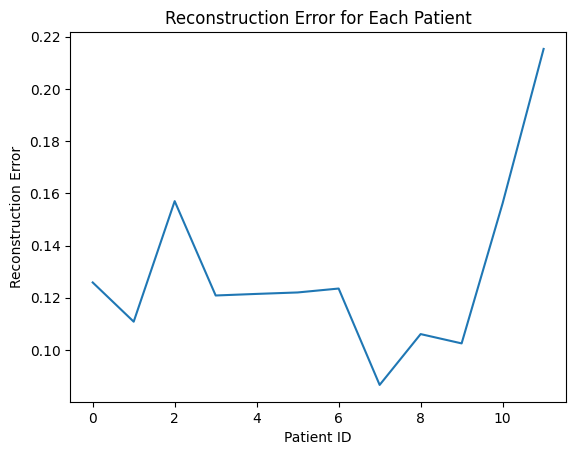

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Silhouette Score : 0.4749


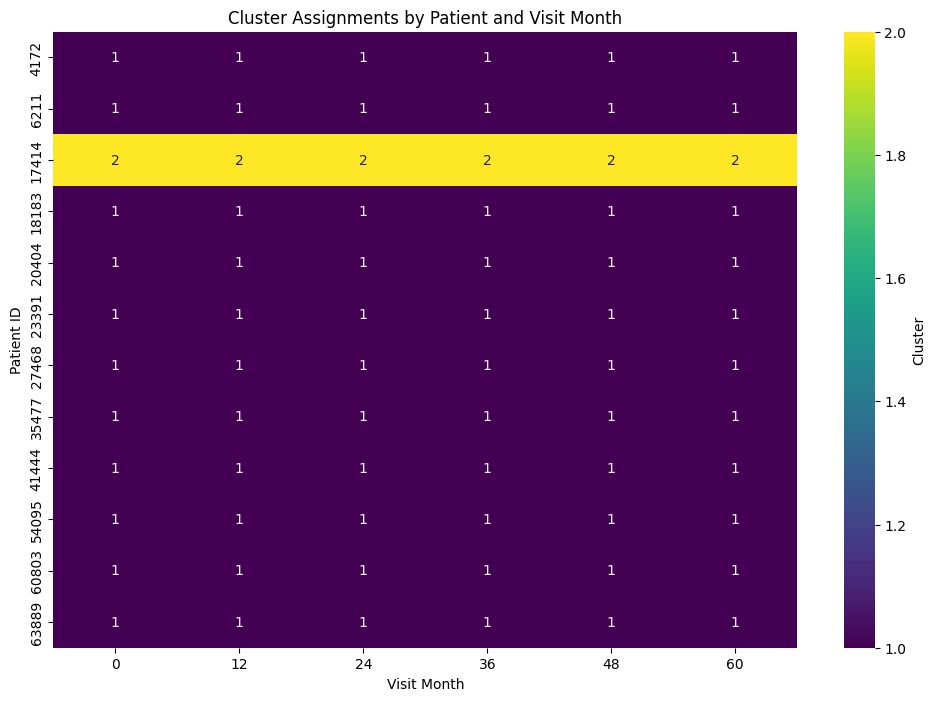

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

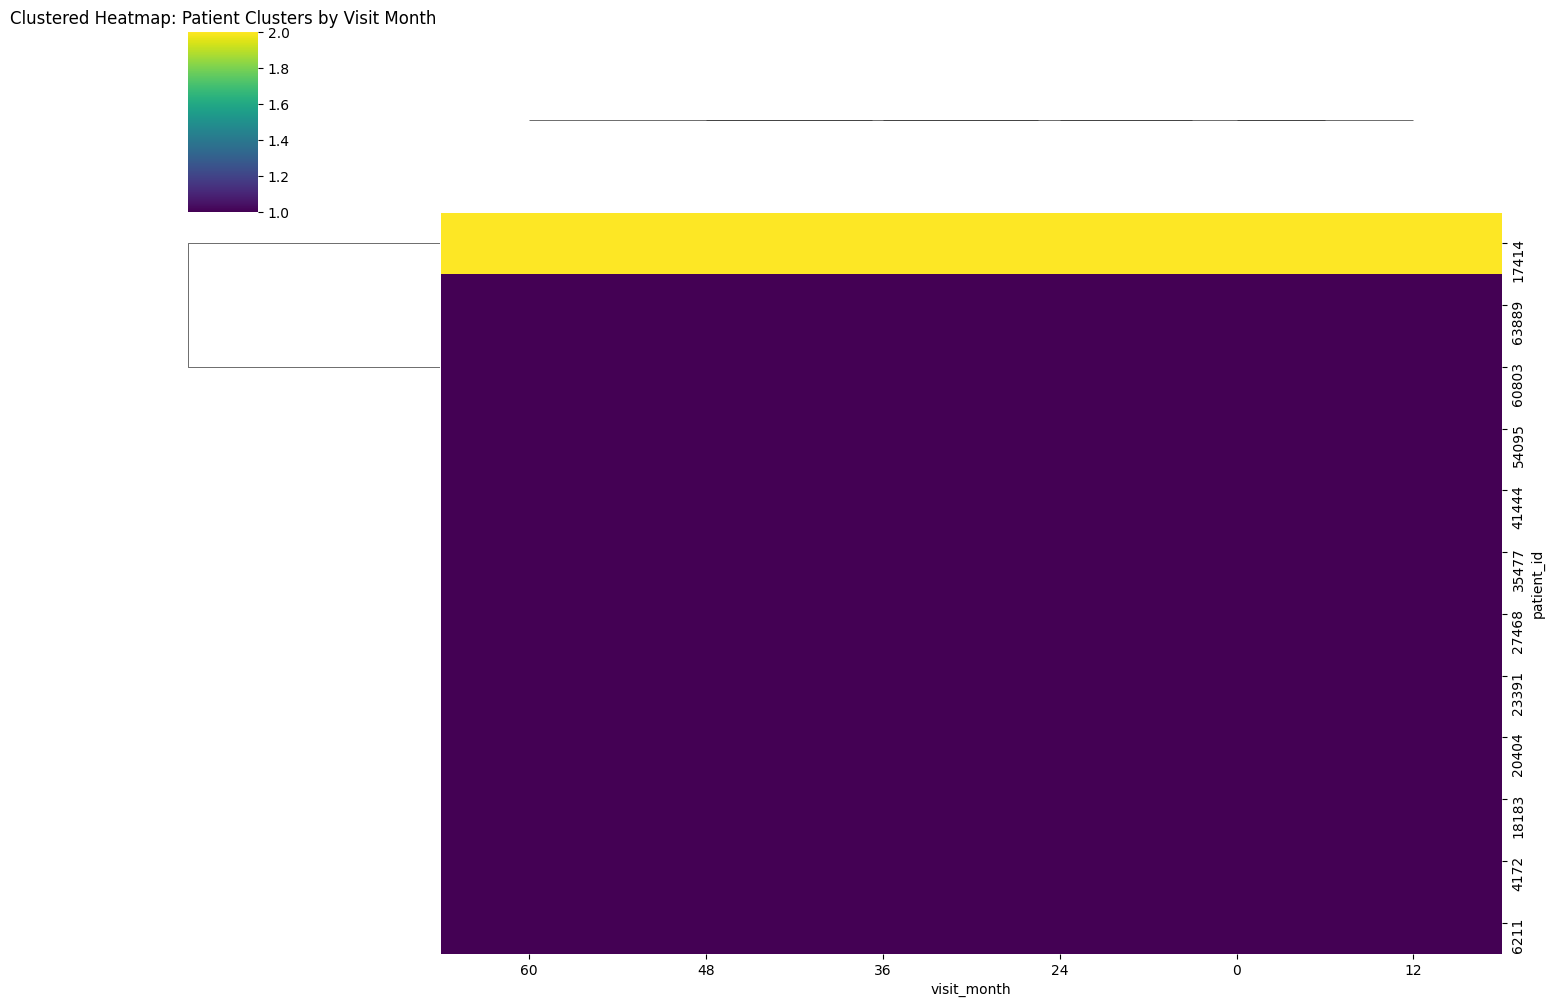

In [ ]:
'lstm autoencoder to find patients strata'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

pivot_df=df1.copy(deep=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 1. Select columns to scale (all columns except the first two)
columns_to_scale = pivot_df.columns[2:]  # All columns except 'patient_id' and 'visit_month'
# 2. Apply Min-Max Scaling to selected columns
scaler = MinMaxScaler()#StandardScaler()#
pivot_df[columns_to_scale] = scaler.fit_transform(pivot_df[columns_to_scale])

#patients = [4172, 5178, 6211, 17414, 18183, 20404, 23391, 25562, 26210, 27300, 28327, 35477, 35696, 40022, 45161, 54095, 57009, 59550, 60803, 62723, 62792, 63889]
pivot_df= pivot_df[pivot_df['patient_id'].isin(patients)]

peptide_columns = pivot_df.columns[2:]

# 1. Group data by patient_id
grouped = pivot_df.groupby('patient_id')

# 2. Create a list to store patient data sequences
patient_sequences = []

# 3. Iterate through each patient's data
for patient_id, group in grouped:
    # Select only the peptide abundance columns for this patient
    patient_data = group[peptide_columns].values

    # Append the patient's data to the list of sequences
    patient_sequences.append(patient_data)

# 4. Pad sequences to have the same length (if necessary)
# Find the maximum sequence length
max_len = max(len(seq) for seq in patient_sequences)

# Pad sequences with zeros to make them equal length
padded_sequences = [
    np.pad(seq, ((0, max_len - len(seq)), (0, 0)), 'constant')
    for seq in patient_sequences
]

# 5. Convert to a NumPy array for the LSTM
X = np.array(padded_sequences)

# Define LSTM Autoencoder Model
model = Sequential()

# Encoder
model.add(LSTM(32, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) # Return sequences for TimeDistributed layer
model.add(LSTM(16, activation='relu', return_sequences=False)) # Reduce dimensionality for encoding
model.add(RepeatVector(X.shape[1]))  # Repeat for decoding

# Decoder
model.add(LSTM(16, activation='relu', return_sequences=True)) # Increase dimensionality for decoding
model.add(LSTM(32, activation='relu', return_sequences=True)) # Match encoder output shape
model.add(TimeDistributed(Dense(X.shape[2], activation='sigmoid'))) # Apply Dense layer to each time step


model.compile(optimizer='adam', loss='mse')

# Fit the Autoencoder
model.fit(X, X, epochs=50, batch_size=1, validation_split=0.1)

# Evaluate the model
reconstructed = model.predict(X)
loss = model.evaluate(X, X)
print(f"Reconstruction Loss: {loss:.4f}")

# Visualize reconstruction error
reconstruction_error = np.mean(np.abs(reconstructed - X), axis=(1, 2))
plt.plot(reconstruction_error)
plt.title('Reconstruction Error for Each Patient')
plt.xlabel('Patient ID')
plt.ylabel('Reconstruction Error')
plt.show()



#del pivot_df['LSTM Autoencoder clusters']
# Get the encoded representations
X_autoencoded = model.predict(X)

# Reshape X_autoencoded to 2D: (num_patients, num_features)
# Method 1: Flatten along the sequence dimension (may lose temporal information)
X_autoencoded_2d = X_autoencoded.reshape(X_autoencoded.shape[0], -1)

# Method 2: Average or take the last value along the sequence dimension
# (may be more suitable depending on your context)
# X_autoencoded_2d = np.mean(X_autoencoded, axis=1)  # Average across sequence
# X_autoencoded_2d = X_autoencoded[:, -1, :]  # Take the last value in sequence

linked = linkage(X_autoencoded_2d, method='ward')  # You can use other methods such as 'single', 'complete', etc.
labels = fcluster(linked, t=2, criterion='maxclust')  # t=2 specifies two clusters, adjust as needed
silhouette = silhouette_score(X_autoencoded_2d, labels)
print(f"Silhouette Score : {silhouette:.4f}")

# Get unique patient IDs from pivot_df
patient_ids = pivot_df['patient_id'].unique()

# Create a DataFrame to store patient-level cluster assignments
patient_clusters_df = pd.DataFrame({'patient_id': patient_ids, 'LSTM Autoencoder clusters': labels})

# Merge the cluster assignments into pivot_df based on patient_id
pivot_df = pd.merge(pivot_df, patient_clusters_df, on='patient_id', how='left')


# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='LSTM Autoencoder clusters', aggfunc='first')

# Step 6: Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

In [ ]:
'Feature elimination by stepwise clustering'
# Import necessary libraries
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from sklearn.manifold import TSNE

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2

# Assuming pivot_df is already loaded
pivot_df = df1.copy(deep=True)



def perform_clustering_and_score(pivot_df):
    '''
    Perform clustering on the given dataframe and calculate the silhouette score.

    Parameters:
    pivot_df (pd.DataFrame): The dataframe containing patient data.

    Returns:
    tuple: A tuple containing the silhouette score, cluster labels, and None (placeholder for KPCA).
    '''

    # Step 1: Perform Agglomerative Clustering with
    #A) original features
    # Step 1: Perform Agglomerative Clustering with
    #A) original features

    '''
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(data)
    silhouette = silhouette_score(data, labels)
    '''

    # Step 1: Apply Agglomerative Clustering on the cleaned data
    # Drop the non-feature columns before clustering
    data = pivot_df.drop(columns=['patient_id', 'visit_month'])

    # Step 2: Apply Agglomerative Clustering on the cleaned data
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(data)
    silhouette = silhouette_score(data, labels)



    #B) KPCA component
    '''
    data=pivot_df.drop(columns=['patient_id', 'visit_month'])
    kpca = KernelPCA(n_components=1, kernel='rbf')  # Use rbf kernel (you can try other kernels too), also poly
    X_kpca = kpca.fit_transform(data)
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(X_kpca)
    silhouette = silhouette_score(X_kpca, labels)
    '''
    '''
    #C)t-SNE

    data=pivot_df.drop(columns=['patient_id', 'visit_month'])
    # Get the number of samples in the data
    n_samples = pivot_df.drop(columns=['patient_id','visit_month']).shape[0]
    # Set perplexity to be less than n_samples
    perplexity_value = min(30, n_samples - 1)
    tsne = TSNE(n_components=1, random_state=42, perplexity=perplexity_value)
    X_kpca = tsne.fit_transform(data)
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(X_kpca)
    silhouette = silhouette_score(X_kpca, labels)
    '''
    #D)
    '''
    data=pivot_df.drop(columns=['patient_id','visit_month'])
    input_dim = data.shape[1]
    encoding_dim = 1 # Set the number of encoding dimensions (you can adjust this) 4 (0.70, dropout0.2)
    # Input layer
    input_layer = Input(shape=(input_dim,))
    # Encoder layers
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.02))(input_layer)
    #dropout for regularization
    #encoded = Dropout(0.2)(encoded)  # 20% dropout
    # Decoder layers
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    # Encoder model (for getting the encoded representation)
    encoder = Model(inputs=input_layer, outputs=encoded)
    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    # Train the autoencoder
    autoencoder.fit(data, data, epochs=50, batch_size=1, shuffle=True)
    # Get the encoded representations
    X_autoencoded = encoder.predict(data)
    agglomerative = AgglomerativeClustering(n_clusters=2)
    labels = agglomerative.fit_predict(X_autoencoded)
    silhouette = silhouette_score(data, labels)
    '''
    # Calculate silhouette score
    return silhouette, labels, data#X_kpca  # Return None for X_kpca as it is not calculated


def stepwise_clustering(score,pivot_df):
    '''
    Perform stepwise clustering by iteratively removing patients and finding the best clustering score.

    Parameters:
    pivot_df (pd.DataFrame): The dataframe containing patient data.

    Returns:
    list: A list of the best remaining patient IDs after stepwise removal.
    '''
    all_features_ids = pivot_df.columns[2:]
    best_score = -1
    remaining_features = all_features_ids.copy()
    best_features = remaining_features.copy()
    max_iter = len(all_features_ids) - (len(all_features_ids) -3)  # Calculate max_iter using the length of the set of unique patient IDs

    # Loop through each iteration and removing one patient at a time
    removed_features = []
    thebest = -1
    last = score
    pd = pivot_df[['patient_id', 'visit_month'] + remaining_features.tolist()]
    for _ in range(max_iter):  # We perform up to max_iter iterations (i.e., until only 2 patients left)
        print(remaining_features)
        print(last)
        low_score_for_iteration = 1
        bad_feature_to_remove = None
        # Test removing each patient one by one
        for feature in remaining_features:
            temp_df = pd.drop(columns=[feature])  # Change: Drop column instead of filtering
            # Perform clustering and calculate silhouette score
            score, labels, X_kpca = perform_clustering_and_score(temp_df)
            if score < low_score_for_iteration:
                low_score_for_iteration = score
                bad_feature_to_remove = feature

            if thebest < score:
                thebest = score

        # Remove the best patient found in this iteration
        remaining_features = remaining_features[remaining_features != bad_feature_to_remove]
        removed_features.append(bad_feature_to_remove)

        pd = pivot_df[['patient_id', 'visit_month'] + remaining_features.tolist()]

        if last < thebest:
            last = thebest
            best_features = remaining_features.copy()

        #print(f"Removed patient: {bad_patient_to_remove}, Score: {low_score_for_iteration:.4f}")
        print(f"Remaining features: {len(remaining_features)}")

    # After the loop, we print the best results
    print(f"Best silhouette score: {last:.4f}")
    print(f"Best features: {best_features}")

    return best_features,removed_features

# Step 1: Perform the initial clustering with all patients
score, _, _ = perform_clustering_and_score(pivot_df)
print("The clustering score without removing any feature", score, "\n")
best_kept_features,removed_features = stepwise_clustering(score,pivot_df)

# Step 2: Apply Kernel PCA and Agglomerative Clustering on the final best subset of patients
columns_to_keep = ['patient_id', 'visit_month'] + [col for col in best_kept_features if col in pivot_df.columns]
pivot_df_best = pivot_df[columns_to_keep]

silhouette, labels, X_kpca = perform_clustering_and_score(pivot_df_best)

# Step 3: Merge the clustering result with the original data for visualization
pivot_df_best['KPCA clusters'] = labels

# Step 4: Pivot the data to create a matrix for the heatmap
df_sorted_best = pivot_df_best.sort_values(by=['patient_id', 'visit_month'])
heatmap_data_best = df_sorted_best.pivot_table(index='patient_id', columns='visit_month', values='KPCA clusters', aggfunc='first')

# Step 5: Generate the hierarchical clustering

linked_rows_best = linkage(heatmap_data_best, 'ward')  # Clustering patients (rows)
linked_cols_best = linkage(heatmap_data_best.T, 'ward')  # Clustering visit months (columns)

# Step 6: Plot the heatmap with hierarchical clustering
plt.figure(figsize=(12, 8))
sns.clustermap(heatmap_data_best, row_linkage=linked_rows_best, col_linkage=linked_cols_best, cmap="viridis", figsize=(14, 10))
plt.title("Optimized Clustering: Patient Clusters by Visit Month")
plt.show()

#step 7: print each clusters patients
# Group by 'KPCA clusters' and get patient_ids for each cluster
clustered_patients = pivot_df_best.groupby('KPCA clusters')['patient_id'].apply(lambda x: list(set(x)))

# Print the unique patient_ids for each cluster
print("Unique patients in each cluster:")
for cluster_label, patient_ids in clustered_patients.items():
    print(f"Cluster {cluster_label}: {patient_ids}")


The clustering score without removing any feature 0.18018852972816157 

Index(['AADDTWEPFASGK', 'AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K',
       'AAFTEC(UniMod_4)C(UniMod_4)QAADK', 'AANEVSSADVK',
       'AATGEC(UniMod_4)TATVGKR', 'AATVGSLAGQPLQER', 'AAVYHHFISDGVR',
       'ADDKETC(UniMod_4)FAEEGK', 'ADDKETC(UniMod_4)FAEEGKK',
       'ADDLGKGGNEESTKTGNAGSR',
       ...
       'YSLTYIYTGLSK', 'YTTEIIK', 'YVGGQEHFAHLLILR',
       'YVM(UniMod_35)LPVADQDQC(UniMod_4)IR', 'YVMLPVADQDQC(UniMod_4)IR',
       'YVNKEIQNAVNGVK', 'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK',
       'YYWGGQYTWDMAK'],
      dtype='object', name='Peptide', length=968)
0.18018852972816157


KeyboardInterrupt: 

In [ ]:
pivot_df= df1.copy(deep=True)

In [ ]:
'Extract patients in each discovered cluster'
cluster_0_patients = []
cluster_1_patients = []

# Assuming 'LSTM Autoencoder clusters' is the correct column name in your heatmap_data
cluster_column_name = heatmap_data.columns[0]  # Get the name of the cluster column

# Iterate over each patient row to check if they have a consistent cluster across all visit months
for patient_id in heatmap_data.index:
    # Get the row of the patient's cluster assignments across all visit months
    clusters = heatmap_data.loc[patient_id].dropna()  # Remove NaN values
    if len(clusters) > 0 and len(set(clusters)) == 1:  # Check if there's only one unique cluster
        # If the patient belongs to cluster 0 across all months
        if clusters.iloc[0] == 1:  # Assuming cluster labels start from 1
            cluster_0_patients.append(patient_id)
        # If the patient belongs to cluster 1 across all months
        elif clusters.iloc[0] == 2:  # Assuming cluster labels start from 1
            cluster_1_patients.append(patient_id)

# Output the results
print("Patients in Cluster 0:", cluster_0_patients)
print("Patients in Cluster 1:", cluster_1_patients)
'To cluster each patients group - Cluster 1'

Patients in Cluster 0: [6211, 25562, 27300, 35696, 45161, 60803, 63889]
Patients in Cluster 1: [4172, 5178, 17414, 18183, 20404, 23391, 26210, 28327, 35477, 40022, 54095, 57009, 59550, 62723, 62792]


'To cluster each patients group - Cluster 1'

<Axes: xlabel='Peptide', ylabel='Peptide'>

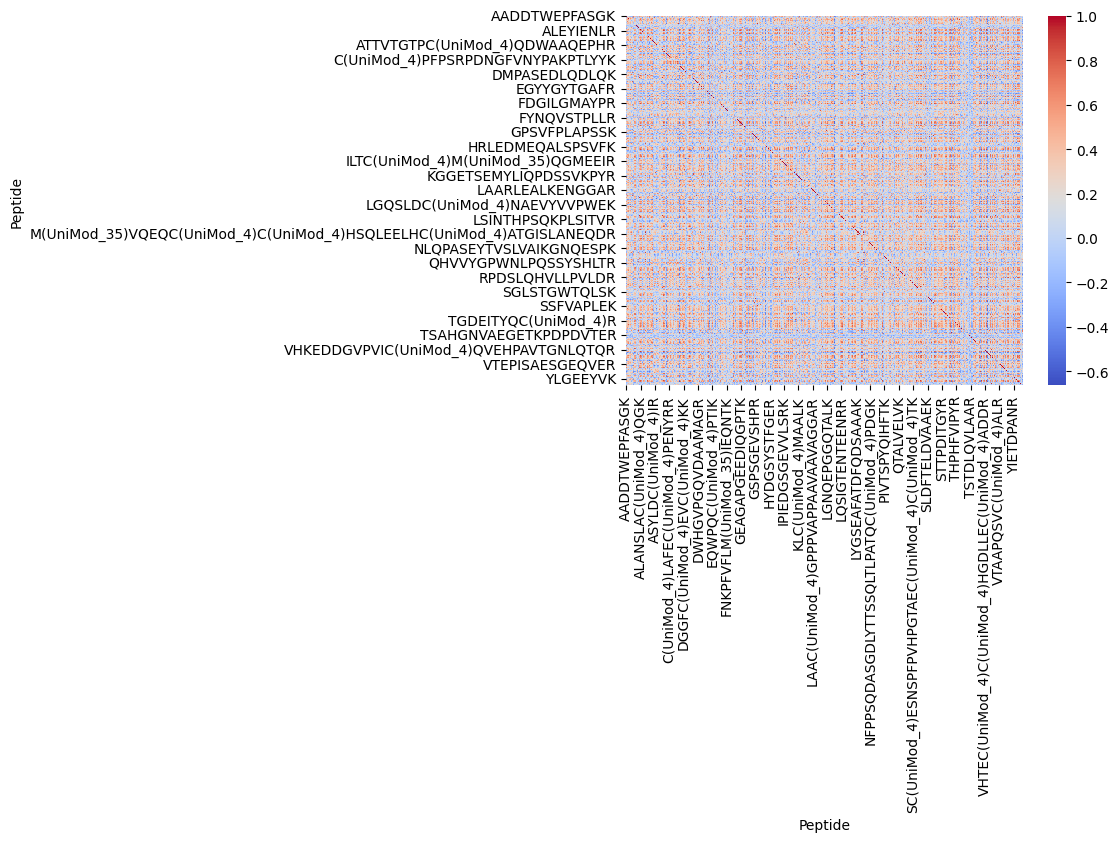

In [ ]:
'This was to assess by visualization the colinearity between dataset features'

import seaborn as sns
# Pivot the table to make peptide types as columns
pivot_df = filtered_df.pivot_table(index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance').reset_index()
'Identify to use linear or nonlinear base features representation algorithims '
# Check correlations between features, high corr PCA might fit
corr_matrix = pivot_df.drop(columns=['patient_id','visit_month']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
#sns.pairplot(pivot_df.drop(columns=['patient_id','visit_month']))  # Visualize pairwise relationships between features, can they be seperated by straightline?

([<matplotlib.axis.XTick at 0x7b348b656290>,
 [Text(0, 0, '0'),
  Text(12, 0, '12'),
  Text(24, 0, '24'),
  Text(36, 0, '36'),
  Text(48, 0, '48'),
  Text(60, 0, '60')])

<Figure size 800x600 with 0 Axes>

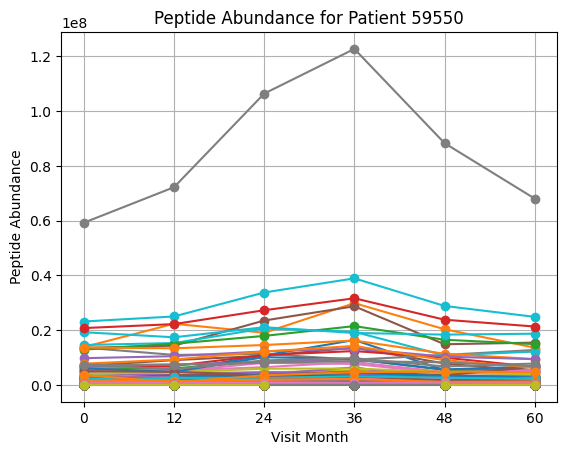

<Figure size 800x600 with 0 Axes>

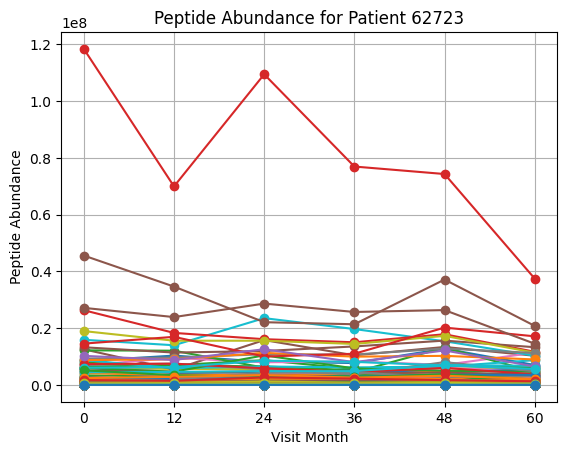

<Figure size 800x600 with 0 Axes>

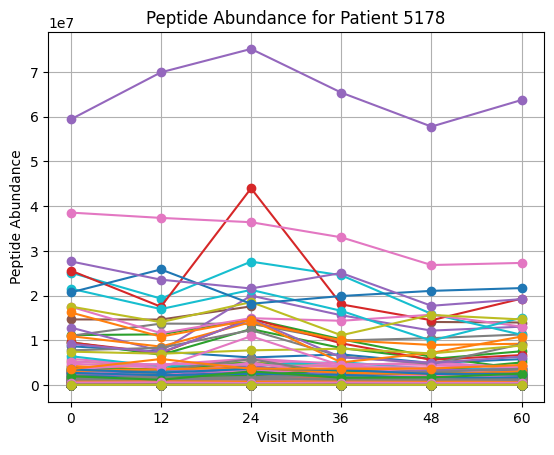

<Figure size 800x600 with 0 Axes>

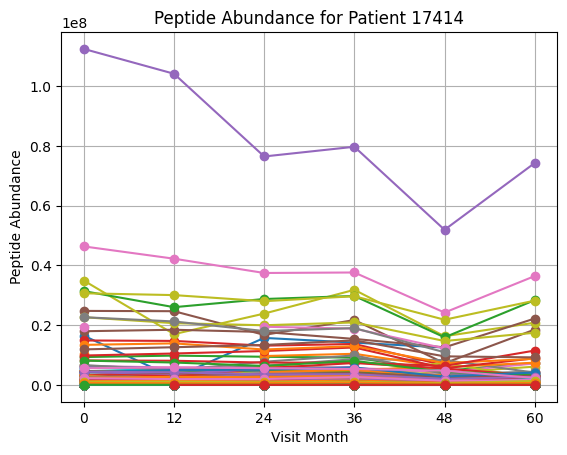

In [ ]:
# Filter data for patient_id = 112 59550 62723
df_patient_112 = filtered_[filtered_['patient_id'] == 59550]
pivot_data = df_patient_112.pivot_table(index='visit_month', columns='Peptide', values='PeptideAbundance')

# Plot the line graph
plt.figure(figsize=(8, 6))
pivot_data.plot(kind='line', marker='o', linestyle='-', markersize=6,legend=False)

# Customize the plot
plt.title('Peptide Abundance for Patient 59550')
plt.xlabel('Visit Month')
plt.ylabel('Peptide Abundance')
#plt.legend(title='Peptide')
plt.grid(True)
plt.xticks(pivot_data.index)  # Set x-ticks to visit_month values

# Filter data for patient_id = 112
df_patient_11 = filtered_[filtered_['patient_id'] == 62723]
pivot_data = df_patient_11.pivot_table(index='visit_month', columns='Peptide', values='PeptideAbundance')

# Plot the line graph
plt.figure(figsize=(8, 6))
pivot_data.plot(kind='line', marker='o', linestyle='-', markersize=6,legend=False)

# Customize the plot
plt.title('Peptide Abundance for Patient 62723')
plt.xlabel('Visit Month')
plt.ylabel('Peptide Abundance')
#plt.legend(title='Peptide')
plt.grid(True)
plt.xticks(pivot_data.index)  # Set x-ticks to visit_month values #[ 5178 17414]


# Filter data for patient_id = 112
df_patient_57 = filtered_[filtered_['patient_id'] == 5178]

pivot_data = df_patient_57.pivot_table(index='visit_month', columns='Peptide', values='PeptideAbundance')

# Plot the line graph
plt.figure(figsize=(8, 6))
pivot_data.plot(kind='line', marker='o', linestyle='-', markersize=6,legend=False)

# Customize the plot
plt.title('Peptide Abundance for Patient 5178')
plt.xlabel('Visit Month')
plt.ylabel('Peptide Abundance')
#plt.legend(title='Peptide')
plt.grid(True)
plt.xticks(pivot_data.index)  # Set x-ticks to visit_month values

# Filter data for patient_id = 112
df_patient_57 = filtered_[filtered_['patient_id'] == 17414]

pivot_data = df_patient_57.pivot_table(index='visit_month', columns='Peptide', values='PeptideAbundance')

# Plot the line graph
plt.figure(figsize=(8, 6))
pivot_data.plot(kind='line', marker='o', linestyle='-', markersize=6,legend=False)

# Customize the plot
plt.title('Peptide Abundance for Patient 17414')
plt.xlabel('Visit Month')
plt.ylabel('Peptide Abundance')
#plt.legend(title='Peptide')
plt.grid(True)
plt.xticks(pivot_data.index)  # Set x-ticks to visit_month values

In [ ]:
df= pivot_df.copy(deep=True)


In [ ]:
'To choose the right hyperparameters for algorithims, like number of componenst, or optimal number of clusters'
'1) Silhouette score for original dataset'
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

for i in range (2,30):
    # Create AgglomerativeClustering model with n_clusters=i
    agglomerative = AgglomerativeClustering(n_clusters=i)
    # Fit the model and predict labels
    data=pivot_df.drop(columns=['patient_id','visit_month'])
    labels = agglomerative.fit_predict(data)
    silhouette = silhouette_score(data, labels)
    print(f"Silhouette Score for {i} clusters: {silhouette:.4f}")


'Results: for 2 clusters, SC 0.13'
'to 100, Silhouette Score for 37 clusters: 0.1626'

Silhouette Score for 2 clusters: 0.1413
Silhouette Score for 3 clusters: 0.1416
Silhouette Score for 4 clusters: 0.1068
Silhouette Score for 5 clusters: 0.1076
Silhouette Score for 6 clusters: 0.1108
Silhouette Score for 7 clusters: 0.1175
Silhouette Score for 8 clusters: 0.0948
Silhouette Score for 9 clusters: 0.0970
Silhouette Score for 10 clusters: 0.0894
Silhouette Score for 11 clusters: 0.0918
Silhouette Score for 12 clusters: 0.0963
Silhouette Score for 13 clusters: 0.1017
Silhouette Score for 14 clusters: 0.1053
Silhouette Score for 15 clusters: 0.1077
Silhouette Score for 16 clusters: 0.1076
Silhouette Score for 17 clusters: 0.1120
Silhouette Score for 18 clusters: 0.1186
Silhouette Score for 19 clusters: 0.1252
Silhouette Score for 20 clusters: 0.1113
Silhouette Score for 21 clusters: 0.1155
Silhouette Score for 22 clusters: 0.1222
Silhouette Score for 23 clusters: 0.1265
Silhouette Score for 24 clusters: 0.1330
Silhouette Score for 25 clusters: 0.1370
Silhouette Score for 26 

'to 100, Silhouette Score for 37 clusters: 0.1626'

Silhouette Score for 2 clusters: 0.1413


<ipython-input-41-2173cb41b1c5>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df['Original clusters'] = labels


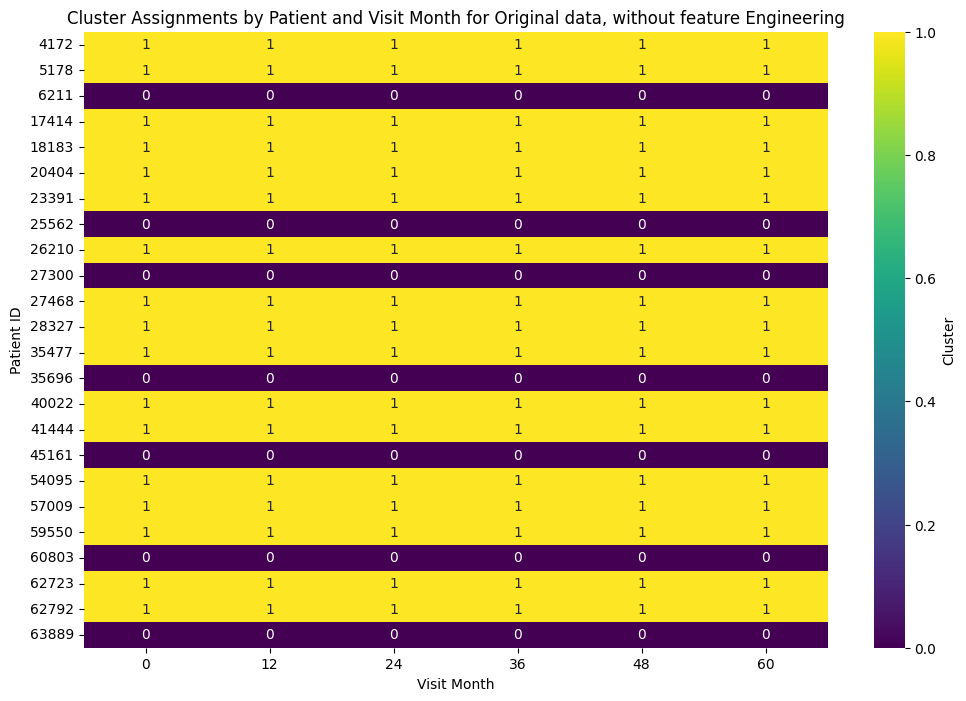

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

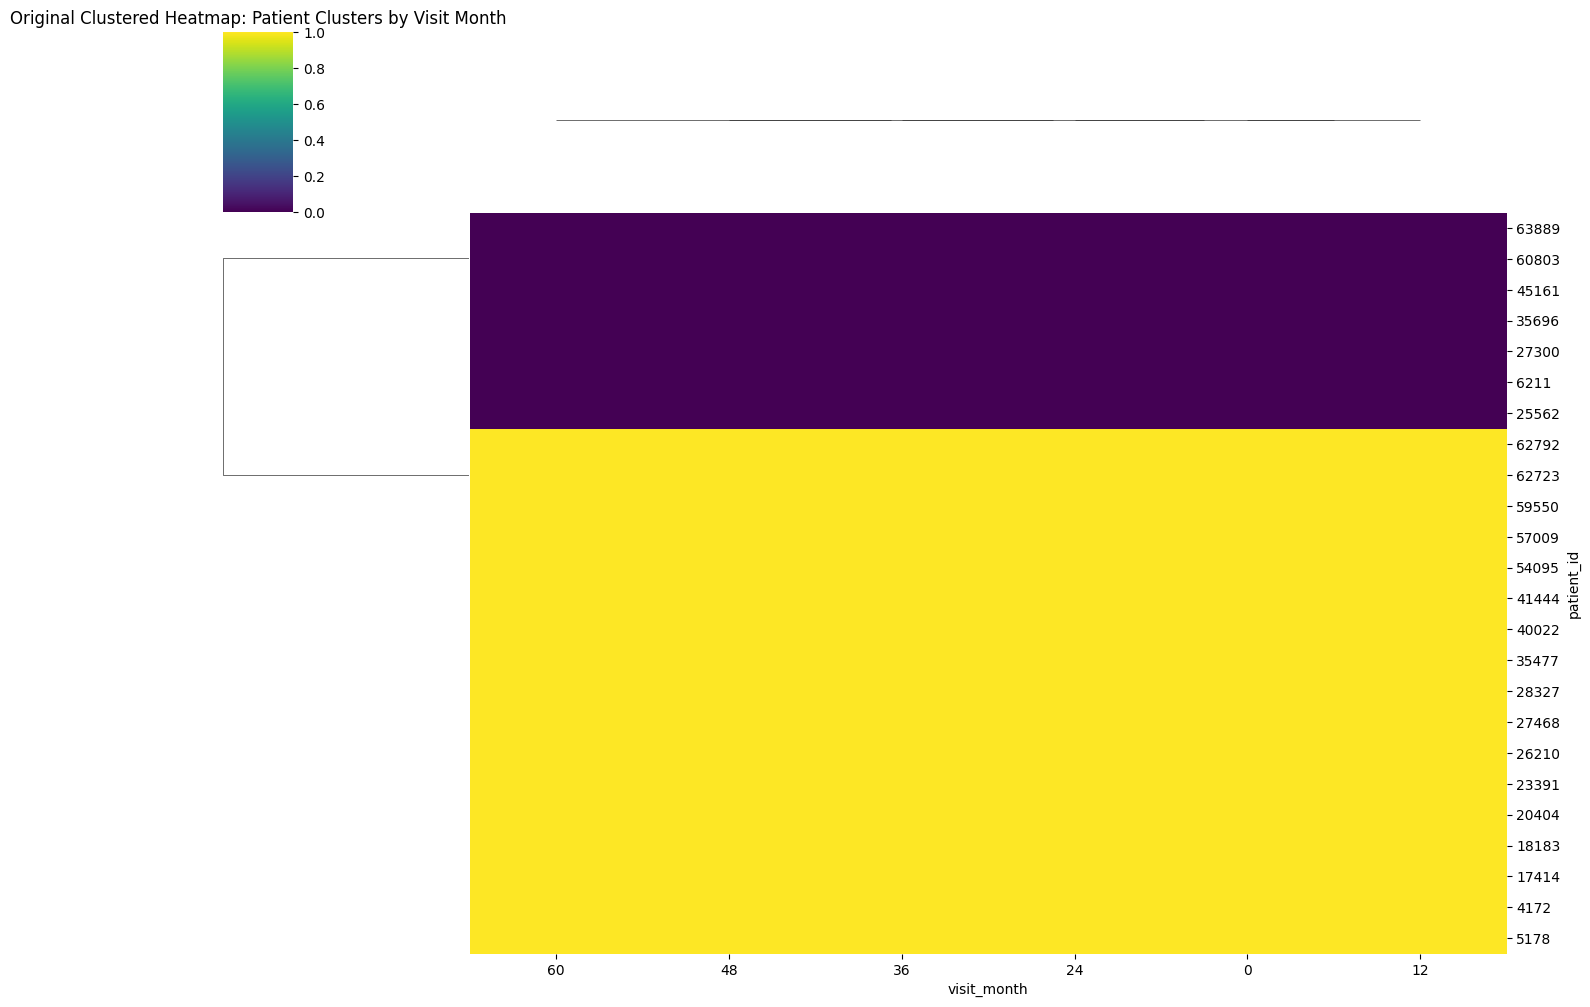

In [ ]:
'Plot original clusters'
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed
labels = agglomerative.fit_predict(pivot_df.drop(columns=['patient_id','visit_month']))
silhouette = silhouette_score(pivot_df.drop(columns=['patient_id','visit_month']), labels)
print(f"Silhouette Score for {2} clusters: {silhouette:.4f}")
# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['Original clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='Original clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month for Original data, without feature Engineering")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()


'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
#linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Original Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

In [ ]:
pivot_df= df.copy(deep=True)


In [ ]:
'2) KPCA'
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming X_scaled is already defined and is your input data

best_silhouette = -1  # Initialize the best silhouette score to a low number
best_n_components = 0  # Variable to store the best number of kPCA components
best_n_clusters = 0  # Variable to store the best number of clusters

# Loop over different numbers of kPCA components
for i in range(1, 10):  # Number of components for kPCA
    kpca = KernelPCA(n_components=i, kernel='rbf')  # Use RBF kernel (you can try other kernels too)
    X_kpca = kpca.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

    # Loop over different numbers of clusters for Agglomerative Clustering
    for j in range(2, 10):  # Number of clusters for Agglomerative Clustering
        agglomerative = AgglomerativeClustering(n_clusters=j)
        labels = agglomerative.fit_predict(X_kpca)

        # Calculate silhouette score for the current clustering and kPCA components
        silhouette = silhouette_score(X_kpca, labels)
        print(f"Silhouette Score for kPCA components={i}, Agglomerative clusters={j}: {silhouette:.4f}")

        # Update the best silhouette score and corresponding values if needed
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_n_components = i
            best_n_clusters = j

# Output the best results
print(f"\nBest Silhouette Score: {best_silhouette:.4f}")
print(f"Best number of kPCA components: {best_n_components}")
print(f"Best number of Agglomerative Clustering clusters: {best_n_clusters}")

'''
After removing colinear features:
Best Silhouette Score: 0.5666
Best number of kPCA components: 1
Best number of Agglomerative Clustering clusters: 2
'''


Silhouette Score for kPCA components=1, Agglomerative clusters=2: 0.5762
Silhouette Score for kPCA components=1, Agglomerative clusters=3: 0.5755
Silhouette Score for kPCA components=1, Agglomerative clusters=4: 0.5470
Silhouette Score for kPCA components=1, Agglomerative clusters=5: 0.5703
Silhouette Score for kPCA components=1, Agglomerative clusters=6: 0.5429
Silhouette Score for kPCA components=1, Agglomerative clusters=7: 0.5522
Silhouette Score for kPCA components=1, Agglomerative clusters=8: 0.5541
Silhouette Score for kPCA components=1, Agglomerative clusters=9: 0.5519
Silhouette Score for kPCA components=2, Agglomerative clusters=2: 0.3887
Silhouette Score for kPCA components=2, Agglomerative clusters=3: 0.4677
Silhouette Score for kPCA components=2, Agglomerative clusters=4: 0.4005
Silhouette Score for kPCA components=2, Agglomerative clusters=5: 0.3984
Silhouette Score for kPCA components=2, Agglomerative clusters=6: 0.3875
Silhouette Score for kPCA components=2, Agglomerati

'\nResults: \nto 300 components (features size), the results are below: \nBest Silhouette Score: 0.5502\nBest number of kPCA components: 1\nBest number of Agglomerative Clustering clusters: 5\n\n\nAfter removing colinear features: \nBest Silhouette Score: 0.5666\nBest number of kPCA components: 1\nBest number of Agglomerative Clustering clusters: 2\n'

Silhouette Score  Agglomerative clusters: 0.5747


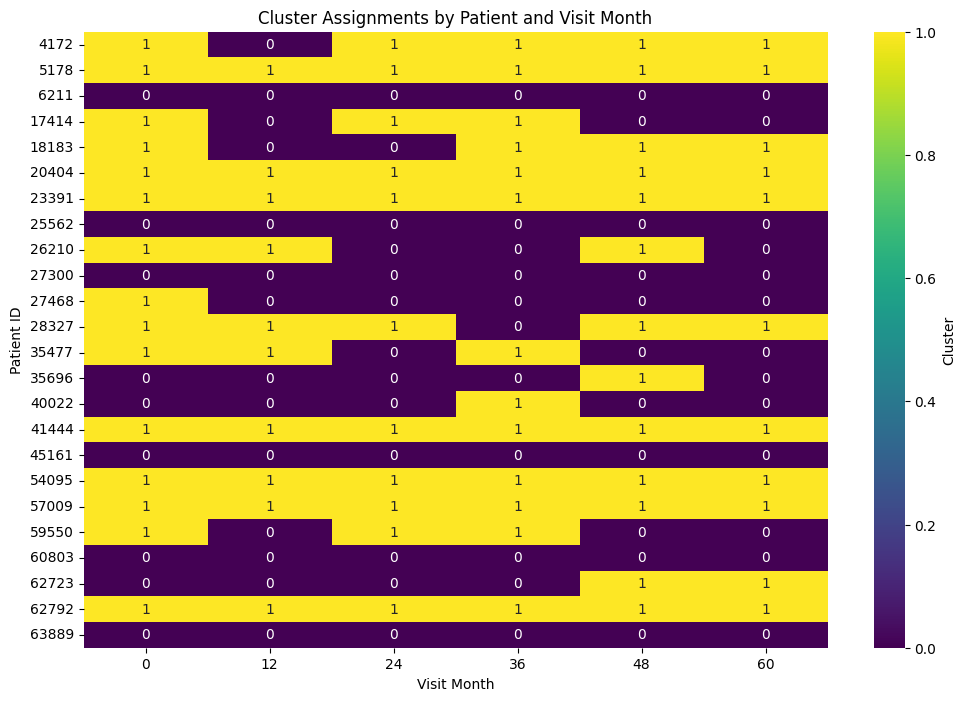

<Figure size 1200x800 with 0 Axes>

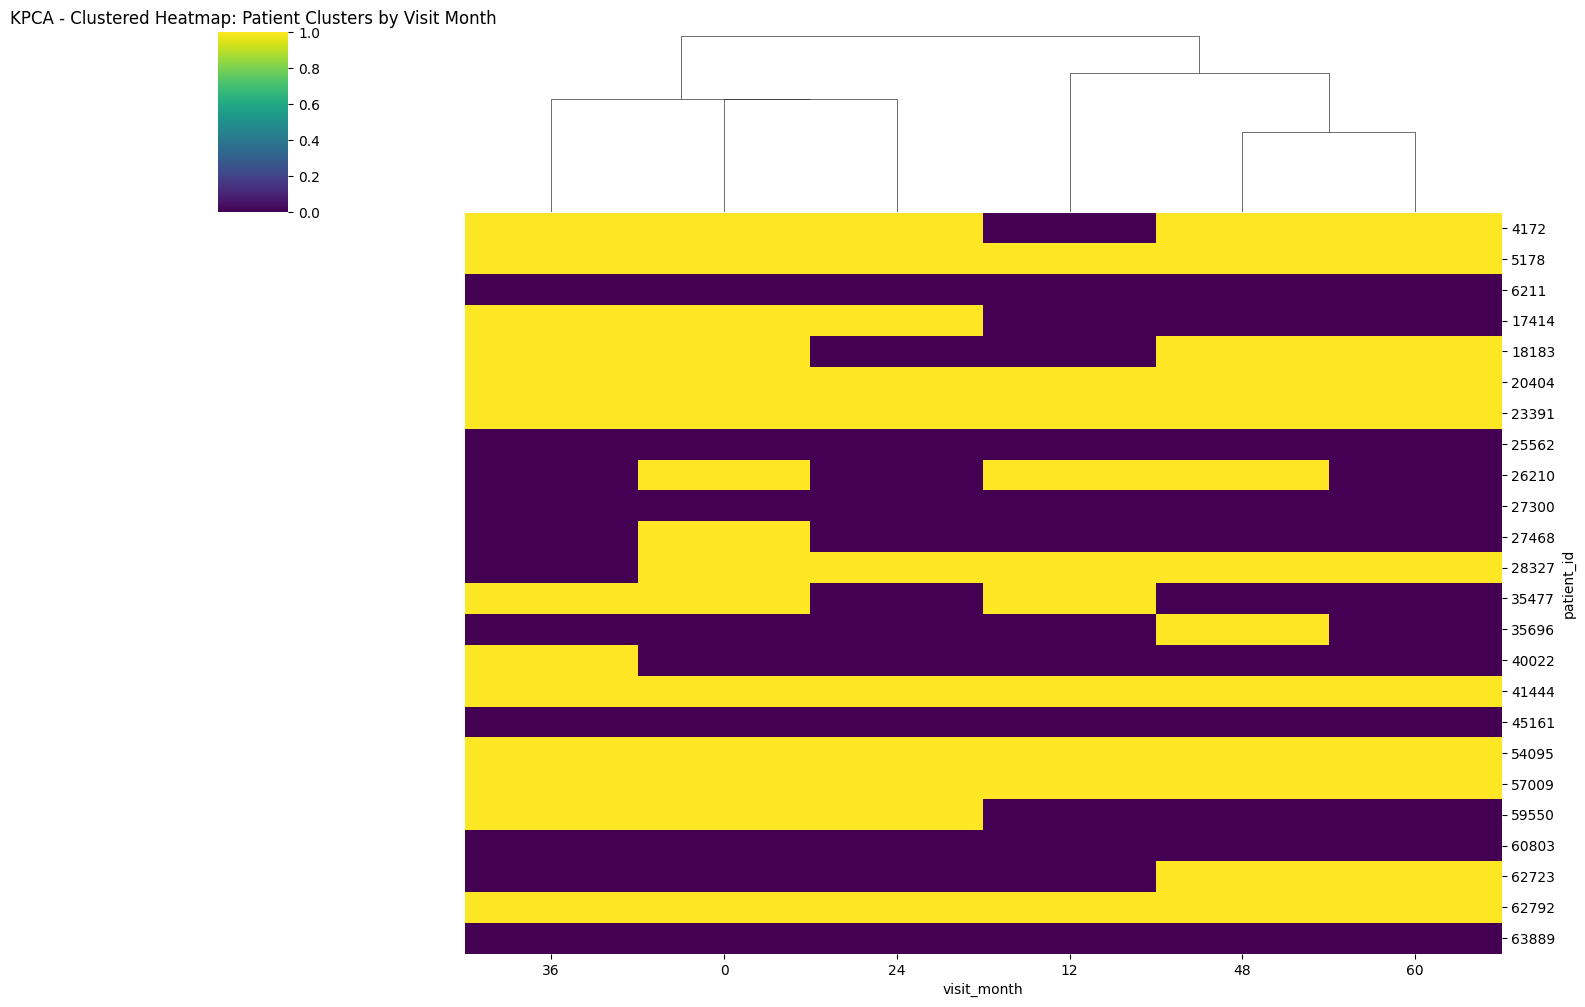

Unique patients in each KPCA cluster:
Cluster 0: [4172, 6211, 17414, 18183, 25562, 26210, 27300, 27468, 28327, 35477, 35696, 40022, 45161, 59550, 60803, 62723, 63889]
Cluster 1: [4172, 5178, 17414, 18183, 20404, 23391, 26210, 27468, 28327, 35477, 35696, 40022, 41444, 54095, 57009, 59550, 62723, 62792]


In [ ]:
#Plot PCA ot KPCA clusters
#del pivot_df['KPCA clusters']
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
# Step 2: Apply Kernel PCA for dimensionality reduction
kpca = KernelPCA(n_components=1, kernel='rbf')  # Using 3 components as an example
X_kpca = kpca.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed , 5 was best
labels = agglomerative.fit_predict(X_kpca)
silhouette = silhouette_score(X_kpca, labels)
print(f"Silhouette Score  Agglomerative clusters: {silhouette:.4f}")

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['KPCA clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='KPCA clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
#linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, col_linkage=linked_cols, row_cluster=False,  cmap="viridis", figsize=(14, 10))#row_linkage=linked_rows,

# Set title and labels
plt.title("KPCA - Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

# Step 1: Group by 'KPCA clusters' and get unique patient_ids for each cluster
clustered_patients = df_sorted.groupby('KPCA clusters')['patient_id'].unique()

# Step 2: Print the unique patient_ids for each cluster
print("Unique patients in each KPCA cluster:")
for cluster_label, patient_ids in clustered_patients.items():
    print(f"Cluster {cluster_label}: {list(patient_ids)}")


In [ ]:
pivot_df= df.copy(deep=True)

In [ ]:
'2) t-SNE'
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE


# Assuming X_scaled is already defined and is your input data

best_silhouette = -1  # Initialize the best silhouette score to a low number
best_n_components = 0  # Variable to store the best number of kPCA components
best_n_clusters = 0  # Variable to store the best number of clusters

# Loop over different numbers of kPCA components
for i in range(1, 4):  # Number of components for t-sne, The barnes_hut algorithm, used for optimization in t-SNE, is limited to a maximum of 3 components due to its reliance on quad-tree or oct-tree data structures. These structures are efficient for up to 3 dimensions but become less effective in higher dimensions.
    tsne = TSNE(n_components=i, random_state=42)
    X_tsne = tsne.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))
    # Loop over different numbers of clusters for Agglomerative Clustering
    for j in range(2, 20):  # Number of clusters for Agglomerative Clustering
        agglomerative = AgglomerativeClustering(n_clusters=j)
        labels = agglomerative.fit_predict(X_tsne)

        # Calculate silhouette score for the current clustering and kPCA components
        silhouette = silhouette_score(X_tsne, labels)
        print(f"Silhouette Score for kPCA components={i}, Agglomerative clusters={j}: {silhouette:.4f}")

        # Update the best silhouette score and corresponding values if needed
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_n_components = i
            best_n_clusters = j

# Output the best results
print(f"\nBest Silhouette Score: {best_silhouette:.4f}")
print(f"Best number of t-SNE components: {best_n_components}")
print(f"Best number of Agglomerative Clustering clusters: {best_n_clusters}")

'''
Results:
Best Silhouette Score: 0.6653
Best number of kPCA components: 1
Best number of Agglomerative Clustering clusters: 19
Silhouette Score for kPCA components=1, Agglomerative clusters=2: 0.5829
Silhouette Score for kPCA components=1, Agglomerative clusters=19: 0.7169


after removing colinear features:


'''


ValueError: perplexity must be less than n_samples

Silhouette Score for t-SNE Agglomerative clusters2: 0.5775


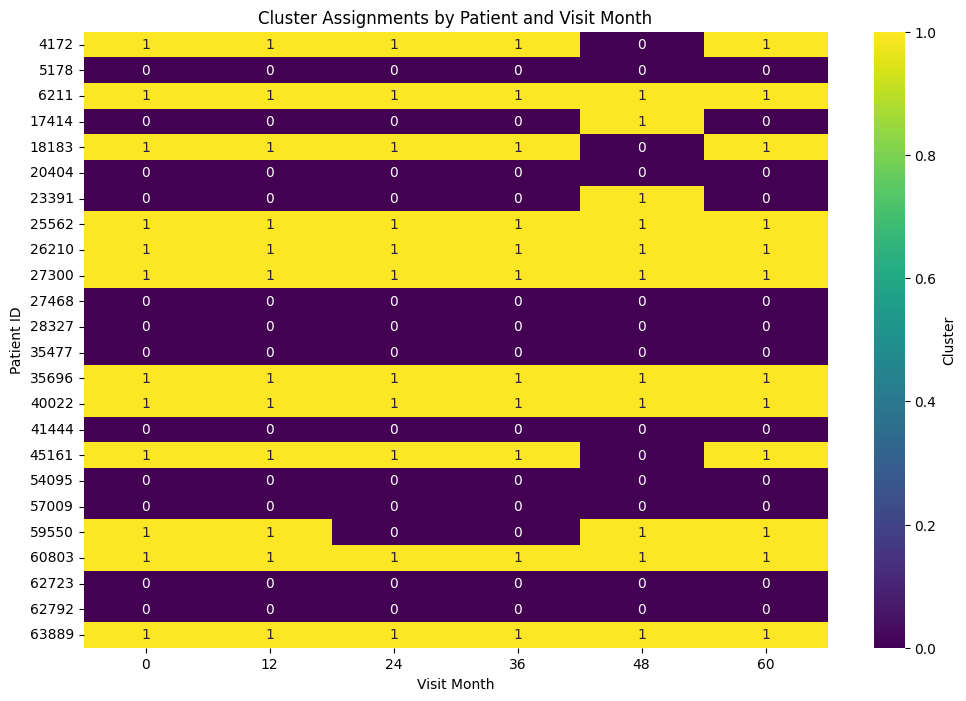

<Figure size 1200x800 with 0 Axes>

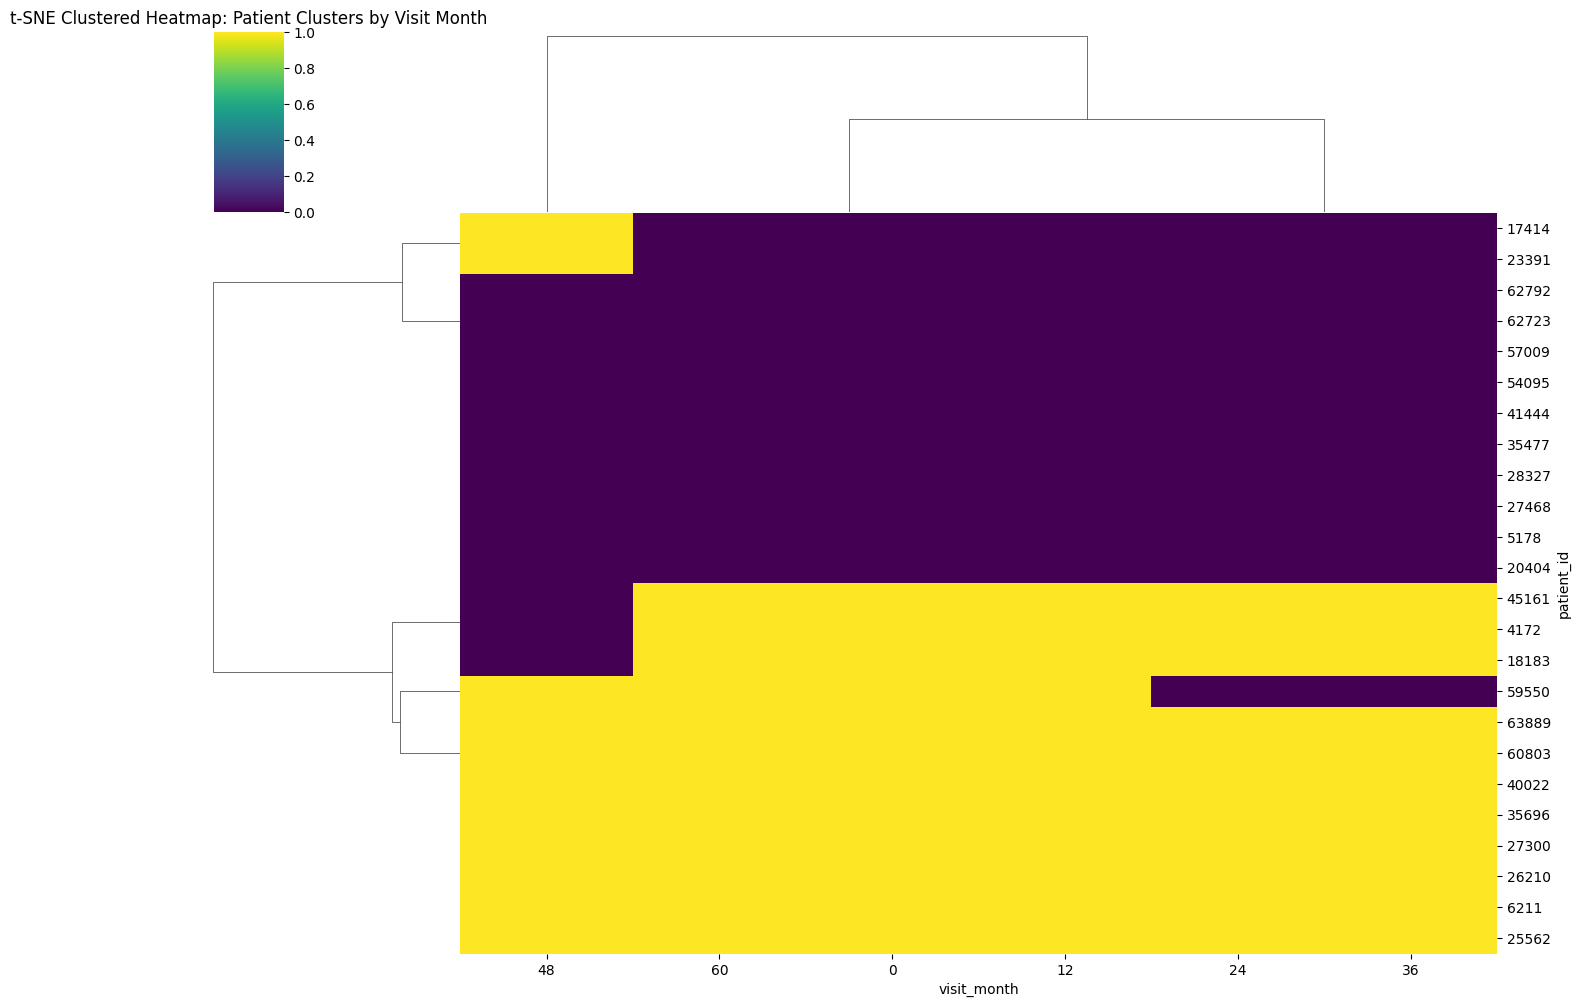

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE

# Assuming X_scaled is already defined and is your input data
#del pivot_df['t-SNE clusters']

# Step 2: Apply Kernel PCA for dimensionality reduction

n_samples = pivot_df.drop(columns=['patient_id','visit_month']).shape[0]

perplexity_value = min(30, n_samples - 1)
tsne = TSNE(n_components=1, random_state=30, perplexity=perplexity_value)
X_tsne = tsne.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed
labels = agglomerative.fit_predict(X_tsne)
silhouette = silhouette_score(X_tsne, labels)
print(f"Silhouette Score for t-SNE Agglomerative clusters2: {silhouette:.4f}")

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['t-SNE clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='t-SNE clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("t-SNE Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

In [ ]:
pivot_df= df.copy(deep=True)

In [ ]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2

# Assuming X_scaled is already defined and is your input data

best_silhouette = -1  # Initialize the best silhouette score to a low number
best_n_components = 0  # Variable to store the best number of autoencoder components
best_n_clusters = 0  # Variable to store the best number of clusters

# Define Autoencoder model
data=pivot_df.drop(columns=['patient_id','visit_month'])
input_dim = data.shape[1]
for i in range(1,10):
    pivot_df= df.copy(deep=True)
    data=pivot_df.drop(columns=['patient_id','visit_month'])
    encoding_dim = i  # Set the number of encoding dimensions (you can adjust this)
    # Input layer
    input_layer = Input(shape=(input_dim,))
    # Encoder layers
    encoded = Dense(encoding_dim, activation='relu',kernel_regularizer=l2(0.01))(input_layer)
    #encoded = Dropout(0.2)(encoded)  # 20% dropout
    # Decoder layers
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    # Encoder model (for getting the encoded representation)
    encoder = Model(inputs=input_layer, outputs=encoded)
    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    # Train the autoencoder
    autoencoder.fit(data, data, epochs=50, batch_size=1, shuffle=True)
    # Get the encoded representations
    X_autoencoded = encoder.predict(data)
    for j in range(2,15):
        agglomerative = AgglomerativeClustering(n_clusters=j)
        labels = agglomerative.fit_predict(X_autoencoded)
        # Calculate silhouette score for the current clustering and kPCA components
        silhouette = silhouette_score(X_autoencoded, labels)
        print(f"Silhouette Score for kPCA components={i}, Agglomerative clusters={j}: {silhouette:.4f}")

        # Update the best silhouette score and corresponding values if needed
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_n_components = i
            best_n_clusters = j

# Output the best results
print(f"\nBest Silhouette Score: {best_silhouette:.4f}")
print(f"Best number of kPCA components: {best_n_components}")
print(f"Best number of Agglomerative Clustering clusters: {best_n_clusters}")

'''
Best Silhouette Score: 0.6726
Best number of kPCA components: 5
Best number of Agglomerative Clustering clusters: 2

after removing mlticolinearity:
Best Silhouette Score: 0.6771
Best number of kPCA components: 6
Best number of Agglomerative Clustering clusters: 2

Best Silhouette Score: 0.9931
Best number of kPCA components: 1
Best number of Agglomerative Clustering clusters: 2
'''


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0679
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0623
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0452
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0405
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0382
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470
Epoch 16/50
35/35 ━

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Silhouette Score for kPCA components=3, Agglomerative clusters=2: 0.6043
Silhouette Score for kPCA components=3, Agglomerative clusters=3: 0.6108
Silhouette Score for kPCA components=3, Agglomerative clusters=4: 0.5125
Silhouette Score for kPCA components=3, Agglomerative clusters=5: 0.3658
Silhouette Score for kPCA components=3, Agglomerative clusters=6: 0.3915
Silhouette Score for kPCA components=3, Agglomerative clusters=7: 0.4161
Silhouette Score for kPCA components=3, Agglomerative clusters=8: 0.4081
Silhouette Score for kPCA components=3, Agglomerative clusters=9: 0.4025
Silhouette Score for kPCA components=3, Agglomerative clusters=10: 0.4123
Silhouette Score for kPCA components=3, Agglomerative clusters=11: 0.4233
Silhouette Score for kPCA components=3, Agglomerative clusters=12: 0.4015
Silhouette Score for kPCA components=3, Agglomerative clusters=13: 0.3863
Silhouette Score for kPCA components=3, Agglomerative clusters=14: 0.4014
Epoch 1/

KeyboardInterrupt: 

In [ ]:
pivot_df= df.copy(deep=True)

In [ ]:
'To cluster each patients group - Cluster 1'
pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_1_patients)]
print(pivot_df)
# Get the number of samples in the filtered DataFrame
n_samples = pivot_df.shape[0]
for i in range (2,min(100, n_samples -1 )):
    # Create AgglomerativeClustering model with n_clusters=i
    agglomerative = AgglomerativeClustering(n_clusters=i)
    # Fit the model and predict labels
    labels = agglomerative.fit_predict(pivot_df.drop(columns=['patient_id','visit_month']))
    silhouette = silhouette_score(pivot_df.drop(columns=['patient_id','visit_month']), labels)
    print(f"Silhouette Score for {i} clusters: {silhouette:.4f}")


'Results: for 2 clusters, SC 0.13'
'to 100, Silhouette Score for 37 clusters: 0.1626'

    patient_id  visit_month  AAFTEC(UniMod_4)C(UniMod_4)QAADK  AANEVSSADVK  \
13       17414           12                          0.423863     0.519365   
14       17414           24                          0.350506     0.264829   
15       17414           36                          0.359056     0.648597   
16       17414           48                          0.009621     0.000000   
17       17414           60                          0.605497     1.000000   
19       27300           12                          0.371907     0.392053   
20       27300           24                          0.358612     0.382494   
21       27300           36                          0.353261     0.460346   
22       27300           48                          0.405388     0.439915   
23       27300           60                          0.384022     0.413347   

    AATGEC(UniMod_4)TATVGKR  AAVYHHFISDGVR  ADDKETC(UniMod_4)FAEEGK  \
13                 0.516510       0.373044                 0.480730   

'to 100, Silhouette Score for 37 clusters: 0.1626'

Silhouette Score for 2 clusters: 0.1231


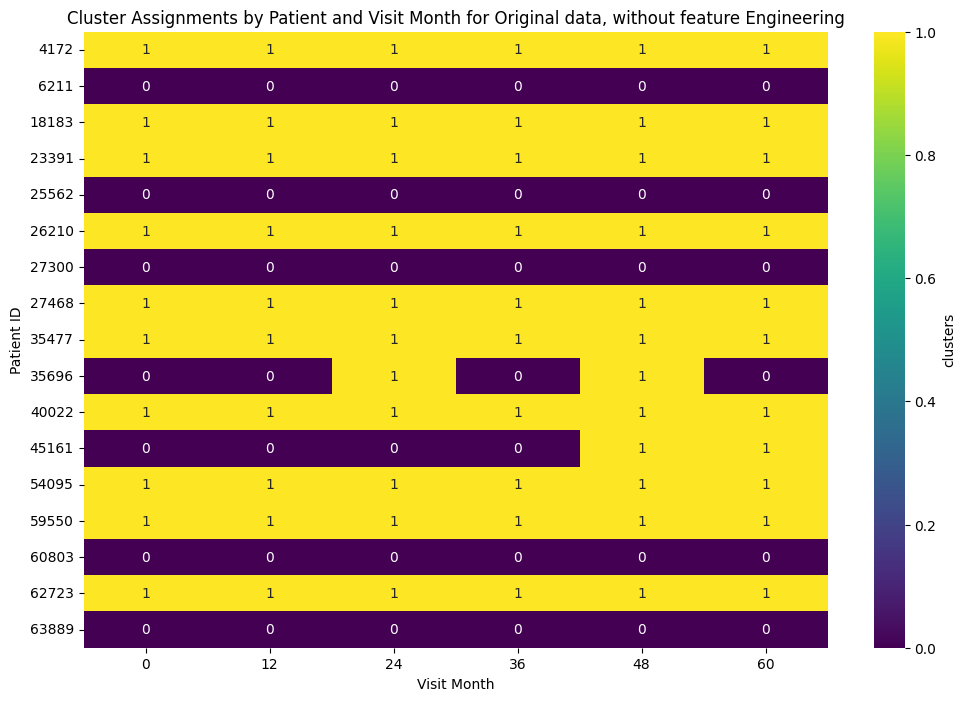

<Figure size 1200x800 with 0 Axes>

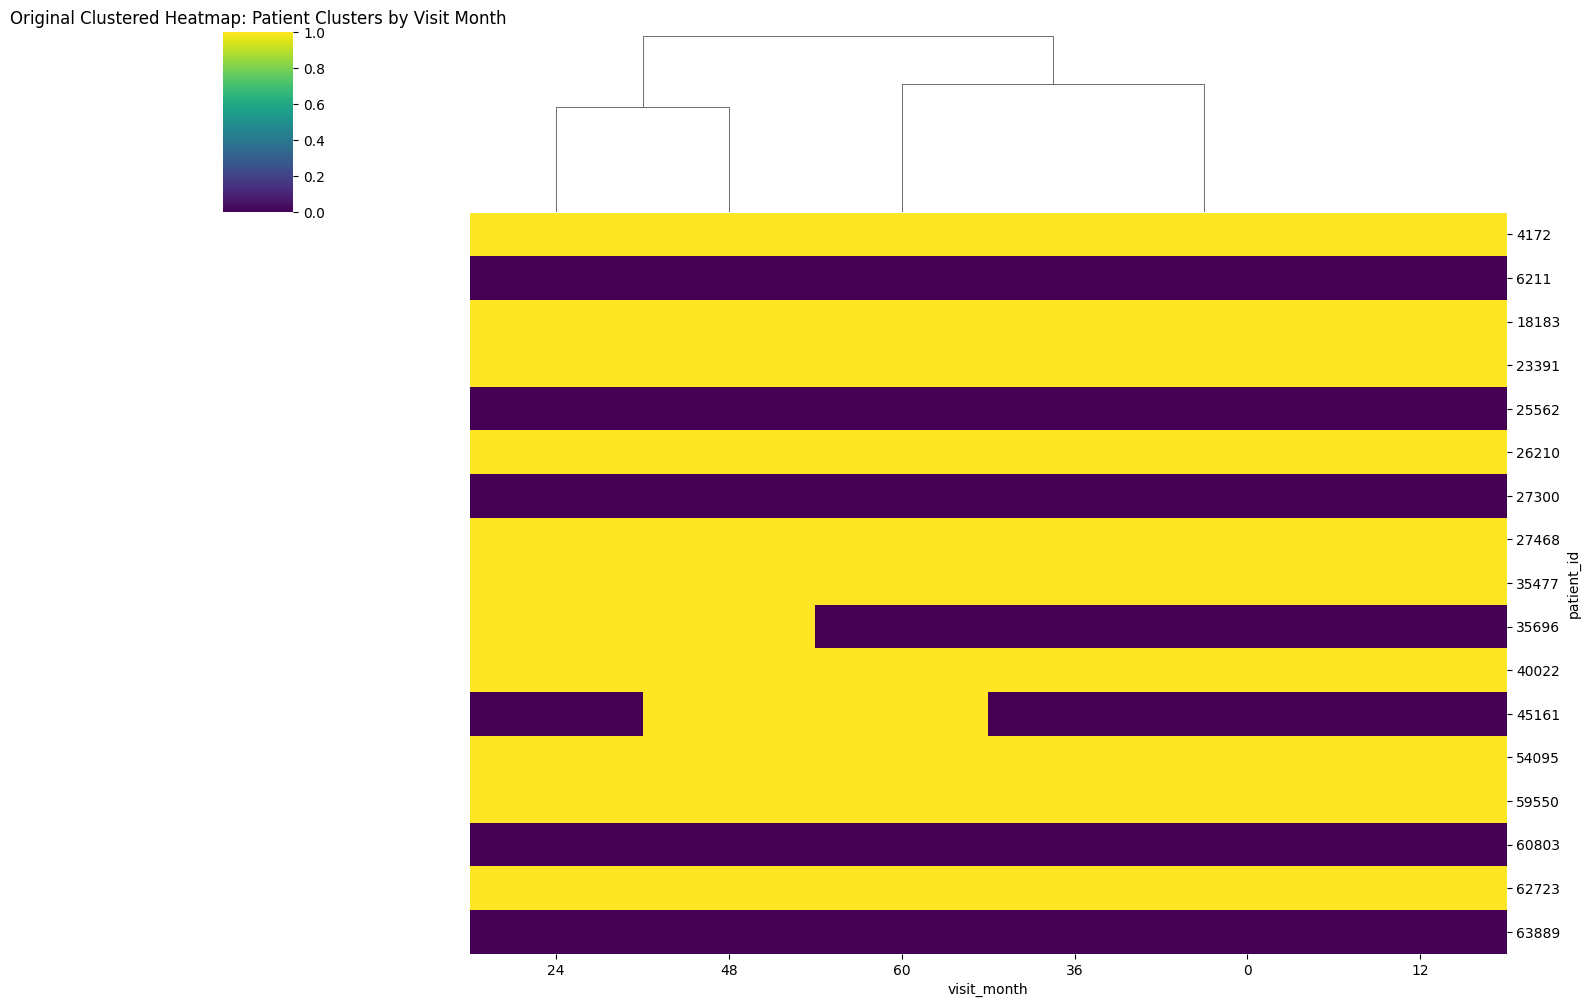

In [ ]:
'Plot original clusters'
pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_1_patients)]
# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed
labels = agglomerative.fit_predict(pivot_df.drop(columns=['patient_id','visit_month']))
silhouette = silhouette_score(pivot_df.drop(columns=['patient_id','visit_month']), labels)
print(f"Silhouette Score for {2} clusters: {silhouette:.4f}")
# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'clusters'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month for Original data, without feature Engineering")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_cluster=False,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Original Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

In [ ]:
'Plot original clusters'
pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_0_patients)]
# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=3)  # Number of clusters, adjust as needed
labels = agglomerative.fit_predict(pivot_df.drop(columns=['patient_id','visit_month']))
silhouette = silhouette_score(pivot_df.drop(columns=['patient_id','visit_month']), labels)
print(f"Silhouette Score for {2} clusters: {silhouette:.4f}")
# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'clusters'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month for Original data, without feature Engineering")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Original Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

NameError: name 'df' is not defined

Silhouette Score  Agglomerative clusters: 0.5195


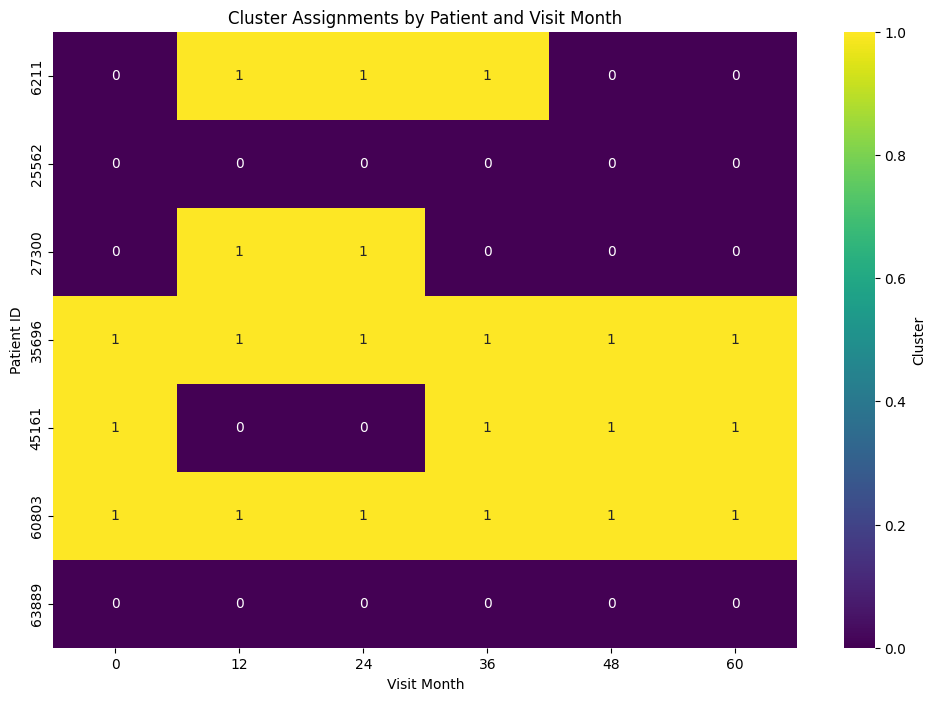

<Figure size 1200x800 with 0 Axes>

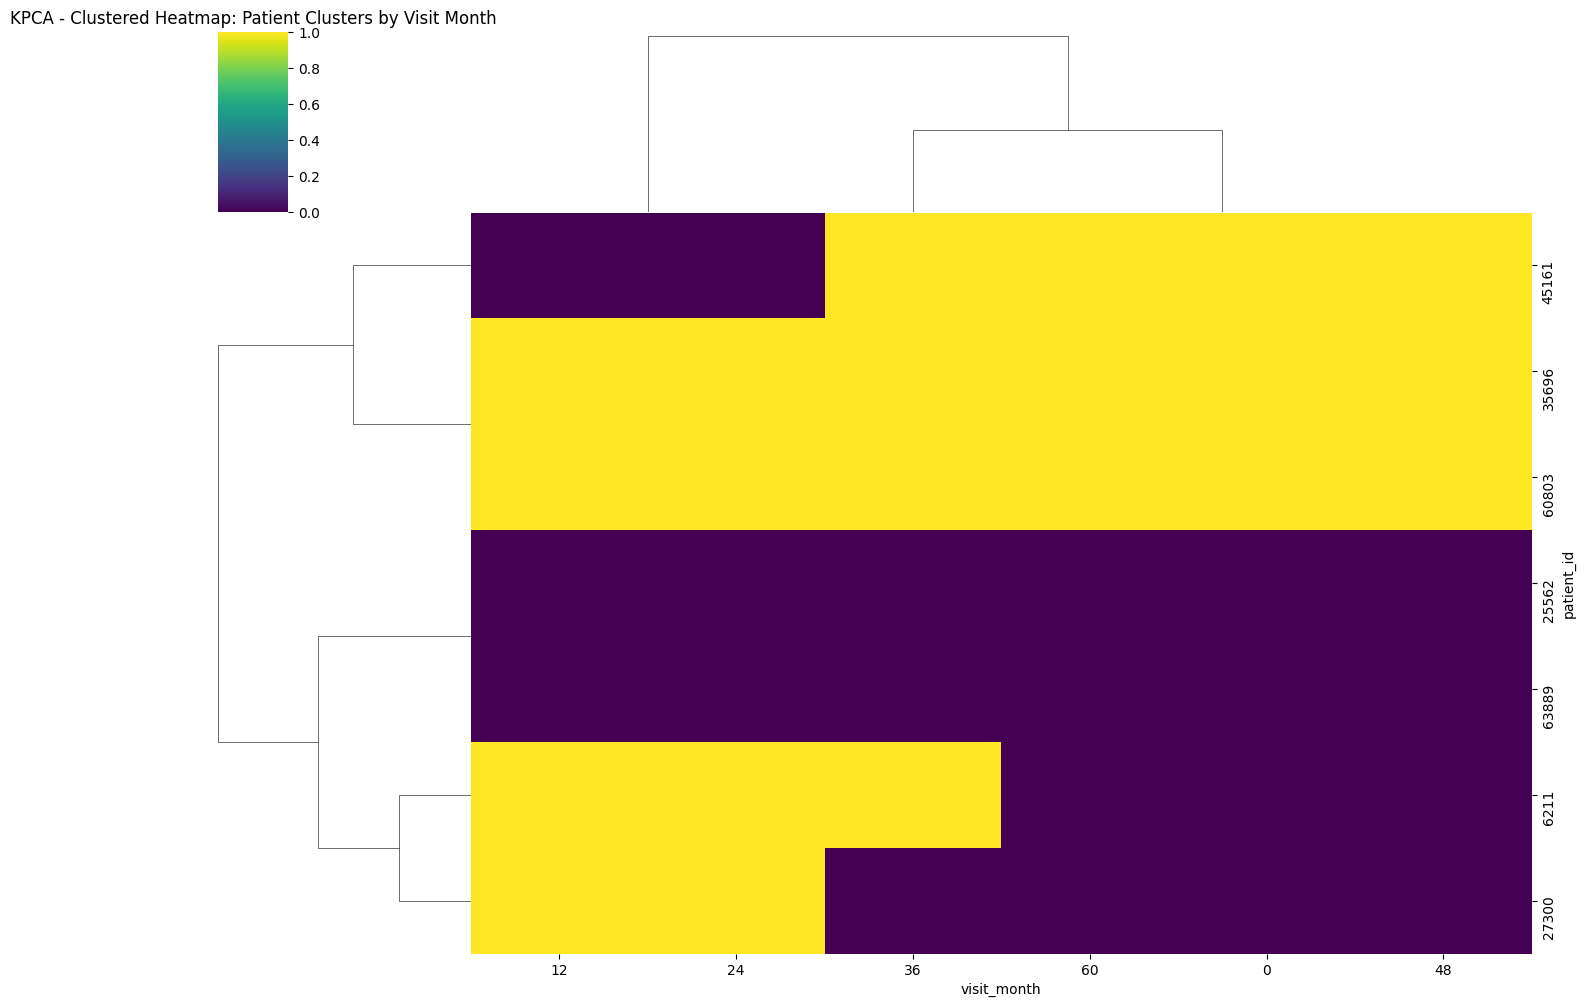

In [ ]:
pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_0_patients)]

# Step 2: Apply Kernel PCA for dimensionality reduction
kpca = KernelPCA(n_components=1)#, kernel='rbf')  # Using 3 components as an example
X_kpca = kpca.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed , 5 was best
labels = agglomerative.fit_predict(X_kpca)
silhouette = silhouette_score(X_kpca, labels)
print(f"Silhouette Score  Agglomerative clusters: {silhouette:.4f}")

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['KPCA clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='KPCA clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("KPCA - Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()


Silhouette Score for t-SNE Agglomerative clusters2: 0.6113


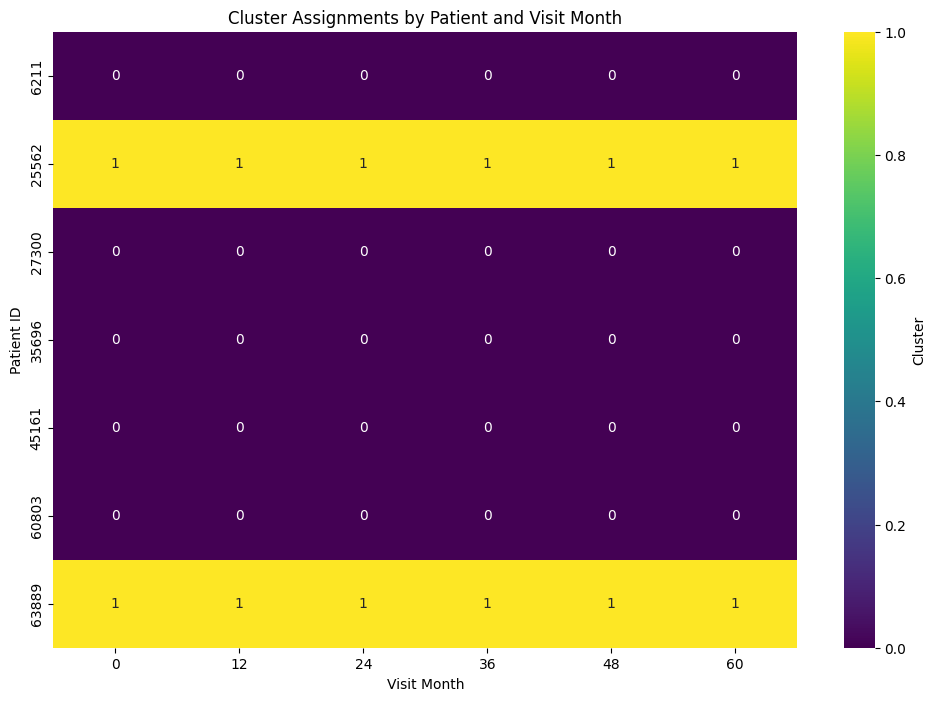

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


<Figure size 1200x800 with 0 Axes>

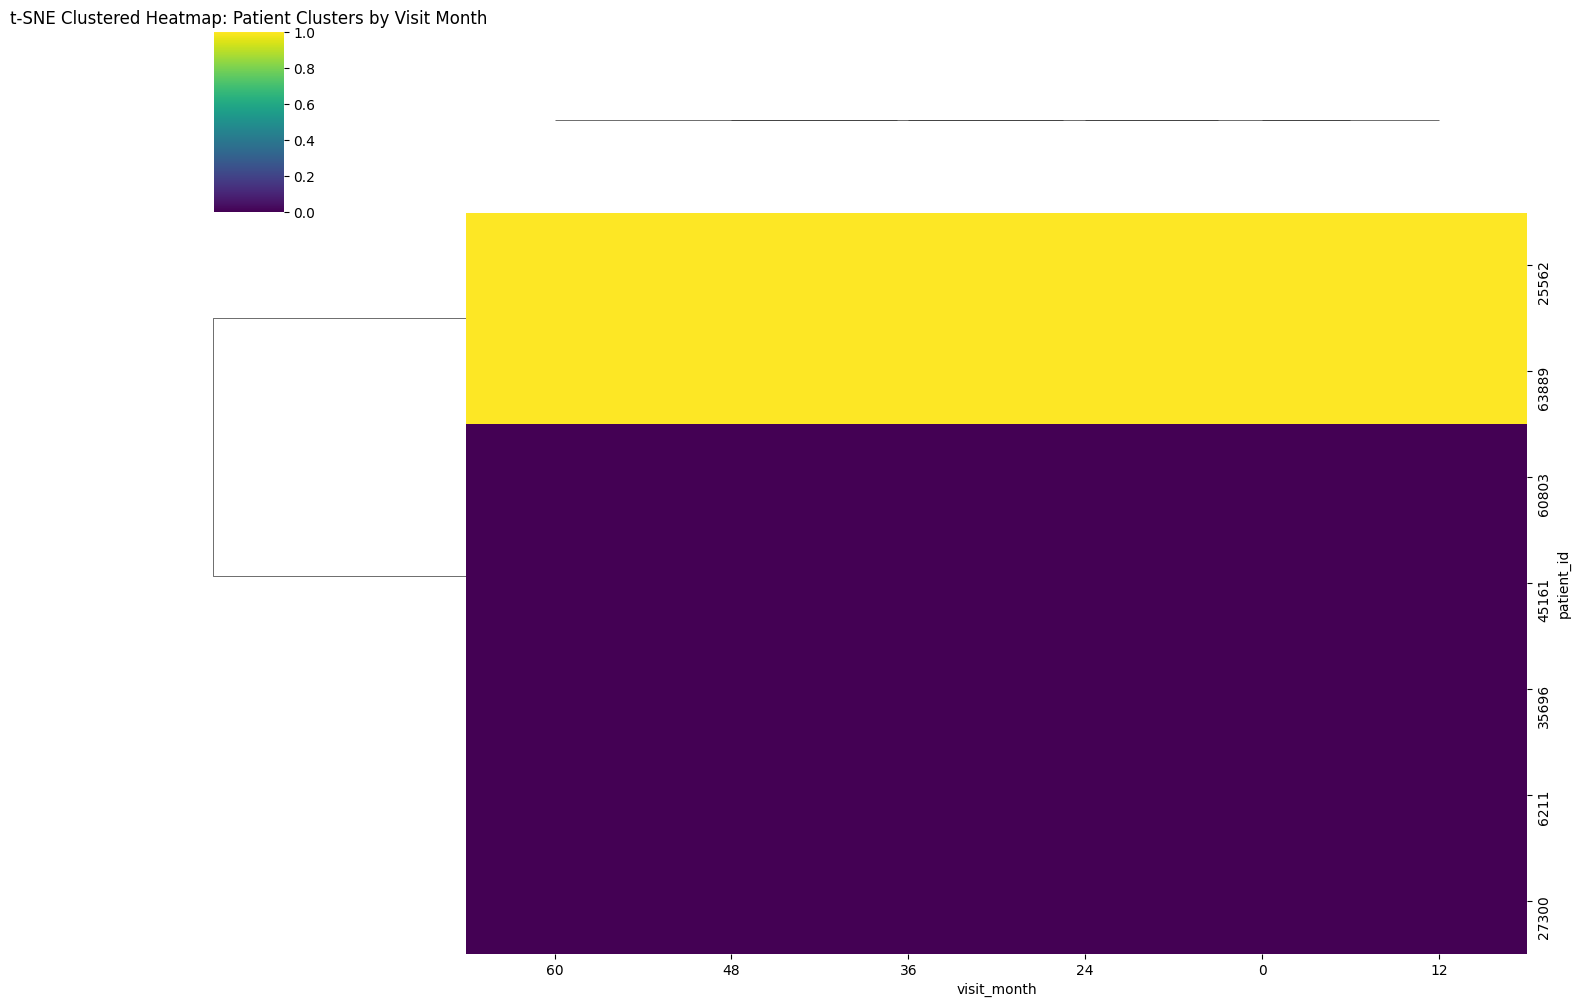

In [ ]:
pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_0_patients)]
# Step 2: Apply Kernel PCA for dimensionality reduction
tsne = TSNE(n_components=1, random_state=42)
X_tsne = tsne.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

# Step 3: Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)  # Number of clusters, adjust as needed
labels = agglomerative.fit_predict(X_tsne)
silhouette = silhouette_score(X_tsne, labels)
print(f"Silhouette Score for t-SNE Agglomerative clusters2: {silhouette:.4f}")

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['t-SNE clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='t-SNE clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("t-SNE Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0753
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0381
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0380
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0354
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0385
Epoch 9/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0370
Epoch 10/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376
Epoch 11/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0367
Epoch 12/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369
Epoch 13/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371
Epoch 14/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373
Epoch 15/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0

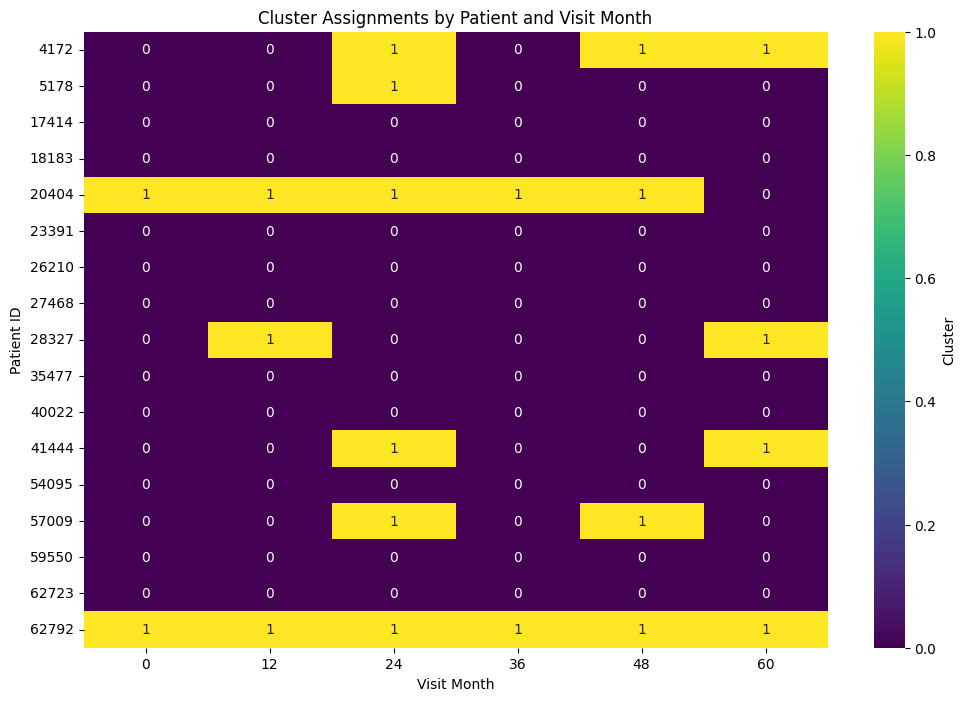

<Figure size 1200x800 with 0 Axes>

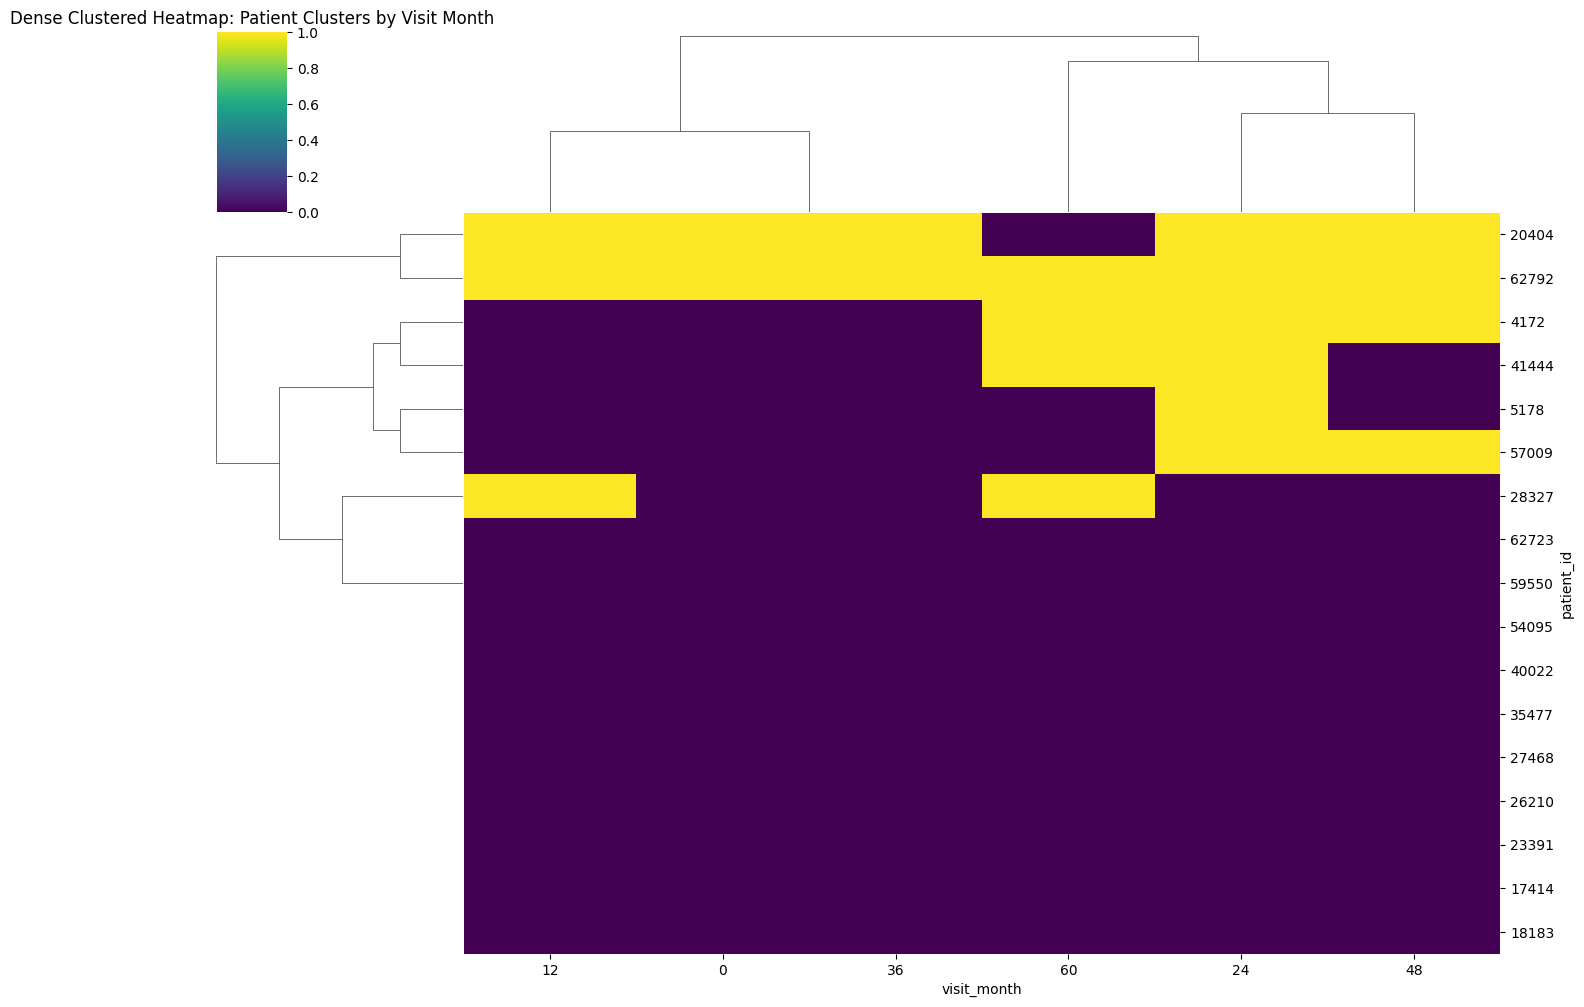

'Silhouette Score for components=3, Agglomerative clusters=2: 0.5443'

In [ ]:
from keras.layers import Dropout
from keras.regularizers import l2

pivot_df= df.copy(deep=True)
pivot_df = pivot_df[pivot_df['patient_id'].isin(cluster_1_patients)]

data=pivot_df.drop(columns=['patient_id','visit_month'])
input_dim = data.shape[1]
encoding_dim = 3 # Set the number of encoding dimensions (you can adjust this) 4 (0.70, dropout0.2)
# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.01))(input_layer)

#dropout for regularization
#encoded = Dropout(0.3)(encoded)  # 20% dropout

# Decoder layers
decoded = Dense(input_dim, activation='sigmoid')(encoded)
# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# Encoder model (for getting the encoded representation)
encoder = Model(inputs=input_layer, outputs=encoded)
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Train the autoencoder
autoencoder.fit(data, data, epochs=200, batch_size=1, shuffle=True)
# Get the encoded representations
X_autoencoded = encoder.predict(data)
agglomerative = AgglomerativeClustering(n_clusters=2)
labels = agglomerative.fit_predict(X_autoencoded)
# Calculate silhouette score for the current clustering and kPCA components
silhouette = silhouette_score(X_autoencoded, labels)
print(f"Silhouette Score for components={3}, Agglomerative clusters={2}: {silhouette:.4f}")

# Step 4: Merge the clustering result with the original data (patient_id and visit_month)
pivot_df['Autoencoder clusters'] = labels

# Ensure the data is sorted by patient_id and visit_month for plotting
df_sorted = pivot_df.sort_values(by=['patient_id', 'visit_month'])

# Step 5: Pivot the data to create a matrix for the heatmap
# Pivoting the DataFrame to have patients as rows, visit_month as columns, and cluster as values
heatmap_data = df_sorted.pivot_table(index='patient_id', columns='visit_month', values='Autoencoder clusters', aggfunc='first')

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", cbar_kws={'label': 'Cluster'}, fmt='g')
plt.title("Cluster Assignments by Patient and Visit Month")
plt.ylabel('Patient ID')
plt.xlabel('Visit Month')
plt.show()

'Clustered'
from scipy.cluster.hierarchy import dendrogram, linkage

# This will perform hierarchical clustering on both rows (patients) and columns (visit months)
plt.figure(figsize=(12, 8))
# Generate the linkage matrix for clustering rows (patients) and columns (visit months)
linked_rows = linkage(heatmap_data, 'ward')  # Clustering patients (rows)
linked_cols = linkage(heatmap_data.T, 'ward')  # Clustering visit months (columns)

# Create the seaborn heatmap with hierarchical clustering
sns.clustermap(heatmap_data, row_linkage=linked_rows,col_linkage=linked_cols, cmap="viridis", figsize=(14, 10))#

# Set title and labels
plt.title("Dense Clustered Heatmap: Patient Clusters by Visit Month")
plt.show()

'Silhouette Score for components=3, Agglomerative clusters=2: 0.5443'

In [ ]:
'Execluded as corr analysis show less linearity and colinearity between variables'
'''
#so its from 2 to 20 approximatly.
#below to check best componenet and best cluster
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming X_scaled is already defined and is your input data

best_silhouette = -1  # Initialize the best silhouette score to a low number
best_n_components = 0  # Variable to store the best number of PCA components
best_n_clusters = 0  # Variable to store the best number of clusters

# Loop over different numbers of PCA components
for i in range(1, 20):  # Number of components for PCA
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(pivot_df.drop(columns=['patient_id','visit_month']))

    # Loop over different numbers of clusters for Agglomerative Clustering
    for j in range(2, 20):  # Number of clusters for Agglomerative Clustering
        agglomerative = AgglomerativeClustering(n_clusters=j)
        labels = agglomerative.fit_predict(X_pca)

        # Calculate silhouette score for the current clustering and PCA components
        silhouette = silhouette_score(X_pca, labels)
        print(f"Silhouette Score for PCA components={i}, Agglomerative clusters={j}: {silhouette:.4f}")

        # Update the best silhouette score and corresponding values if needed
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_n_components = i
            best_n_clusters = j

# Output the best results
print(f"\nBest Silhouette Score: {best_silhouette:.4f}")
print(f"Best number of PCA components: {best_n_components}")
print(f"Best number of Agglomerative Clustering clusters: {best_n_clusters}")

'''
'''
Results:
Best Silhouette Score: 0.5656
Best number of PCA components: 1
Best number of Agglomerative Clustering clusters: 2
'''



Silhouette Score for PCA components=1, Agglomerative clusters=2: 0.5656
Silhouette Score for PCA components=1, Agglomerative clusters=3: 0.5296
Silhouette Score for PCA components=1, Agglomerative clusters=4: 0.4633
Silhouette Score for PCA components=1, Agglomerative clusters=5: 0.4773
Silhouette Score for PCA components=1, Agglomerative clusters=6: 0.4820
Silhouette Score for PCA components=1, Agglomerative clusters=7: 0.5301
Silhouette Score for PCA components=1, Agglomerative clusters=8: 0.5365
Silhouette Score for PCA components=1, Agglomerative clusters=9: 0.5180
Silhouette Score for PCA components=1, Agglomerative clusters=10: 0.5209
Silhouette Score for PCA components=1, Agglomerative clusters=11: 0.5284
Silhouette Score for PCA components=1, Agglomerative clusters=12: 0.5350
Silhouette Score for PCA components=1, Agglomerative clusters=13: 0.5597
Silhouette Score for PCA components=1, Agglomerative clusters=14: 0.5564
Silhouette Score for PCA components=1, Agglomerative cluste

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pivot the data to have peptides as columns
# Filter the dataset for a single patient (e.g., 'patient_id' == 1)
#patient_id = 4172  # Replace with the actual patient ID you want to visualize
#df_patient = df_agg[df_agg['patient_id'] == patient_id]
#df_pivot = df_patient.pivot_table(index=['patient_id'], columns=[ 'visit_month','Peptide'], values='PeptideAbundance', fill_value=0)
#for all patients
df_pivot = df_agg.pivot_table(index=['patient_id'], columns=['visit_month','Peptide'], values='PeptideAbundance', fill_value=0)
print(df_pivot)
# Standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)
print(len(X_scaled))



visit_month            0                                                    \
Peptide     AADDTWEPFASGK AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K   
patient_id                                                                   
4172             0.078397                                        -1.089969   
5178             1.783674                                        -1.768558   
6211            -0.638569                                         0.972748   
17414            0.824827                                        -0.590877   
18183           -0.566135                                         2.099258   
20404           -0.697114                                         0.021448   
23391            0.152337                                         0.205492   
25562            0.602570                                        -1.032861   
26210           -0.539143                                        -0.302510   
27300            0.417259                                       

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to perform clustering and calculate silhouette score
def cluster_and_silhouette(X, n_clusters=5):#4,5,15, 8=0.52 , 0.57, 0.76
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    return labels, silhouette


In [ ]:
labels_original, silhouette_original = cluster_and_silhouette(X_scaled)
print(f"Silhouette Score for Original Features: {silhouette_original:.4f}")
labels_pca, silhouette_pca = cluster_and_silhouette(X_pca)
print(f"Silhouette Score for PCA: {silhouette_pca:.4f}")
labels_tsne, silhouette_tsne = cluster_and_silhouette(X_tsne)
print(f"Silhouette Score for t-SNE: {silhouette_tsne:.4f}")
labels_autoencoder, silhouette_autoencoder = cluster_and_silhouette(X_autoencoded)
print(f"Silhouette Score for Autoencoder: {silhouette_autoencoder:.4f}")


Silhouette Score for Original Features: 0.0613
Silhouette Score for PCA: 0.2309
Silhouette Score for t-SNE: 0.3618
Silhouette Score for Autoencoder: 0.3931


Peptide      ASEGGFTATGQR  AVLPTGDVIGDSAK  C(UniMod_4)FSGQC(UniMod_4)ISK  \
visit_month                                                                
0                0.000000        0.911092                       0.473328   
12               0.000000        0.000000                      -1.514624   
24              -0.800076        0.481169                      -0.164818   
36               0.000000        0.000000                       1.206114   
48               1.409943       -1.392260                       0.000000   
60              -0.609868        0.000000                       0.000000   

Peptide      DSGVPDRFSGSGSGTDFTLK  KSQPMGLWR  LKDDEVAQLKK  RYIETDPANRDR  \
visit_month                                                               
0                       -1.213005  -1.277820    -0.669272     -1.824294   
12                       0.000000   1.035069    -1.484363      0.359683   
24                      -0.023151  -0.788293     0.556891      0.234882   
36              

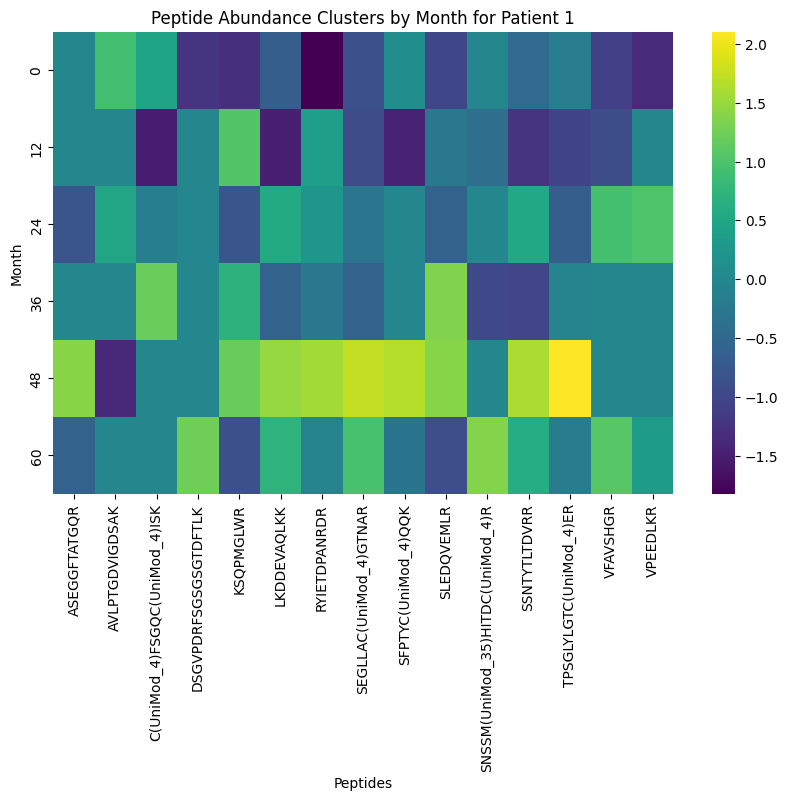

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for the first patient
df_patient_1 = df[df['patient_id'] == 4172]
# Pivot the data to have peptides as columns and months as rows
df_pivot_patient_1 = df_patient_1.pivot_table(index='visit_month', columns='Peptide', values='PeptideAbundance', fill_value=0)

# Print the pivoted DataFrame to verify
print(df_pivot_patient_1)
# Apply K-Means clustering to peptide abundances by month (e.g., 2 clusters)
from sklearn.cluster import KMeans


# Perform K-Means clustering (with 2 clusters as an example)
kmeans_patient_1 = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_patient_1.fit_predict(df_pivot_patient_1)  # Exclude 'Cluster' if already added

# Add cluster labels to DataFrame (optional step, if you want to inspect later)
df_pivot_patient_1['Cluster'] = cluster_labels

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pivot_patient_1.drop(columns='Cluster'), cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")


# Print the DataFrame with cluster labels
print(df_pivot_patient_1)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap for peptide abundances by month, including clustering information
plt.figure(figsize=(10, 6))

# We are excluding the 'Cluster' column for the heatmap
sns.heatmap(df_pivot_patient_1.drop(columns='Cluster'), annot=False, cmap='viridis', cbar=True,
            xticklabels=df_pivot_patient_1.columns[:-1], yticklabels=df_pivot_patient_1.index)

# Add a title and labels
plt.title('Peptide Abundance Clusters by Month for Patient 1')
plt.xlabel('Peptides')
plt.ylabel('Month')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Assuming the dataset has 'patient_id', 'visit_month', 'peptide', and 'abundance' columns.
# Example: data = pd.read_csv('your_dataset.csv')

# Pivot the data so that rows are usernames, columns are days, and values are deficiency rates
data_pivot = data.pivot_table(index='patient_id', columns='visit_month', values='PeptideAbundance')

# Standardize deficiency rate values (important for clustering)
scaler = StandardScaler()
data_pivot_scaled = scaler.fit_transform(data_pivot)

# Apply KMeans clustering (or other clustering methods) to find distinct states
kmeans = KMeans(n_clusters=3, random_state=42)
data_pivot['cluster'] = kmeans.fit_predict(data_pivot_scaled)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(data_pivot_scaled, data_pivot['cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Visualize the clustering with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_pivot.drop('cluster', axis=1), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Deficiency Rates by User and Day')
plt.xlabel('Day Number')
plt.ylabel('Username')
plt.show()

# Visualize clustering results
plt.figure(figsize=(12, 8))
sns.heatmap(data_pivot.drop('cluster', axis=1).T, annot=True, cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Deficiency Rate'})
plt.title('Deficiency Rate Heatmap Across Days for Different Users (Clusters)')
plt.xlabel('Username')
plt.ylabel('Day Number')
plt.show()



NameError: name 'data' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer

# Create a list of unique peptides
unique_peptides = df['Peptide'].unique()

# Create a feature matrix: rows = peptides, columns = abundances
feature_matrix = []
max_len = 0  # To store the maximum length of abundance lists

for peptide in unique_peptides:
    abundances = df[df['Peptide'] == peptide]['PeptideAbundance'].tolist()
    feature_matrix.append(abundances)
    max_len = max(max_len, len(abundances))  # Update max_len

# Pad shorter lists with zeros to make them equal length
for i in range(len(feature_matrix)):
    while len(feature_matrix[i]) < max_len:
        feature_matrix[i].append(0)  # Pad with zeros

# Convert to numpy array and standardize
feature_matrix = np.array(feature_matrix)
# Impute missing values if any
imputer = SimpleImputer(strategy='mean')  # Replace missing with mean
feature_matrix = imputer.fit_transform(feature_matrix)
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)
print(feature_matrix_scaled.shape)  # Shape: (num_peptides, num_samples)

(968, 161)


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
n_clusters = 5  # Adjust based on your data
clustering = AgglomerativeClustering(n_clusters=n_clusters)
peptide_clusters = clustering.fit_predict(feature_matrix_scaled)

# Add cluster labels to the unique peptides
peptide_to_cluster = {peptide: cluster for peptide, cluster in zip(unique_peptides, peptide_clusters)}
print(peptide_to_cluster)
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
# Only calculate if n_clusters is greater than 1
silhouette_avg = silhouette_score(feature_matrix_scaled, peptide_clusters)
print(f"Silhouette Score: {silhouette_avg}")

{'NEQEQPLGQWHLS': 1, 'GNPEPTFSWTK': 1, 'IEIPSSVQQVPTIIK': 1, 'KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK': 1, 'SMEQNGPGLEYR': 3, 'TLKIENVSYQDKGNYR': 1, 'VIAVNEVGR': 3, 'VMTPAVYAPYDVK': 1, 'VNGSPVDNHPFAGDVVFPR': 1, 'ELDLNSVLLK': 3, 'HGTC(UniMod_4)AAQVDALNSQKK': 1, 'ALPGTPVASSQPR': 1, 'LFGGNFAHQASVAR': 1, 'LYQQHGAGLFDVTR': 1, 'VTEPISAESGEQVER': 1, 'AYQGVAAPFPK': 2, 'QQETAAAETETR': 1, 'THLGEALAPLSK': 1, 'ASGSPEPAISWFR': 1, 'NIINSDGGPYVC(UniMod_4)R': 1, 'TALASGGVLDASGDYR': 3, 'TQSSLVPALTDFVR': 1, 'ALMSPAGMLR': 1, 'GLYDVVSVLR': 1, 'SEGLLAC(UniMod_4)GTNAR': 1, 'ILEVVNQIQDEER': 1, 'QALNTDYLDSDYQR': 1, 'ADDLGKGGNEESTKTGNAGSR': 1, 'TLVVHEKADDLGKGGNEESTK': 1, 'ALYLQYTDETFR': 1, 'EVGPTNADPVC(UniMod_4)LAK': 0, 'FNKNNEGTYYSPNYNPQSR': 0, 'GAYPLSIEPIGVR': 0, 'KAEEEHLGILGPQLHADVGDKVK': 1, 'MFTTAPDQVDKEDEDFQESNK': 1, 'MYYSAVDPTKDIFTGLIGPM(UniMod_35)K': 1, 'NNEGTYYSPNYNPQSR': 1, 'QYTDSTFRVPVER': 1, 'SVPPSASHVAPTETFTYEWTVPK': 1, 'DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR': 1, 'ELLESYIDGR': 1, 'LAVTTHGLPC(UniM

In [ ]:
# Function to assign a state to a patient-month based on peptide clusters
def assign_state(peptide_data, peptide_to_cluster):
    cluster_counts = {}
    for peptide, abundance in peptide_data:
        cluster = peptide_to_cluster[peptide]
        if cluster not in cluster_counts:
            cluster_counts[cluster] = 0
        cluster_counts[cluster] += 1
    # Assign the state with the highest count
    state = max(cluster_counts, key=cluster_counts.get)
    return state

# Assign states to each patient-month
patient_month_data['state'] = patient_month_data['peptide_data'].apply(lambda x: assign_state(x, peptide_to_cluster))
print(patient_month_data)

     patient_id  visit_month  \
0          4172            0   
1          4172           12   
2          4172           24   
3          4172           36   
4          4172           48   
..          ...          ...   
156       63889           12   
157       63889           24   
158       63889           36   
159       63889           48   
160       63889           60   

                                          peptide_data  state  
0    [(NEQEQPLGQWHLS, -1.1132958141775795), (GNPEPT...      1  
1    [(NEQEQPLGQWHLS, -0.9033010866037877), (GNPEPT...      1  
2    [(NEQEQPLGQWHLS, -0.5536354794240586), (GNPEPT...      1  
3    [(NEQEQPLGQWHLS, 0.6253333361772816), (GNPEPTF...      1  
4    [(NEQEQPLGQWHLS, 1.7957809880508642), (GNPEPTF...      1  
..                                                 ...    ...  
156  [(GNPEPTFSWTK, -1.4299688467042515), (IEIPSSVQ...      1  
157  [(GNPEPTFSWTK, 0.4409344331365799), (IEIPSSVQQ...      1  
158  [(GNPEPTFSWTK, 0.9553963736265019)

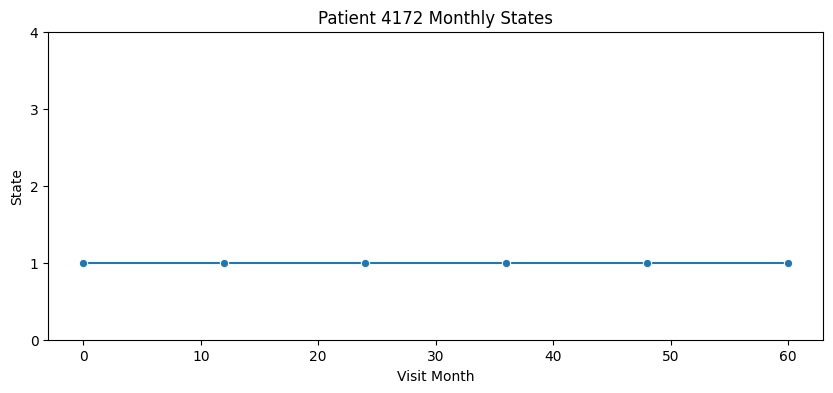

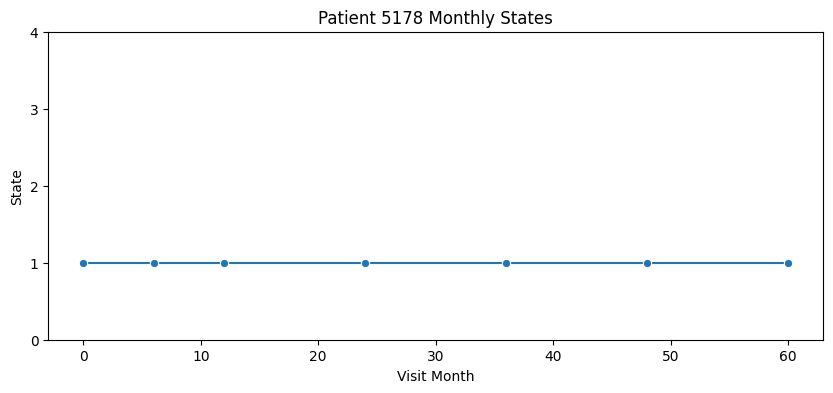

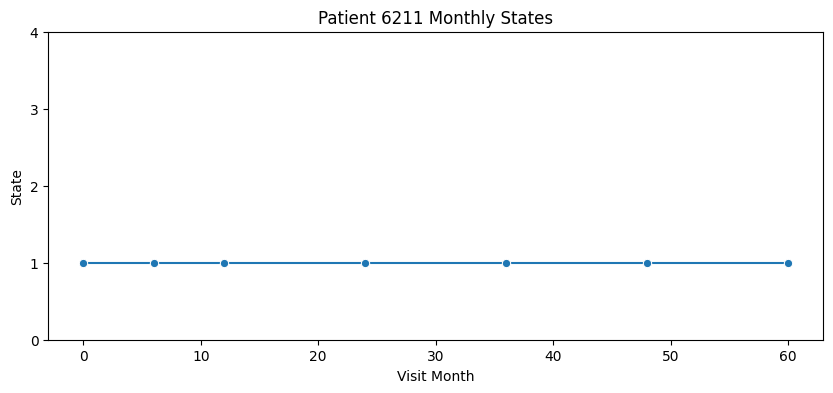

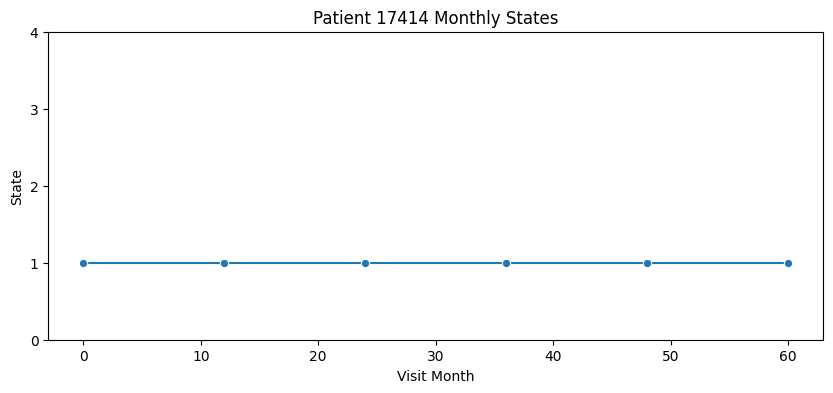

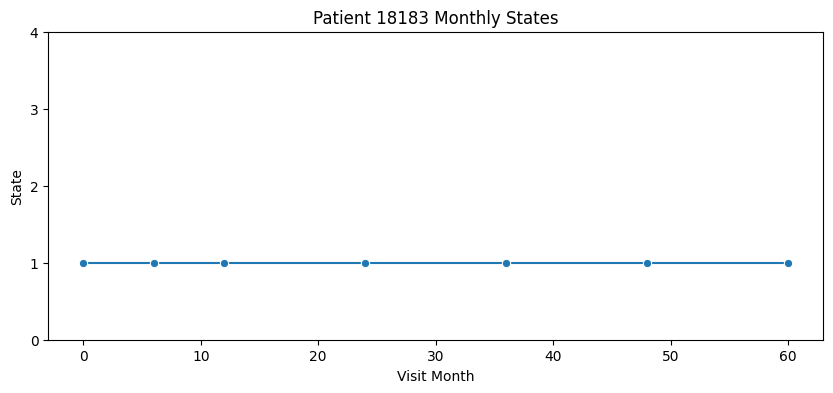

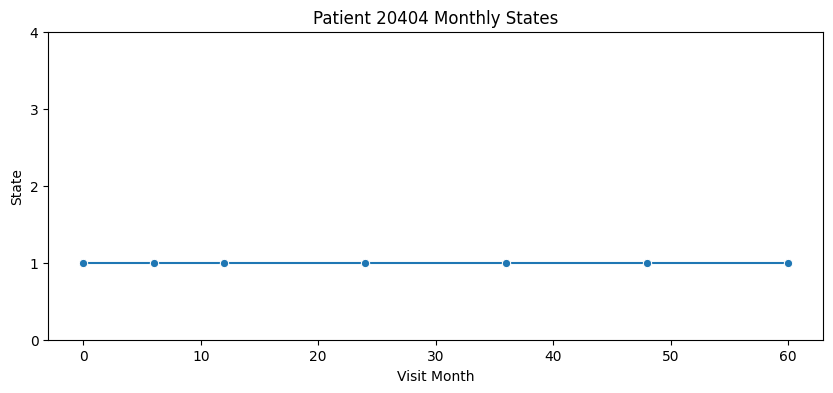

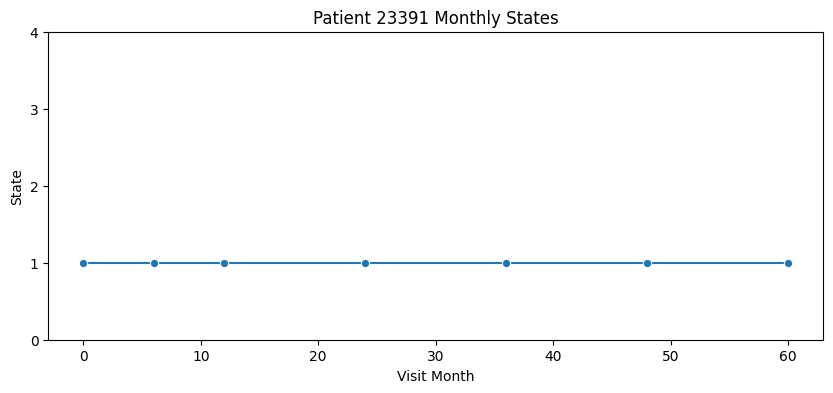

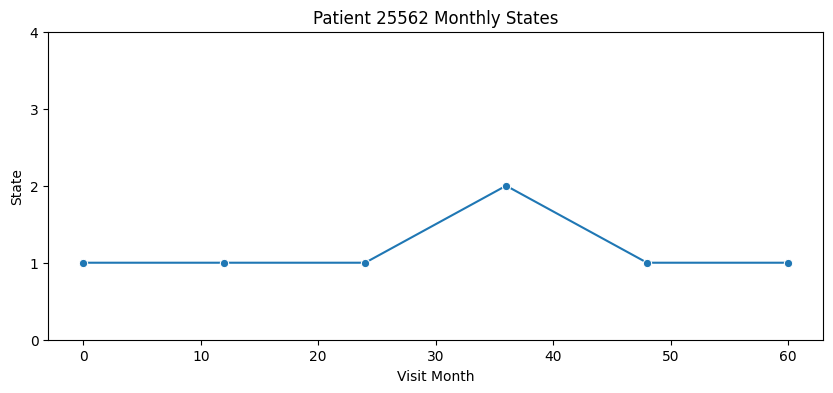

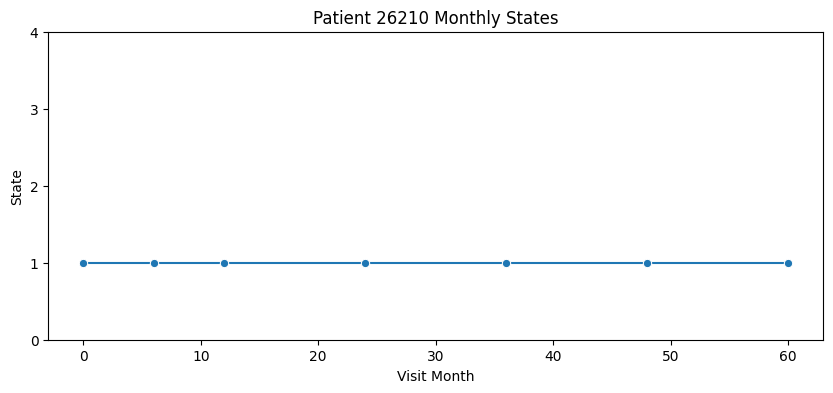

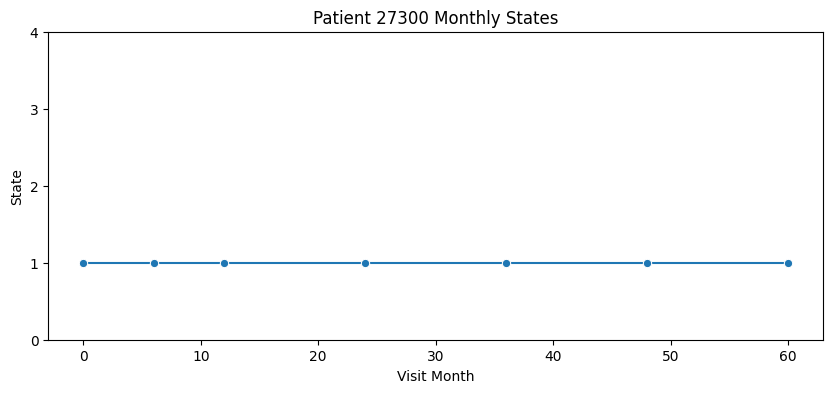

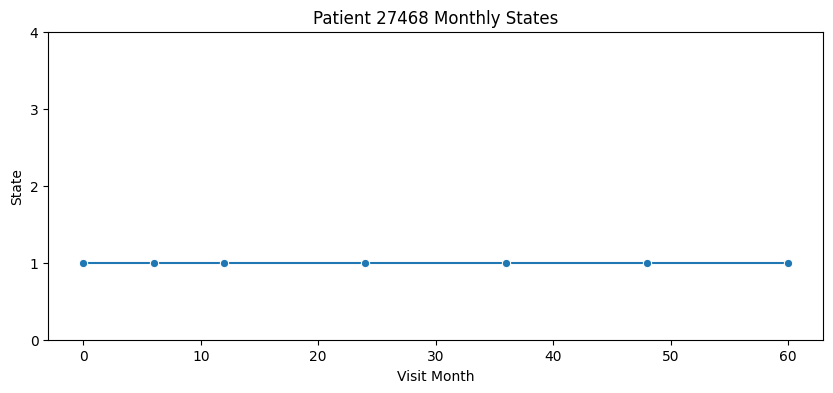

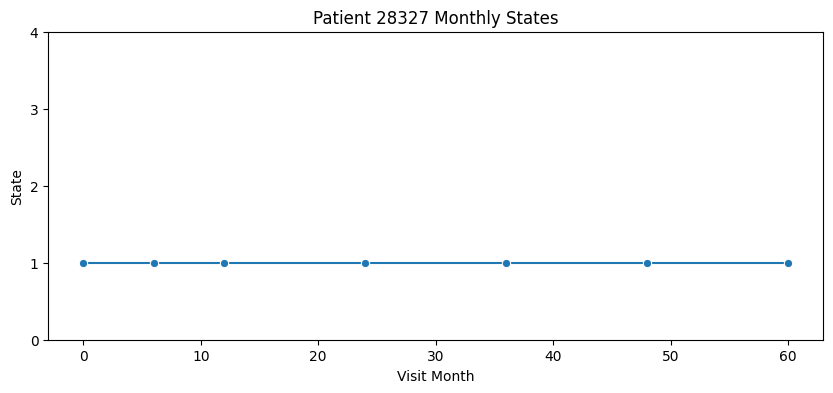

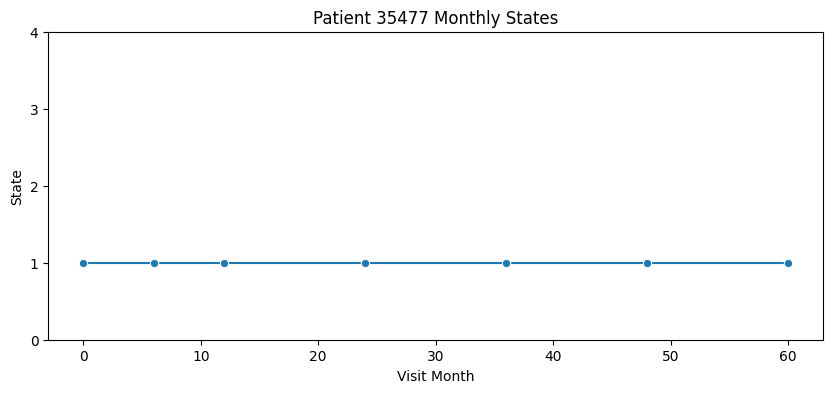

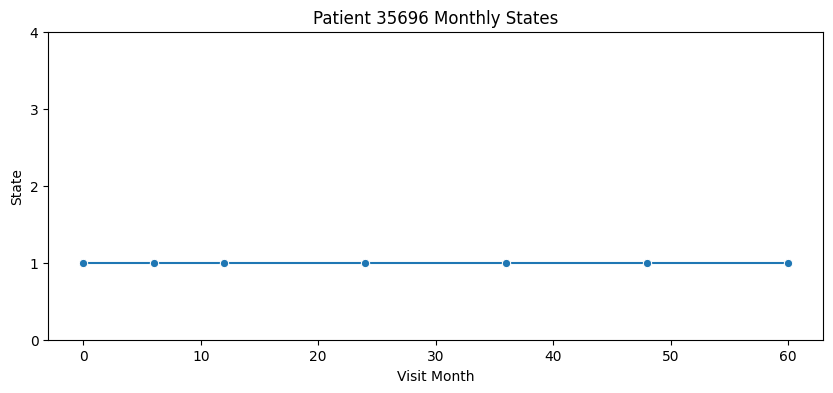

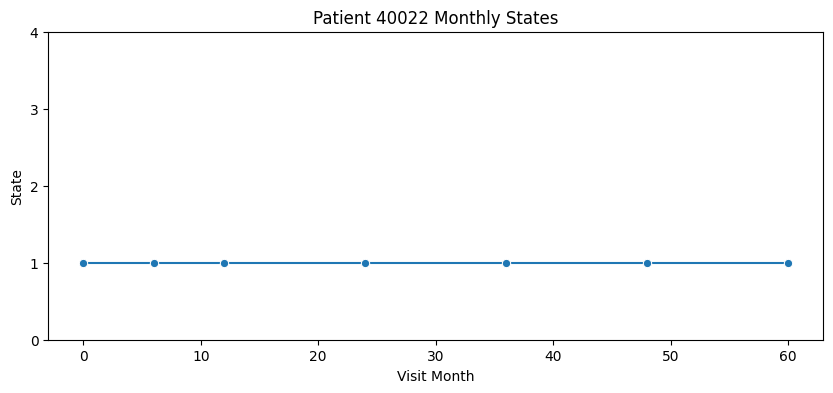

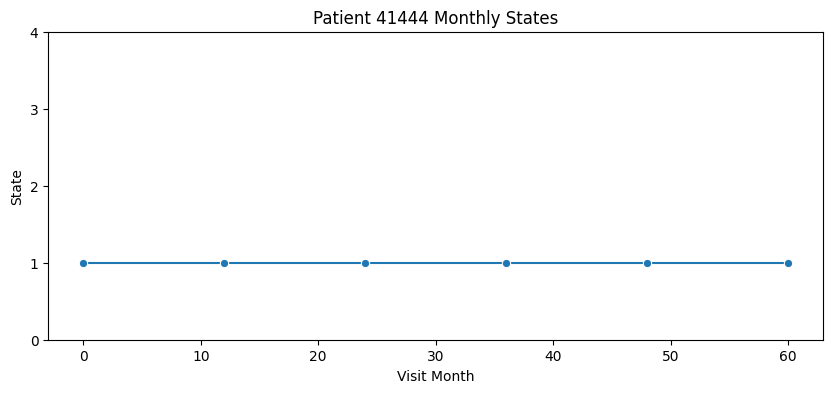

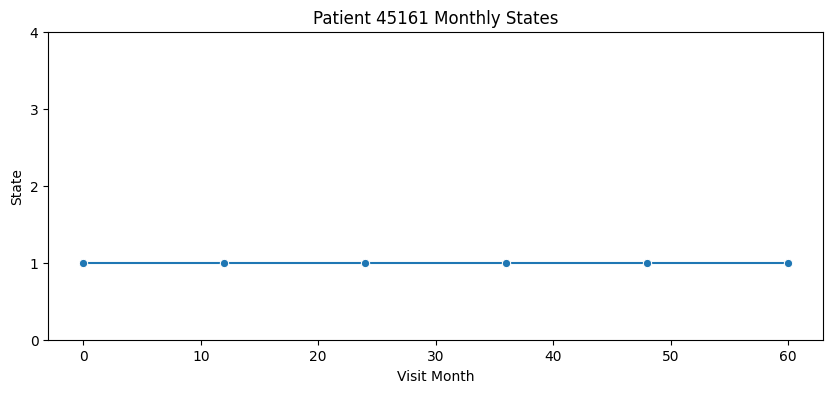

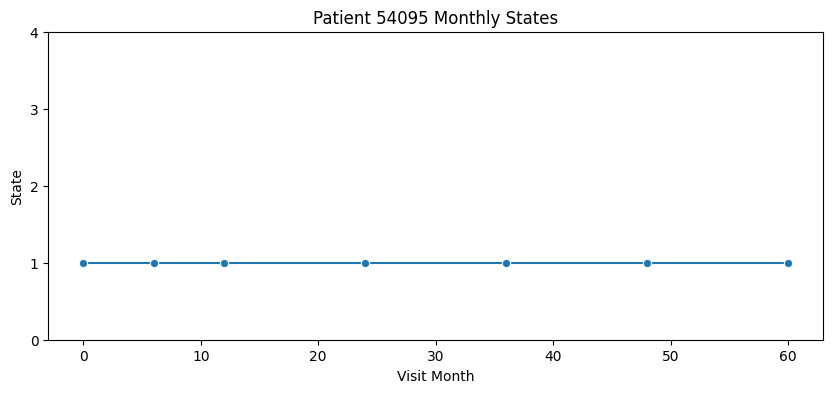

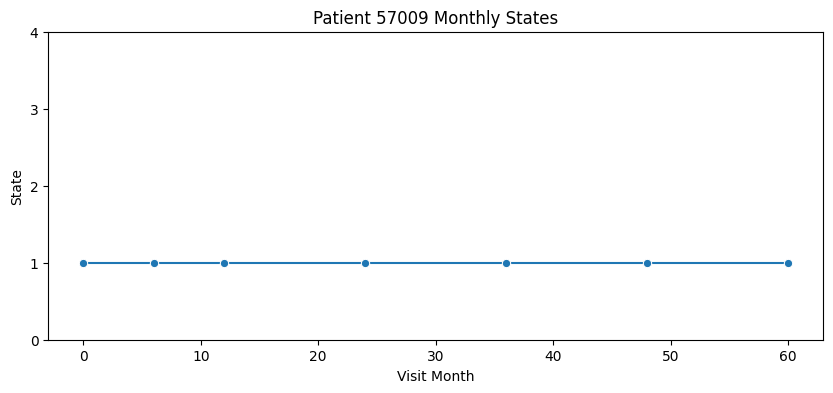

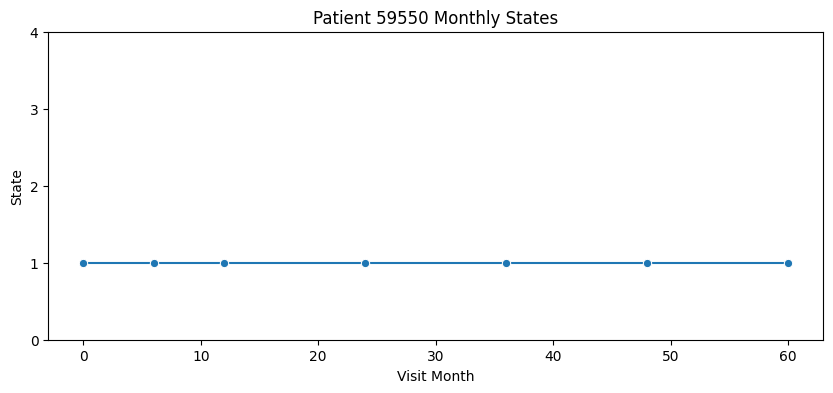

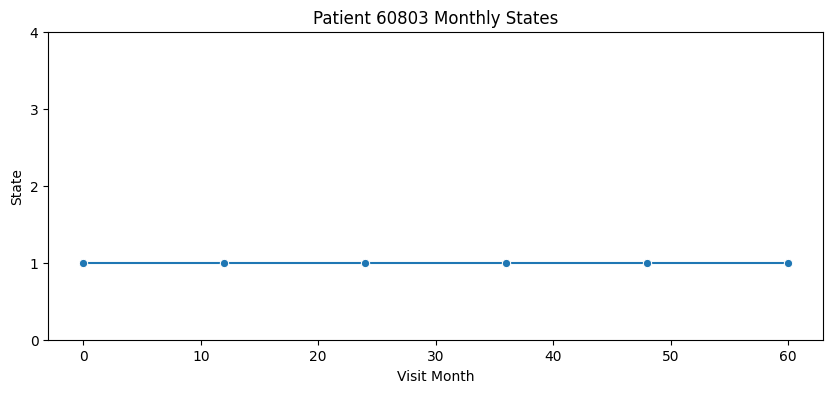

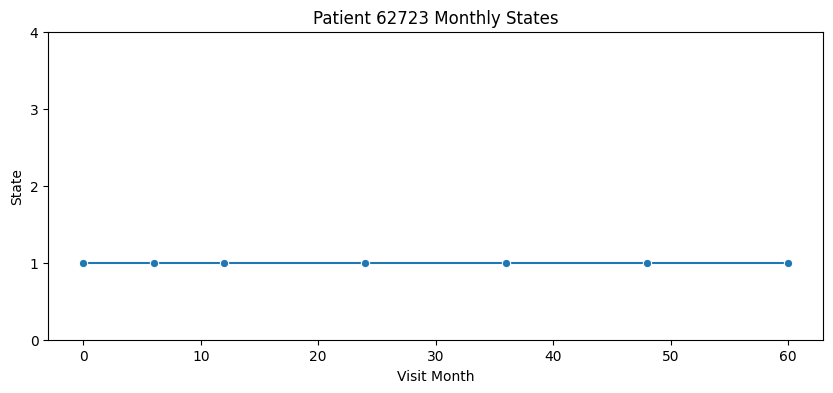

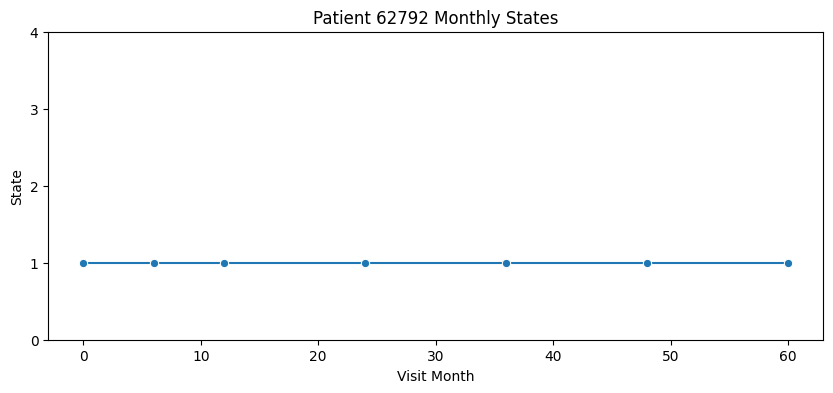

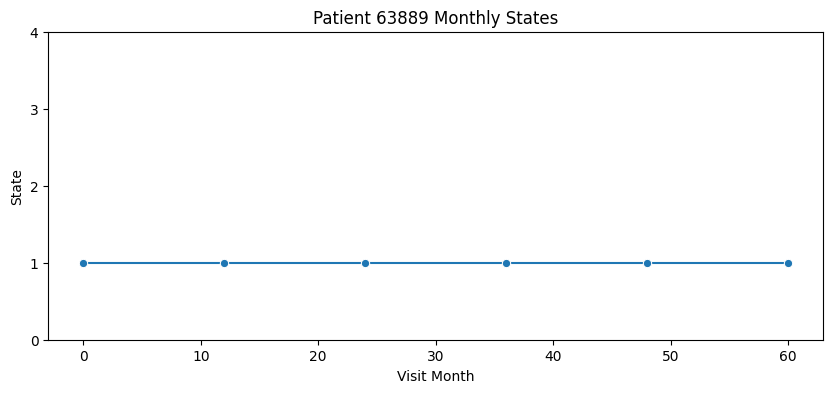

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot each patient's monthly states
for patient_id in patient_month_data['patient_id'].unique():
    patient_data = patient_month_data[patient_month_data['patient_id'] == patient_id]
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=patient_data['visit_month'], y=patient_data['state'], marker='o')
    plt.title(f"Patient {patient_id} Monthly States")
    plt.xlabel("Visit Month")
    plt.ylabel("State")
    plt.yticks(range(n_clusters))  # Ensure y-axis shows all cluster states
    plt.show()

visit_month   0    6    12   24   36   48   60
patient_id                                    
4172         1.0  NaN  1.0  1.0  1.0  1.0  1.0
5178         1.0  1.0  1.0  1.0  1.0  1.0  1.0
6211         1.0  1.0  1.0  1.0  1.0  1.0  1.0
17414        1.0  NaN  1.0  1.0  1.0  1.0  1.0
18183        1.0  1.0  1.0  1.0  1.0  1.0  1.0
20404        1.0  1.0  1.0  1.0  1.0  1.0  1.0
23391        1.0  1.0  1.0  1.0  1.0  1.0  1.0
25562        1.0  NaN  1.0  1.0  2.0  1.0  1.0
26210        1.0  1.0  1.0  1.0  1.0  1.0  1.0
27300        1.0  1.0  1.0  1.0  1.0  1.0  1.0
27468        1.0  1.0  1.0  1.0  1.0  1.0  1.0
28327        1.0  1.0  1.0  1.0  1.0  1.0  1.0
35477        1.0  1.0  1.0  1.0  1.0  1.0  1.0
35696        1.0  1.0  1.0  1.0  1.0  1.0  1.0
40022        1.0  1.0  1.0  1.0  1.0  1.0  1.0
41444        1.0  NaN  1.0  1.0  1.0  1.0  1.0
45161        1.0  NaN  1.0  1.0  1.0  1.0  1.0
54095        1.0  1.0  1.0  1.0  1.0  1.0  1.0
57009        1.0  1.0  1.0  1.0  1.0  1.0  1.0
59550        

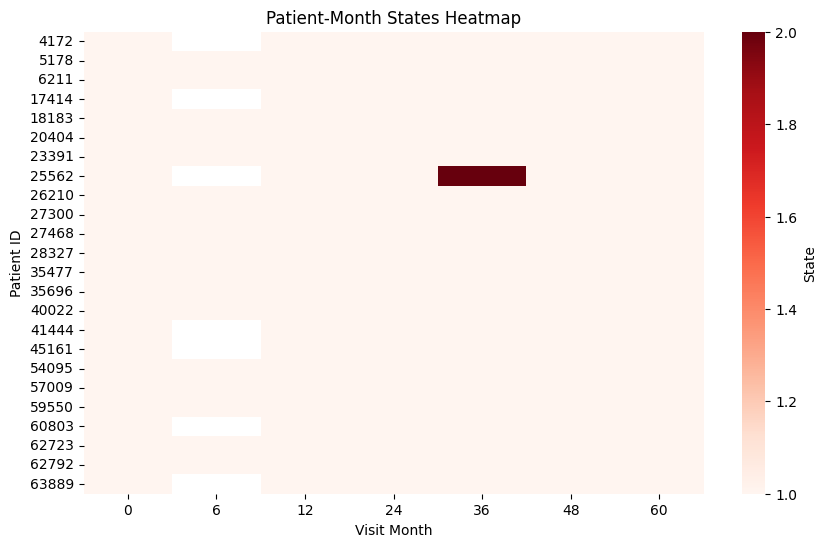

In [ ]:
# Create a pivot table: rows = patients, columns = months, values = states
pivot_table = patient_month_data.pivot(index='patient_id', columns='visit_month', values='state')
print(pivot_table)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=False, cmap='Reds', cbar_kws={'label': 'State'})
plt.title("Patient-Month States Heatmap")
plt.xlabel("Visit Month")
plt.ylabel("Patient ID")
plt.show()

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

# Load ProtBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
# Move the model to the GPU
model = model.to(torch.device("cuda"))
# Function to encode peptide names
def encode_peptide_names(peptide_names):
    inputs = tokenizer(peptide_names, padding=True, truncation=True,max_length=512, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings

# Example: Encode peptide names for a single patient-month
peptide_names = [name for name, _ in patient_month_data['Peptide'][0]]
peptide_embeddings = encode_peptide_names(peptide_names)
print(peptide_embeddings.shape)  # Shape: (num_peptides, embedding_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

torch.Size([931, 1024])


In [ ]:
# Function to combine embeddings and abundances
def combine_embeddings_and_abundances(peptide_data):
    peptide_names = [name for name, _ in peptide_data]
    peptide_abundances = [abundance for _, abundance in peptide_data]

    # Encode peptide names
    peptide_embeddings = encode_peptide_names(peptide_names)

    # Combine embeddings with abundances
    combined_embeddings = peptide_embeddings * torch.tensor(peptide_abundances, device=peptide_embeddings.device).unsqueeze(1)
    return combined_embeddings

# Example: Combine embeddings and abundances for a single patient-month
combined_embeddings = combine_embeddings_and_abundances(patient_month_data['Peptide'][0])
print(combined_embeddings.shape)  # Shape: (num_peptides, embedding_size)

torch.Size([931, 1024])


In [ ]:
# Function to aggregate patient-month embeddings
def aggregate_patient_month_embeddings(patient_month_data):
    patient_month_embeddings = []
    for peptide_data in patient_month_data['Peptide']:
        combined_embeddings = combine_embeddings_and_abundances(peptide_data)
        aggregated_embedding = combined_embeddings.mean(dim=0)  # Mean pooling
        patient_month_embeddings.append(aggregated_embedding)
    return torch.stack(patient_month_embeddings)

# Aggregate embeddings for all patient-month combinations
patient_month_embeddings = aggregate_patient_month_embeddings(patient_month_data)
print(patient_month_embeddings.shape)  # Shape: (num_patient_months, embedding_size)

torch.Size([2, 1024])


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Convert embeddings to numpy array
embeddings_array = patient_month_embeddings.cpu().numpy()

# Perform Agglomerative Clustering
# If the number of samples is less than 3, set n_clusters to 1.
# Otherwise set n_cluster to a number less than the number of samples
n_clusters = min(2, embeddings_array.shape[0] - 1)
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = clustering.fit_predict(embeddings_array)

# Add clusters to the patient_month_data DataFrame
patient_month_data['cluster'] = clusters
print(patient_month_data)

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
# Only calculate if n_clusters is greater than 1
if n_clusters > 1:
    silhouette_avg = silhouette_score(embeddings_array, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette Score cannot be calculated with only one cluster or when the number of samples is less than 3.")

   patient_id  visit_month                                            Peptide  \
0          55            0  [(NEQEQPLGQWHLS, 11254.3), (GNPEPTFSWTK, 10206...   
1        1517            0  [(NEQEQPLGQWHLS, 11648.9), (GNPEPTFSWTK, 63593...   

   cluster  
0        0  
1        0  
Silhouette Score cannot be calculated with only one cluster or when the number of samples is less than 3.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(10, 6))

# Convert 'Peptide' column to strings for hue
# This creates a string representation of the list for visualization purposes
patient_month_data['Peptide_str'] = patient_month_data['Peptide'].astype(str)

sns.scatterplot(x=patient_month_data['visit_month'],
                y=range(len(patient_month_data)),
                hue=patient_month_data['Peptide_str'], # Use the string representation for hue
                palette='viridis',
                s=100)

plt.title("Patient-Month Records Clustered by Disease State")
plt.xlabel("Month")
plt.ylabel("Patient-Month Index")
plt.legend(title="Cluster")
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
del patient_month_data['cluster']
# Convert embeddings to numpy array
embeddings_array = patient_month_embeddings.numpy()

# Perform Agglomerative Clustering
n_clusters = 2  # Adjust based on your data
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = clustering.fit_predict(embeddings_array)

# Add clusters to the patient_month_data DataFrame
patient_month_data['cluster'] = clusters
print(patient_month_data)

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings_array, clusters)
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=patient_month_data['visit_month'], y=range(len(patient_month_data)), hue=patient_month_data['Peptide'], palette='viridis', s=100)
plt.title("Patient-Month Records Clustered by Disease State")
plt.xlabel("Month")
plt.ylabel("Patient-Month Index")
plt.legend(title="Cluster")
plt.show()